In [1]:
import warnings 
warnings.filterwarnings("ignore")

from monai.transforms import (
    Activations,
    AddChannel,
    AsChannelFirst,
    AsDiscrete,
    Compose,
    EnsureType,
    LoadImage,
    RandFlip,
    RandSpatialCrop,
    RandZoom,
    Resize,
    ScaleIntensity,
    ScaleIntensityRange,
    SpatialCrop,
    ToTensor,
)
from monai.config import print_config
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
import monai.utils as utils

import torch

import matplotlib.pyplot as plt

import os
from glob import glob

import numpy as np

import itk

import site
site.addsitedir('../../ARGUS')
from ARGUSUtils_Transforms import *

In [33]:
img1_dir = "../../Data/VFoldData/ROIData/"

all_images = sorted(glob(os.path.join(img1_dir, '*Class[NS]*.roi.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*Class[NS]*.roi.overlay.nii.gz')))

num_classes = 2

num_slices = 48

num_workers_tr = 24
batch_size_tr = 24
num_workers_vl = 24
batch_size_vl = 8

model_filename_base = "BAMC_PTX_2DROI_DenseNet-2Class.best_model.vfold"

num_images = len(all_images)

print(num_images)

num_folds = 15

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns','219ns','221ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

fold_prefix_list = []
fold_label_list = []
ns_count = 0
s_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_ns = 1
        num_s = 1
        if i > num_folds-3:
            num_s = 2
    else:
        num_ns = 1
        num_s = 1
    f = []
    for ns in range(num_ns):
        f.append([ns_prefix[ns_count+ns]])
    ns_count += num_ns
    for s in range(num_s):
        f.append([s_prefix[s_count+s]])
    s_count += num_s
    fold_prefix_list.append(f)
        
train_files = []
train_labels = []
val_files = []
val_labels = []
test_files = []
test_labels = []
for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    img = [im for im in all_images if any(pref in im for pref in tr_folds)]
    seg = []
    for im in img:
        if "ClassN" in im:
            seg.append(0)
        else:
            seg.append(1)
    print(seg)
    train_files.append(img)
    train_labels.append(seg)
    img = [im for im in all_images if any(pref in im for pref in va_folds)]
    seg = []
    for im in img:
        if "ClassN" in im:
            seg.append(0)
        else:
            seg.append(1)
    print(seg)
    val_files.append(img)
    val_labels.append(seg)
    img = [im for im in all_images if any(pref in im for pref in te_folds)]
    seg = []
    for im in img:
        if "ClassN" in im:
            seg.append(0)
        else:
            seg.append(1)
    print(seg)
    test_files.append(img)
    test_labels.append(seg)
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))
    print(len(train_labels[i]),len(val_labels[i]),len(test_labels[i]))

108
[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
[0, 0, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 0, 0, 0]
94 6 8
94 6 8
[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 0, 0, 0]
[1, 1, 1, 1, 0, 0, 0, 0, 0]
91 8 9
91 8 9
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
[1, 1, 1, 1, 0, 0, 0, 0, 0]
[1, 1, 1,

In [34]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        AsChannelFirst(),
        ARGUS_RandSpatialCropSlices(
            num_slices=num_slices,
            axis=0,
            reduce_to_statistics=True),
        ScaleIntensity(
            channel_wise=True),
        RandFlip(prob=0.5, 
            spatial_axis=1),
        RandZoom(prob=0.5, 
            min_zoom=1.0,
            max_zoom=1.2,
            keep_size=True,
            mode='bilinear'),
        EnsureType(),
    ]
)

val_transforms = Compose(
    [
        LoadImage(image_only=True), 
        AsChannelFirst(),
        ARGUS_RandSpatialCropSlices(
            num_slices=num_slices,
            axis=0,
            center_slice=30,
            reduce_to_statistics=True),
        ScaleIntensity(), 
        EnsureType()
    ]
)

y_pred_trans = Compose([EnsureType(), Activations(softmax=True)])
y_trans = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])

In [35]:
class PTXDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

In [36]:
train_ds = [PTXDataset(train_files[i], train_labels[i], train_transforms) for i in range(num_folds)]
train_loader = [torch.utils.data.DataLoader(train_ds[i], batch_size=batch_size_tr, shuffle=True, num_workers=num_workers_tr) 
                for i in range(num_folds)]

val_ds = [PTXDataset(val_files[i], val_labels[i], train_transforms) for i in range(num_folds)]
val_loader = [torch.utils.data.DataLoader(val_ds[i], batch_size=batch_size_vl, num_workers=num_workers_vl)
              for i in range(num_folds)]

In [37]:
imgnum = 2
img, lbl = utils.first(train_loader[0])

tensor(1)
Data Size = torch.Size([24, 2, 128, 224])
ROI Size = torch.Size([128, 224])


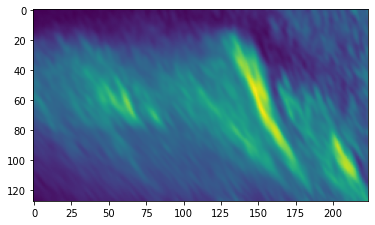

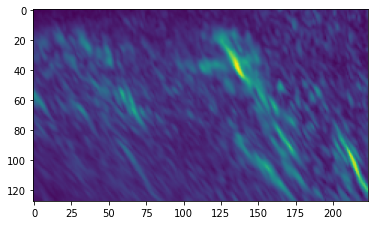

In [38]:
print(lbl[0])
plt.subplots()
plt.imshow(img[imgnum,0,:,:])
plt.subplots()
plt.imshow(img[imgnum,1,:,:])
print("Data Size =", img.shape)
roi_size = img.shape[2:]
print("ROI Size =", roi_size)

In [ ]:
device = torch.device("cuda:0")

def vfold_train(vfold_num, train_loader, val_loader):
    model = DenseNet121(spatial_dims=2, in_channels=2,
                        out_channels=num_classes).to(device)
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), 1e-5)
    auc_metric = ROCAUCMetric()

    max_epochs = 1000
    val_interval = 2
    
    best_metric = num_classes*100
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"{vfold_num}: epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(
                f"{step}/{len(train_ds) // train_loader.batch_size}, "
                f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"{vfold_num} epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                y_pred = torch.tensor([], dtype=torch.float32, device=device)
                y = torch.tensor([], dtype=torch.long, device=device)
                for val_data in val_loader:
                    vimages, vlabels = (
                        val_data[0].to(device),
                        val_data[1].to(device),
                    )
                    y_pred = torch.cat([y_pred, model(vimages)], dim=0)
                    y = torch.cat([y, vlabels], dim=0)
                y_onehot = [y_trans(i) for i in decollate_batch(y)]
                y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
                diff = 0
                for i in range(len(y_onehot)):
                    for c in range(num_classes):
                        diff += (y_onehot[i][c] - y_pred_act[i][c])**2
                result = float(diff)
                del y_pred_act, y_onehot
                metric_values.append(result)
                acc_value = torch.eq(y_pred.argmax(dim=1), y)
                acc_metric = acc_value.sum().item() / len(acc_value)
                if result <= best_metric:
                    best_metric = result
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(),
                        model_filename_base+".best_metric_model.pth")
                    print("saved new best metric model")
                torch.save(model.state_dict(),
                    model_filename_base+".last_metric_model.pth")
                print(
                    f"current epoch: {epoch + 1} current SSD: {result:.4f}"
                    f" current accuracy: {acc_metric:.4f}"
                    f" best SSD: {best_metric:.4f}"
                    f" at epoch: {best_metric_epoch}"
                    )

    np.save(model_filename_base+"_loss_"+str(vfold_num)+".npy", epoch_loss_values)
    np.save(model_filename_base+"_auc_"+str(vfold_num)+".npy", metric_values)

# In[ ]:


for i in range(num_folds):
    vfold_train(i, train_loader[i], val_loader[i])


# In[ ]:

----------
0: epoch 1/1000
1/0, train_loss: 0.7233
2/0, train_loss: 0.6705
3/0, train_loss: 0.7624
4/0, train_loss: 0.6996
0 epoch 1 average loss: 0.7140
----------
0: epoch 2/1000
1/0, train_loss: 0.6921
2/0, train_loss: 0.6918
3/0, train_loss: 0.6939
4/0, train_loss: 0.6906
0 epoch 2 average loss: 0.6921
saved new best metric model
current epoch: 2 current SSD: 3.0720 current accuracy: 0.3333 best SSD: 3.0720 at epoch: 2
----------
0: epoch 3/1000
1/0, train_loss: 0.6795
2/0, train_loss: 0.6882
3/0, train_loss: 0.6720
4/0, train_loss: 0.6514
0 epoch 3 average loss: 0.6728
----------
0: epoch 4/1000
1/0, train_loss: 0.6977
2/0, train_loss: 0.6345
3/0, train_loss: 0.6649
4/0, train_loss: 0.6905
0 epoch 4 average loss: 0.6719
saved new best metric model
current epoch: 4 current SSD: 2.8998 current accuracy: 0.6667 best SSD: 2.8998 at epoch: 4
----------
0: epoch 5/1000
1/0, train_loss: 0.6177
2/0, train_loss: 0.6658
3/0, train_loss: 0.6519
4/0, train_loss: 0.6592
0 epoch 5 average loss:

3/0, train_loss: 0.3496
4/0, train_loss: 0.3679
0 epoch 41 average loss: 0.3518
----------
0: epoch 42/1000
1/0, train_loss: 0.2252
2/0, train_loss: 0.2980
3/0, train_loss: 0.3509
4/0, train_loss: 0.3698
0 epoch 42 average loss: 0.3110
current epoch: 42 current SSD: 3.3105 current accuracy: 0.5000 best SSD: 2.8339 at epoch: 6
----------
0: epoch 43/1000
1/0, train_loss: 0.2588
2/0, train_loss: 0.3927
3/0, train_loss: 0.3049
4/0, train_loss: 0.2911
0 epoch 43 average loss: 0.3119
----------
0: epoch 44/1000
1/0, train_loss: 0.2914
2/0, train_loss: 0.2798
3/0, train_loss: 0.3607
4/0, train_loss: 0.2358
0 epoch 44 average loss: 0.2919
current epoch: 44 current SSD: 3.2453 current accuracy: 0.5000 best SSD: 2.8339 at epoch: 6
----------
0: epoch 45/1000
1/0, train_loss: 0.2301
2/0, train_loss: 0.2219
3/0, train_loss: 0.5166
4/0, train_loss: 0.3438
0 epoch 45 average loss: 0.3281
----------
0: epoch 46/1000
1/0, train_loss: 0.2695
2/0, train_loss: 0.3848
3/0, train_loss: 0.3199
4/0, train_l

4/0, train_loss: 0.2068
0 epoch 81 average loss: 0.1668
----------
0: epoch 82/1000
1/0, train_loss: 0.0929
2/0, train_loss: 0.1285
3/0, train_loss: 0.1711
4/0, train_loss: 0.1519
0 epoch 82 average loss: 0.1361
saved new best metric model
current epoch: 82 current SSD: 2.4680 current accuracy: 0.5000 best SSD: 2.4680 at epoch: 82
----------
0: epoch 83/1000
1/0, train_loss: 0.1056
2/0, train_loss: 0.0937
3/0, train_loss: 0.1219
4/0, train_loss: 0.1342
0 epoch 83 average loss: 0.1138
----------
0: epoch 84/1000
1/0, train_loss: 0.0712
2/0, train_loss: 0.0894
3/0, train_loss: 0.1145
4/0, train_loss: 0.1628
0 epoch 84 average loss: 0.1095
current epoch: 84 current SSD: 2.5929 current accuracy: 0.5000 best SSD: 2.4680 at epoch: 82
----------
0: epoch 85/1000
1/0, train_loss: 0.0942
2/0, train_loss: 0.1376
3/0, train_loss: 0.1217
4/0, train_loss: 0.0753
0 epoch 85 average loss: 0.1072
----------
0: epoch 86/1000
1/0, train_loss: 0.0594
2/0, train_loss: 0.0951
3/0, train_loss: 0.1383
4/0, t

4/0, train_loss: 0.0487
0 epoch 121 average loss: 0.0502
----------
0: epoch 122/1000
1/0, train_loss: 0.0345
2/0, train_loss: 0.0242
3/0, train_loss: 0.0239
4/0, train_loss: 0.0595
0 epoch 122 average loss: 0.0355
current epoch: 122 current SSD: 2.8275 current accuracy: 0.5000 best SSD: 2.4342 at epoch: 110
----------
0: epoch 123/1000
1/0, train_loss: 0.0391
2/0, train_loss: 0.0476
3/0, train_loss: 0.0462
4/0, train_loss: 0.0292
0 epoch 123 average loss: 0.0405
----------
0: epoch 124/1000
1/0, train_loss: 0.0499
2/0, train_loss: 0.0837
3/0, train_loss: 0.0405
4/0, train_loss: 0.0303
0 epoch 124 average loss: 0.0511
current epoch: 124 current SSD: 2.9359 current accuracy: 0.5000 best SSD: 2.4342 at epoch: 110
----------
0: epoch 125/1000
1/0, train_loss: 0.0330
2/0, train_loss: 0.0448
3/0, train_loss: 0.0337
4/0, train_loss: 0.0347
0 epoch 125 average loss: 0.0366
----------
0: epoch 126/1000
1/0, train_loss: 0.0625
2/0, train_loss: 0.0342
3/0, train_loss: 0.0332
4/0, train_loss: 0.0

Traceback (most recent call last):
  File "/home/local/KHQ/stephen.aylward/anaconda3/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/home/local/KHQ/stephen.aylward/anaconda3/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/local/KHQ/stephen.aylward/anaconda3/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/home/local/KHQ/stephen.aylward/anaconda3/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
Traceback (most recent call last):
  File "/home/local/KHQ/stephen.aylward/anaconda3/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/home/local/KHQ/stephen.aylward/anaconda3/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/local/KHQ/stephen.aylward/anaconda3/lib/python3.8/multiprocessing/

current epoch: 126 current SSD: 3.0507 current accuracy: 0.5000 best SSD: 2.4342 at epoch: 110
----------
0: epoch 127/1000
1/0, train_loss: 0.0492
2/0, train_loss: 0.0536
3/0, train_loss: 0.0348
4/0, train_loss: 0.0218
0 epoch 127 average loss: 0.0398
----------
0: epoch 128/1000
1/0, train_loss: 0.0543
2/0, train_loss: 0.0346
3/0, train_loss: 0.1025
4/0, train_loss: 0.0286
0 epoch 128 average loss: 0.0550
current epoch: 128 current SSD: 3.1256 current accuracy: 0.5000 best SSD: 2.4342 at epoch: 110
----------
0: epoch 129/1000
1/0, train_loss: 0.0316
2/0, train_loss: 0.0504
3/0, train_loss: 0.0329
4/0, train_loss: 0.0328
0 epoch 129 average loss: 0.0369
----------
0: epoch 130/1000
1/0, train_loss: 0.0451
2/0, train_loss: 0.0233
3/0, train_loss: 0.0530
4/0, train_loss: 0.0703
0 epoch 130 average loss: 0.0479
current epoch: 130 current SSD: 3.3158 current accuracy: 0.5000 best SSD: 2.4342 at epoch: 110
----------
0: epoch 131/1000
1/0, train_loss: 0.0368
2/0, train_loss: 0.0266
3/0, t

current epoch: 166 current SSD: 2.8421 current accuracy: 0.5000 best SSD: 2.4342 at epoch: 110
----------
0: epoch 167/1000
1/0, train_loss: 0.0185
2/0, train_loss: 0.0286
3/0, train_loss: 0.0160
4/0, train_loss: 0.0125
0 epoch 167 average loss: 0.0189
----------
0: epoch 168/1000
1/0, train_loss: 0.0250
2/0, train_loss: 0.0398
3/0, train_loss: 0.0178
4/0, train_loss: 0.0301
0 epoch 168 average loss: 0.0282
current epoch: 168 current SSD: 2.9623 current accuracy: 0.5000 best SSD: 2.4342 at epoch: 110
----------
0: epoch 169/1000
1/0, train_loss: 0.0602
2/0, train_loss: 0.0102
3/0, train_loss: 0.0122
4/0, train_loss: 0.0378
0 epoch 169 average loss: 0.0301
----------
0: epoch 170/1000
1/0, train_loss: 0.0288
2/0, train_loss: 0.0237
3/0, train_loss: 0.0676
4/0, train_loss: 0.0595
0 epoch 170 average loss: 0.0449
current epoch: 170 current SSD: 3.1143 current accuracy: 0.5000 best SSD: 2.4342 at epoch: 110
----------
0: epoch 171/1000
1/0, train_loss: 0.0140
2/0, train_loss: 0.0137
3/0, t

4/0, train_loss: 0.0103
0 epoch 206 average loss: 0.0080
current epoch: 206 current SSD: 3.3217 current accuracy: 0.5000 best SSD: 1.9990 at epoch: 190
----------
0: epoch 207/1000
1/0, train_loss: 0.0152
2/0, train_loss: 0.0124
3/0, train_loss: 0.0147
4/0, train_loss: 0.0098
0 epoch 207 average loss: 0.0130
----------
0: epoch 208/1000
1/0, train_loss: 0.0056
2/0, train_loss: 0.0164
3/0, train_loss: 0.0210
4/0, train_loss: 0.0094
0 epoch 208 average loss: 0.0131
current epoch: 208 current SSD: 3.4477 current accuracy: 0.5000 best SSD: 1.9990 at epoch: 190
----------
0: epoch 209/1000
1/0, train_loss: 0.0089
2/0, train_loss: 0.0075
3/0, train_loss: 0.0080
4/0, train_loss: 0.0082
0 epoch 209 average loss: 0.0082
----------
0: epoch 210/1000
1/0, train_loss: 0.0209
2/0, train_loss: 0.0080
3/0, train_loss: 0.0125
4/0, train_loss: 0.0126
0 epoch 210 average loss: 0.0135
current epoch: 210 current SSD: 3.5895 current accuracy: 0.5000 best SSD: 1.9990 at epoch: 190
----------
0: epoch 211/10

4/0, train_loss: 0.0084
0 epoch 246 average loss: 0.0160
current epoch: 246 current SSD: 3.4123 current accuracy: 0.5000 best SSD: 1.9990 at epoch: 190
----------
0: epoch 247/1000
1/0, train_loss: 0.0059
2/0, train_loss: 0.0094
3/0, train_loss: 0.0507
4/0, train_loss: 0.0045
0 epoch 247 average loss: 0.0176
----------
0: epoch 248/1000
1/0, train_loss: 0.0172
2/0, train_loss: 0.0061
3/0, train_loss: 0.0060
4/0, train_loss: 0.0131
0 epoch 248 average loss: 0.0106
current epoch: 248 current SSD: 3.8588 current accuracy: 0.5000 best SSD: 1.9990 at epoch: 190
----------
0: epoch 249/1000
1/0, train_loss: 0.0078
2/0, train_loss: 0.0167
3/0, train_loss: 0.0142
4/0, train_loss: 0.0133
0 epoch 249 average loss: 0.0130
----------
0: epoch 250/1000
1/0, train_loss: 0.0130
2/0, train_loss: 0.0047
3/0, train_loss: 0.0059
4/0, train_loss: 0.0092
0 epoch 250 average loss: 0.0082
current epoch: 250 current SSD: 3.8245 current accuracy: 0.5000 best SSD: 1.9990 at epoch: 190
----------
0: epoch 251/10

4/0, train_loss: 0.0292
0 epoch 286 average loss: 0.0114
current epoch: 286 current SSD: 3.3942 current accuracy: 0.5000 best SSD: 1.9990 at epoch: 190
----------
0: epoch 287/1000
1/0, train_loss: 0.0311
2/0, train_loss: 0.0053
3/0, train_loss: 0.0162
4/0, train_loss: 0.0031
0 epoch 287 average loss: 0.0139
----------
0: epoch 288/1000
1/0, train_loss: 0.0119
2/0, train_loss: 0.0045
3/0, train_loss: 0.0045
4/0, train_loss: 0.0033
0 epoch 288 average loss: 0.0060
current epoch: 288 current SSD: 3.4622 current accuracy: 0.5000 best SSD: 1.9990 at epoch: 190
----------
0: epoch 289/1000
1/0, train_loss: 0.0237
2/0, train_loss: 0.0033
3/0, train_loss: 0.0038
4/0, train_loss: 0.0434
0 epoch 289 average loss: 0.0185
----------
0: epoch 290/1000
1/0, train_loss: 0.0090
2/0, train_loss: 0.0046
3/0, train_loss: 0.0170
4/0, train_loss: 0.0041
0 epoch 290 average loss: 0.0087
current epoch: 290 current SSD: 3.1543 current accuracy: 0.5000 best SSD: 1.9990 at epoch: 190
----------
0: epoch 291/10

3/0, train_loss: 0.0078
4/0, train_loss: 0.0031
0 epoch 326 average loss: 0.0048
current epoch: 326 current SSD: 4.1407 current accuracy: 0.5000 best SSD: 1.9990 at epoch: 190
----------
0: epoch 327/1000
1/0, train_loss: 0.0061
2/0, train_loss: 0.0051
3/0, train_loss: 0.0035
4/0, train_loss: 0.0045
0 epoch 327 average loss: 0.0048
----------
0: epoch 328/1000
1/0, train_loss: 0.0043
2/0, train_loss: 0.0022
3/0, train_loss: 0.0029
4/0, train_loss: 0.0048
0 epoch 328 average loss: 0.0036
current epoch: 328 current SSD: 3.8840 current accuracy: 0.5000 best SSD: 1.9990 at epoch: 190
----------
0: epoch 329/1000
1/0, train_loss: 0.0068
2/0, train_loss: 0.0040
3/0, train_loss: 0.0023
4/0, train_loss: 0.0020
0 epoch 329 average loss: 0.0038
----------
0: epoch 330/1000
1/0, train_loss: 0.0027
2/0, train_loss: 0.0038
3/0, train_loss: 0.0027
4/0, train_loss: 0.0048
0 epoch 330 average loss: 0.0035
current epoch: 330 current SSD: 3.7540 current accuracy: 0.5000 best SSD: 1.9990 at epoch: 190
--

4/0, train_loss: 0.0048
0 epoch 366 average loss: 0.0225
current epoch: 366 current SSD: 3.6828 current accuracy: 0.5000 best SSD: 1.9990 at epoch: 190
----------
0: epoch 367/1000
1/0, train_loss: 0.0035
2/0, train_loss: 0.0076
3/0, train_loss: 0.0120
4/0, train_loss: 0.0079
0 epoch 367 average loss: 0.0078
----------
0: epoch 368/1000
1/0, train_loss: 0.0027
2/0, train_loss: 0.0030
3/0, train_loss: 0.0027
4/0, train_loss: 0.0050
0 epoch 368 average loss: 0.0033
current epoch: 368 current SSD: 3.6332 current accuracy: 0.5000 best SSD: 1.9990 at epoch: 190
----------
0: epoch 369/1000
1/0, train_loss: 0.0028
2/0, train_loss: 0.0035
3/0, train_loss: 0.0037
4/0, train_loss: 0.0019
0 epoch 369 average loss: 0.0030
----------
0: epoch 370/1000
1/0, train_loss: 0.0067
2/0, train_loss: 0.0047
3/0, train_loss: 0.0141
4/0, train_loss: 0.0039
0 epoch 370 average loss: 0.0074
current epoch: 370 current SSD: 4.0587 current accuracy: 0.5000 best SSD: 1.9990 at epoch: 190
----------
0: epoch 371/10

4/0, train_loss: 0.0038
0 epoch 406 average loss: 0.0027
current epoch: 406 current SSD: 4.1726 current accuracy: 0.5000 best SSD: 1.9990 at epoch: 190
----------
0: epoch 407/1000
1/0, train_loss: 0.0014
2/0, train_loss: 0.0028
3/0, train_loss: 0.0026
4/0, train_loss: 0.0022
0 epoch 407 average loss: 0.0023
----------
0: epoch 408/1000
1/0, train_loss: 0.0035
2/0, train_loss: 0.0041
3/0, train_loss: 0.0023
4/0, train_loss: 0.0016
0 epoch 408 average loss: 0.0029
current epoch: 408 current SSD: 4.3844 current accuracy: 0.5000 best SSD: 1.9990 at epoch: 190
----------
0: epoch 409/1000
1/0, train_loss: 0.0032
2/0, train_loss: 0.0015
3/0, train_loss: 0.0025
4/0, train_loss: 0.0800
0 epoch 409 average loss: 0.0218
----------
0: epoch 410/1000
1/0, train_loss: 0.0035
2/0, train_loss: 0.0017
3/0, train_loss: 0.0027
4/0, train_loss: 0.0081
0 epoch 410 average loss: 0.0040
current epoch: 410 current SSD: 6.0027 current accuracy: 0.3333 best SSD: 1.9990 at epoch: 190
----------
0: epoch 411/10

4/0, train_loss: 0.0015
0 epoch 446 average loss: 0.0016
current epoch: 446 current SSD: 4.8860 current accuracy: 0.5000 best SSD: 1.9990 at epoch: 190
----------
0: epoch 447/1000
1/0, train_loss: 0.0019
2/0, train_loss: 0.0021
3/0, train_loss: 0.0103
4/0, train_loss: 0.0011
0 epoch 447 average loss: 0.0039
----------
0: epoch 448/1000
1/0, train_loss: 0.0020
2/0, train_loss: 0.0013
3/0, train_loss: 0.0013
4/0, train_loss: 0.0075
0 epoch 448 average loss: 0.0030
current epoch: 448 current SSD: 5.1903 current accuracy: 0.5000 best SSD: 1.9990 at epoch: 190
----------
0: epoch 449/1000
1/0, train_loss: 0.0021
2/0, train_loss: 0.0053
3/0, train_loss: 0.0274
4/0, train_loss: 0.0026
0 epoch 449 average loss: 0.0094
----------
0: epoch 450/1000
1/0, train_loss: 0.0018
2/0, train_loss: 0.0072
3/0, train_loss: 0.0039
4/0, train_loss: 0.0020
0 epoch 450 average loss: 0.0037
current epoch: 450 current SSD: 4.4166 current accuracy: 0.5000 best SSD: 1.9990 at epoch: 190
----------
0: epoch 451/10

4/0, train_loss: 0.0016
0 epoch 486 average loss: 0.0034
current epoch: 486 current SSD: 3.2874 current accuracy: 0.5000 best SSD: 1.8047 at epoch: 474
----------
0: epoch 487/1000
1/0, train_loss: 0.0025
2/0, train_loss: 0.0034
3/0, train_loss: 0.0015
4/0, train_loss: 0.0012
0 epoch 487 average loss: 0.0021
----------
0: epoch 488/1000
1/0, train_loss: 0.0012
2/0, train_loss: 0.0041
3/0, train_loss: 0.0019
4/0, train_loss: 0.0012
0 epoch 488 average loss: 0.0021
current epoch: 488 current SSD: 3.0264 current accuracy: 0.5000 best SSD: 1.8047 at epoch: 474
----------
0: epoch 489/1000
1/0, train_loss: 0.0034
2/0, train_loss: 0.0010
3/0, train_loss: 0.0042
4/0, train_loss: 0.0015
0 epoch 489 average loss: 0.0025
----------
0: epoch 490/1000
1/0, train_loss: 0.0014
2/0, train_loss: 0.0012
3/0, train_loss: 0.0018
4/0, train_loss: 0.0018
0 epoch 490 average loss: 0.0015
current epoch: 490 current SSD: 2.9768 current accuracy: 0.5000 best SSD: 1.8047 at epoch: 474
----------
0: epoch 491/10

4/0, train_loss: 0.0012
0 epoch 526 average loss: 0.0029
current epoch: 526 current SSD: 4.6079 current accuracy: 0.5000 best SSD: 1.8047 at epoch: 474
----------
0: epoch 527/1000
1/0, train_loss: 0.0037
2/0, train_loss: 0.0063
3/0, train_loss: 0.0042
4/0, train_loss: 0.0059
0 epoch 527 average loss: 0.0050
----------
0: epoch 528/1000
1/0, train_loss: 0.0035
2/0, train_loss: 0.0044
3/0, train_loss: 0.0021
4/0, train_loss: 0.0013
0 epoch 528 average loss: 0.0028
current epoch: 528 current SSD: 4.5824 current accuracy: 0.5000 best SSD: 1.8047 at epoch: 474
----------
0: epoch 529/1000
1/0, train_loss: 0.0011
2/0, train_loss: 0.0009
3/0, train_loss: 0.0013
4/0, train_loss: 0.0026
0 epoch 529 average loss: 0.0014
----------
0: epoch 530/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0010
3/0, train_loss: 0.0013
4/0, train_loss: 0.0014
0 epoch 530 average loss: 0.0011
current epoch: 530 current SSD: 4.2987 current accuracy: 0.5000 best SSD: 1.8047 at epoch: 474
----------
0: epoch 531/10

4/0, train_loss: 0.0008
0 epoch 566 average loss: 0.0008
current epoch: 566 current SSD: 4.4657 current accuracy: 0.5000 best SSD: 1.8047 at epoch: 474
----------
0: epoch 567/1000
1/0, train_loss: 0.0011
2/0, train_loss: 0.0015
3/0, train_loss: 0.0018
4/0, train_loss: 0.0037
0 epoch 567 average loss: 0.0020
----------
0: epoch 568/1000
1/0, train_loss: 0.0015
2/0, train_loss: 0.0072
3/0, train_loss: 0.0015
4/0, train_loss: 0.0047
0 epoch 568 average loss: 0.0037
current epoch: 568 current SSD: 4.3285 current accuracy: 0.5000 best SSD: 1.8047 at epoch: 474
----------
0: epoch 569/1000
1/0, train_loss: 0.0011
2/0, train_loss: 0.0008
3/0, train_loss: 0.0006
4/0, train_loss: 0.0012
0 epoch 569 average loss: 0.0009
----------
0: epoch 570/1000
1/0, train_loss: 0.0011
2/0, train_loss: 0.0008
3/0, train_loss: 0.0007
4/0, train_loss: 0.0010
0 epoch 570 average loss: 0.0009
current epoch: 570 current SSD: 4.1236 current accuracy: 0.5000 best SSD: 1.8047 at epoch: 474
----------
0: epoch 571/10

4/0, train_loss: 0.0011
0 epoch 606 average loss: 0.0011
current epoch: 606 current SSD: 3.8270 current accuracy: 0.5000 best SSD: 1.8047 at epoch: 474
----------
0: epoch 607/1000
1/0, train_loss: 0.0026
2/0, train_loss: 0.0006
3/0, train_loss: 0.0006
4/0, train_loss: 0.0023
0 epoch 607 average loss: 0.0015
----------
0: epoch 608/1000
1/0, train_loss: 0.0030
2/0, train_loss: 0.0009
3/0, train_loss: 0.0009
4/0, train_loss: 0.0009
0 epoch 608 average loss: 0.0014
current epoch: 608 current SSD: 3.7726 current accuracy: 0.5000 best SSD: 1.8047 at epoch: 474
----------
0: epoch 609/1000
1/0, train_loss: 0.0025
2/0, train_loss: 0.0009
3/0, train_loss: 0.0008
4/0, train_loss: 0.0044
0 epoch 609 average loss: 0.0021
----------
0: epoch 610/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0009
3/0, train_loss: 0.0012
4/0, train_loss: 0.0009
0 epoch 610 average loss: 0.0009
current epoch: 610 current SSD: 3.6668 current accuracy: 0.5000 best SSD: 1.8047 at epoch: 474
----------
0: epoch 611/10

4/0, train_loss: 0.0005
0 epoch 646 average loss: 0.0020
current epoch: 646 current SSD: 3.9352 current accuracy: 0.5000 best SSD: 1.8047 at epoch: 474
----------
0: epoch 647/1000
1/0, train_loss: 0.0030
2/0, train_loss: 0.0006
3/0, train_loss: 0.0014
4/0, train_loss: 0.0010
0 epoch 647 average loss: 0.0015
----------
0: epoch 648/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0007
3/0, train_loss: 0.0057
4/0, train_loss: 0.0015
0 epoch 648 average loss: 0.0021
current epoch: 648 current SSD: 4.0652 current accuracy: 0.5000 best SSD: 1.8047 at epoch: 474
----------
0: epoch 649/1000
1/0, train_loss: 0.0048
2/0, train_loss: 0.0008
3/0, train_loss: 0.0103
4/0, train_loss: 0.0006
0 epoch 649 average loss: 0.0041
----------
0: epoch 650/1000
1/0, train_loss: 0.0009
2/0, train_loss: 0.0012
3/0, train_loss: 0.0036
4/0, train_loss: 0.0159
0 epoch 650 average loss: 0.0054
current epoch: 650 current SSD: 4.2330 current accuracy: 0.5000 best SSD: 1.8047 at epoch: 474
----------
0: epoch 651/10

4/0, train_loss: 0.0005
0 epoch 686 average loss: 0.0007
current epoch: 686 current SSD: 3.9965 current accuracy: 0.5000 best SSD: 1.8047 at epoch: 474
----------
0: epoch 687/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0007
3/0, train_loss: 0.0005
4/0, train_loss: 0.0008
0 epoch 687 average loss: 0.0006
----------
0: epoch 688/1000
1/0, train_loss: 0.0030
2/0, train_loss: 0.0016
3/0, train_loss: 0.0019
4/0, train_loss: 0.0005
0 epoch 688 average loss: 0.0018
current epoch: 688 current SSD: 4.1001 current accuracy: 0.5000 best SSD: 1.8047 at epoch: 474
----------
0: epoch 689/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0004
3/0, train_loss: 0.0009
4/0, train_loss: 0.0005
0 epoch 689 average loss: 0.0007
----------
0: epoch 690/1000
1/0, train_loss: 0.0011
2/0, train_loss: 0.0028
3/0, train_loss: 0.0006
4/0, train_loss: 0.0007
0 epoch 690 average loss: 0.0013
current epoch: 690 current SSD: 4.0384 current accuracy: 0.5000 best SSD: 1.8047 at epoch: 474
----------
0: epoch 691/10

4/0, train_loss: 0.0010
0 epoch 726 average loss: 0.0008
current epoch: 726 current SSD: 3.4286 current accuracy: 0.5000 best SSD: 1.8047 at epoch: 474
----------
0: epoch 727/1000
1/0, train_loss: 0.0020
2/0, train_loss: 0.0006
3/0, train_loss: 0.0021
4/0, train_loss: 0.0007
0 epoch 727 average loss: 0.0013
----------
0: epoch 728/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0004
3/0, train_loss: 0.0140
4/0, train_loss: 0.0395
0 epoch 728 average loss: 0.0136
current epoch: 728 current SSD: 2.3410 current accuracy: 0.8333 best SSD: 1.8047 at epoch: 474
----------
0: epoch 729/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0014
3/0, train_loss: 0.0038
4/0, train_loss: 0.0048
0 epoch 729 average loss: 0.0026
----------
0: epoch 730/1000
1/0, train_loss: 0.0023
2/0, train_loss: 0.0009
3/0, train_loss: 0.0017
4/0, train_loss: 0.0011
0 epoch 730 average loss: 0.0015
saved new best metric model
current epoch: 730 current SSD: 1.6539 current accuracy: 0.8333 best SSD: 1.6539 at epoch: 73

4/0, train_loss: 0.0179
0 epoch 766 average loss: 0.0052
current epoch: 766 current SSD: 3.6143 current accuracy: 0.5000 best SSD: 1.6539 at epoch: 730
----------
0: epoch 767/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0004
3/0, train_loss: 0.0004
4/0, train_loss: 0.0015
0 epoch 767 average loss: 0.0008
----------
0: epoch 768/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0005
3/0, train_loss: 0.0032
4/0, train_loss: 0.0026
0 epoch 768 average loss: 0.0017
current epoch: 768 current SSD: 3.4120 current accuracy: 0.6667 best SSD: 1.6539 at epoch: 730
----------
0: epoch 769/1000
1/0, train_loss: 0.0026
2/0, train_loss: 0.0016
3/0, train_loss: 0.0031
4/0, train_loss: 0.0013
0 epoch 769 average loss: 0.0022
----------
0: epoch 770/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0008
3/0, train_loss: 0.0010
4/0, train_loss: 0.0033
0 epoch 770 average loss: 0.0014
current epoch: 770 current SSD: 2.8606 current accuracy: 0.6667 best SSD: 1.6539 at epoch: 730
----------
0: epoch 771/10

4/0, train_loss: 0.0004
0 epoch 806 average loss: 0.0007
current epoch: 806 current SSD: 3.3740 current accuracy: 0.5000 best SSD: 1.6539 at epoch: 730
----------
0: epoch 807/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0023
3/0, train_loss: 0.0010
4/0, train_loss: 0.0004
0 epoch 807 average loss: 0.0010
----------
0: epoch 808/1000
1/0, train_loss: 0.0020
2/0, train_loss: 0.0004
3/0, train_loss: 0.0008
4/0, train_loss: 0.0053
0 epoch 808 average loss: 0.0021
current epoch: 808 current SSD: 2.9169 current accuracy: 0.6667 best SSD: 1.6539 at epoch: 730
----------
0: epoch 809/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0077
3/0, train_loss: 0.0005
4/0, train_loss: 0.0020
0 epoch 809 average loss: 0.0027
----------
0: epoch 810/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0004
3/0, train_loss: 0.0009
4/0, train_loss: 0.0003
0 epoch 810 average loss: 0.0005
current epoch: 810 current SSD: 2.9052 current accuracy: 0.6667 best SSD: 1.6539 at epoch: 730
----------
0: epoch 811/10

4/0, train_loss: 0.0065
0 epoch 846 average loss: 0.0056
current epoch: 846 current SSD: 2.7433 current accuracy: 0.6667 best SSD: 1.6539 at epoch: 730
----------
0: epoch 847/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0004
3/0, train_loss: 0.0004
4/0, train_loss: 0.0008
0 epoch 847 average loss: 0.0005
----------
0: epoch 848/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0008
3/0, train_loss: 0.0007
4/0, train_loss: 0.0005
0 epoch 848 average loss: 0.0006
current epoch: 848 current SSD: 2.1551 current accuracy: 0.8333 best SSD: 1.6539 at epoch: 730
----------
0: epoch 849/1000
1/0, train_loss: 0.0019
2/0, train_loss: 0.0012
3/0, train_loss: 0.0024
4/0, train_loss: 0.0006
0 epoch 849 average loss: 0.0015
----------
0: epoch 850/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0004
3/0, train_loss: 0.0015
4/0, train_loss: 0.0009
0 epoch 850 average loss: 0.0008
current epoch: 850 current SSD: 2.4178 current accuracy: 0.8333 best SSD: 1.6539 at epoch: 730
----------
0: epoch 851/10

4/0, train_loss: 0.0008
0 epoch 886 average loss: 0.0006
current epoch: 886 current SSD: 3.3844 current accuracy: 0.6667 best SSD: 1.6539 at epoch: 730
----------
0: epoch 887/1000
1/0, train_loss: 0.0044
2/0, train_loss: 0.0017
3/0, train_loss: 0.0004
4/0, train_loss: 0.0003
0 epoch 887 average loss: 0.0017
----------
0: epoch 888/1000
1/0, train_loss: 0.0009
2/0, train_loss: 0.0013
3/0, train_loss: 0.0003
4/0, train_loss: 0.0043
0 epoch 888 average loss: 0.0017
current epoch: 888 current SSD: 2.7901 current accuracy: 0.6667 best SSD: 1.6539 at epoch: 730
----------
0: epoch 889/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0012
3/0, train_loss: 0.0013
4/0, train_loss: 0.0003
0 epoch 889 average loss: 0.0008
----------
0: epoch 890/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0009
3/0, train_loss: 0.0012
4/0, train_loss: 0.0005
0 epoch 890 average loss: 0.0008
current epoch: 890 current SSD: 2.9712 current accuracy: 0.6667 best SSD: 1.6539 at epoch: 730
----------
0: epoch 891/10

4/0, train_loss: 0.0002
0 epoch 926 average loss: 0.0002
current epoch: 926 current SSD: 4.1381 current accuracy: 0.5000 best SSD: 1.6539 at epoch: 730
----------
0: epoch 927/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0007
3/0, train_loss: 0.0002
4/0, train_loss: 0.0008
0 epoch 927 average loss: 0.0006
----------
0: epoch 928/1000
1/0, train_loss: 0.0002
2/0, train_loss: 0.0006
3/0, train_loss: 0.0013
4/0, train_loss: 0.0003
0 epoch 928 average loss: 0.0006
current epoch: 928 current SSD: 4.2331 current accuracy: 0.5000 best SSD: 1.6539 at epoch: 730
----------
0: epoch 929/1000
1/0, train_loss: 0.0011
2/0, train_loss: 0.0003
3/0, train_loss: 0.0007
4/0, train_loss: 0.0002
0 epoch 929 average loss: 0.0006
----------
0: epoch 930/1000
1/0, train_loss: 0.0002
2/0, train_loss: 0.0007
3/0, train_loss: 0.0009
4/0, train_loss: 0.0002
0 epoch 930 average loss: 0.0005
current epoch: 930 current SSD: 4.2330 current accuracy: 0.5000 best SSD: 1.6539 at epoch: 730
----------
0: epoch 931/10

4/0, train_loss: 0.0003
0 epoch 966 average loss: 0.0006
current epoch: 966 current SSD: 3.4148 current accuracy: 0.6667 best SSD: 1.3269 at epoch: 938
----------
0: epoch 967/1000
1/0, train_loss: 0.0002
2/0, train_loss: 0.0005
3/0, train_loss: 0.0009
4/0, train_loss: 0.0002
0 epoch 967 average loss: 0.0004
----------
0: epoch 968/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0004
3/0, train_loss: 0.0003
4/0, train_loss: 0.0018
0 epoch 968 average loss: 0.0008
current epoch: 968 current SSD: 3.4616 current accuracy: 0.6667 best SSD: 1.3269 at epoch: 938
----------
0: epoch 969/1000
1/0, train_loss: 0.0023
2/0, train_loss: 0.0002
3/0, train_loss: 0.0041
4/0, train_loss: 0.0002
0 epoch 969 average loss: 0.0017
----------
0: epoch 970/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0003
3/0, train_loss: 0.0004
4/0, train_loss: 0.0005
0 epoch 970 average loss: 0.0005
current epoch: 970 current SSD: 3.7390 current accuracy: 0.6667 best SSD: 1.3269 at epoch: 938
----------
0: epoch 971/10

4/0, train_loss: 0.5948
1 epoch 6 average loss: 0.6158
saved new best metric model
current epoch: 6 current SSD: 3.6171 current accuracy: 0.6250 best SSD: 3.6171 at epoch: 6
----------
1: epoch 7/1000
1/0, train_loss: 0.6211
2/0, train_loss: 0.6113
3/0, train_loss: 0.5968
4/0, train_loss: 0.6429
1 epoch 7 average loss: 0.6180
----------
1: epoch 8/1000
1/0, train_loss: 0.6050
2/0, train_loss: 0.5860
3/0, train_loss: 0.5881
4/0, train_loss: 0.6110
1 epoch 8 average loss: 0.5975
saved new best metric model
current epoch: 8 current SSD: 3.3986 current accuracy: 0.6250 best SSD: 3.3986 at epoch: 8
----------
1: epoch 9/1000
1/0, train_loss: 0.5905
2/0, train_loss: 0.6276
3/0, train_loss: 0.5670
4/0, train_loss: 0.5837
1 epoch 9 average loss: 0.5922
----------
1: epoch 10/1000
1/0, train_loss: 0.5719
2/0, train_loss: 0.5573
3/0, train_loss: 0.5884
4/0, train_loss: 0.5707
1 epoch 10 average loss: 0.5721
saved new best metric model
current epoch: 10 current SSD: 2.9956 current accuracy: 0.625

4/0, train_loss: 0.2523
1 epoch 46 average loss: 0.2916
current epoch: 46 current SSD: 3.7750 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 47/1000
1/0, train_loss: 0.3583
2/0, train_loss: 0.2504
3/0, train_loss: 0.2467
4/0, train_loss: 0.2718
1 epoch 47 average loss: 0.2818
----------
1: epoch 48/1000
1/0, train_loss: 0.2067
2/0, train_loss: 0.4114
3/0, train_loss: 0.2824
4/0, train_loss: 0.2036
1 epoch 48 average loss: 0.2760
current epoch: 48 current SSD: 3.7682 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 49/1000
1/0, train_loss: 0.2789
2/0, train_loss: 0.3277
3/0, train_loss: 0.3497
4/0, train_loss: 0.2603
1 epoch 49 average loss: 0.3041
----------
1: epoch 50/1000
1/0, train_loss: 0.2554
2/0, train_loss: 0.2569
3/0, train_loss: 0.3238
4/0, train_loss: 0.3232
1 epoch 50 average loss: 0.2898
current epoch: 50 current SSD: 3.8103 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 51/1000
1/0, train_lo

1/0, train_loss: 0.1524
2/0, train_loss: 0.0813
3/0, train_loss: 0.0646
4/0, train_loss: 0.0687
1 epoch 87 average loss: 0.0918
----------
1: epoch 88/1000
1/0, train_loss: 0.1235
2/0, train_loss: 0.1672
3/0, train_loss: 0.0902
4/0, train_loss: 0.0892
1 epoch 88 average loss: 0.1175
current epoch: 88 current SSD: 4.5040 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 89/1000
1/0, train_loss: 0.1025
2/0, train_loss: 0.1329
3/0, train_loss: 0.0942
4/0, train_loss: 0.0590
1 epoch 89 average loss: 0.0971
----------
1: epoch 90/1000
1/0, train_loss: 0.0794
2/0, train_loss: 0.0617
3/0, train_loss: 0.0961
4/0, train_loss: 0.0883
1 epoch 90 average loss: 0.0814
current epoch: 90 current SSD: 4.4271 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 91/1000
1/0, train_loss: 0.0900
2/0, train_loss: 0.0853
3/0, train_loss: 0.0892
4/0, train_loss: 0.0622
1 epoch 91 average loss: 0.0817
----------
1: epoch 92/1000
1/0, train_loss: 0.1387
2/0, train

3/0, train_loss: 0.0311
4/0, train_loss: 0.0322
1 epoch 127 average loss: 0.0326
----------
1: epoch 128/1000
1/0, train_loss: 0.0521
2/0, train_loss: 0.0383
3/0, train_loss: 0.0380
4/0, train_loss: 0.0308
1 epoch 128 average loss: 0.0398
current epoch: 128 current SSD: 4.9129 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 129/1000
1/0, train_loss: 0.0394
2/0, train_loss: 0.0233
3/0, train_loss: 0.0399
4/0, train_loss: 0.0318
1 epoch 129 average loss: 0.0336
----------
1: epoch 130/1000
1/0, train_loss: 0.0348
2/0, train_loss: 0.0320
3/0, train_loss: 0.0458
4/0, train_loss: 0.0527
1 epoch 130 average loss: 0.0413
current epoch: 130 current SSD: 4.7052 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 131/1000
1/0, train_loss: 0.0779
2/0, train_loss: 0.0358
3/0, train_loss: 0.0208
4/0, train_loss: 0.0491
1 epoch 131 average loss: 0.0459
----------
1: epoch 132/1000
1/0, train_loss: 0.0272
2/0, train_loss: 0.0310
3/0, train_loss: 0.034

4/0, train_loss: 0.0116
1 epoch 167 average loss: 0.0289
----------
1: epoch 168/1000
1/0, train_loss: 0.0158
2/0, train_loss: 0.0297
3/0, train_loss: 0.0132
4/0, train_loss: 0.0510
1 epoch 168 average loss: 0.0274
current epoch: 168 current SSD: 4.9144 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 169/1000
1/0, train_loss: 0.0164
2/0, train_loss: 0.0176
3/0, train_loss: 0.0097
4/0, train_loss: 0.0250
1 epoch 169 average loss: 0.0172
----------
1: epoch 170/1000
1/0, train_loss: 0.0218
2/0, train_loss: 0.0238
3/0, train_loss: 0.0188
4/0, train_loss: 0.0161
1 epoch 170 average loss: 0.0201
current epoch: 170 current SSD: 4.9729 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 171/1000
1/0, train_loss: 0.0174
2/0, train_loss: 0.0184
3/0, train_loss: 0.0237
4/0, train_loss: 0.0117
1 epoch 171 average loss: 0.0178
----------
1: epoch 172/1000
1/0, train_loss: 0.0203
2/0, train_loss: 0.0122
3/0, train_loss: 0.0118
4/0, train_loss: 0.022

4/0, train_loss: 0.0112
1 epoch 207 average loss: 0.0225
----------
1: epoch 208/1000
1/0, train_loss: 0.0117
2/0, train_loss: 0.0099
3/0, train_loss: 0.0268
4/0, train_loss: 0.0142
1 epoch 208 average loss: 0.0156
current epoch: 208 current SSD: 4.9797 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 209/1000
1/0, train_loss: 0.0183
2/0, train_loss: 0.0293
3/0, train_loss: 0.0088
4/0, train_loss: 0.0093
1 epoch 209 average loss: 0.0164
----------
1: epoch 210/1000
1/0, train_loss: 0.0152
2/0, train_loss: 0.0240
3/0, train_loss: 0.0408
4/0, train_loss: 0.0093
1 epoch 210 average loss: 0.0223
current epoch: 210 current SSD: 5.1504 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 211/1000
1/0, train_loss: 0.0089
2/0, train_loss: 0.0071
3/0, train_loss: 0.0147
4/0, train_loss: 0.0128
1 epoch 211 average loss: 0.0109
----------
1: epoch 212/1000
1/0, train_loss: 0.0153
2/0, train_loss: 0.0082
3/0, train_loss: 0.0113
4/0, train_loss: 0.032

1 epoch 247 average loss: 0.0116
----------
1: epoch 248/1000
1/0, train_loss: 0.0109
2/0, train_loss: 0.0047
3/0, train_loss: 0.0210
4/0, train_loss: 0.0051
1 epoch 248 average loss: 0.0104
current epoch: 248 current SSD: 5.2941 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 249/1000
1/0, train_loss: 0.0096
2/0, train_loss: 0.0092
3/0, train_loss: 0.0085
4/0, train_loss: 0.0282
1 epoch 249 average loss: 0.0139
----------
1: epoch 250/1000
1/0, train_loss: 0.0148
2/0, train_loss: 0.0058
3/0, train_loss: 0.0068
4/0, train_loss: 0.0089
1 epoch 250 average loss: 0.0091
current epoch: 250 current SSD: 5.0060 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 251/1000
1/0, train_loss: 0.0401
2/0, train_loss: 0.0065
3/0, train_loss: 0.0318
4/0, train_loss: 0.0036
1 epoch 251 average loss: 0.0205
----------
1: epoch 252/1000
1/0, train_loss: 0.0079
2/0, train_loss: 0.0178
3/0, train_loss: 0.0090
4/0, train_loss: 0.0087
1 epoch 252 average lo

1/0, train_loss: 0.0039
2/0, train_loss: 0.0082
3/0, train_loss: 0.0065
4/0, train_loss: 0.0230
1 epoch 288 average loss: 0.0104
current epoch: 288 current SSD: 4.5600 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 289/1000
1/0, train_loss: 0.0090
2/0, train_loss: 0.0041
3/0, train_loss: 0.0041
4/0, train_loss: 0.0112
1 epoch 289 average loss: 0.0071
----------
1: epoch 290/1000
1/0, train_loss: 0.0073
2/0, train_loss: 0.0035
3/0, train_loss: 0.0049
4/0, train_loss: 0.0037
1 epoch 290 average loss: 0.0049
current epoch: 290 current SSD: 4.5409 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 291/1000
1/0, train_loss: 0.0106
2/0, train_loss: 0.0080
3/0, train_loss: 0.0092
4/0, train_loss: 0.0111
1 epoch 291 average loss: 0.0097
----------
1: epoch 292/1000
1/0, train_loss: 0.0058
2/0, train_loss: 0.0042
3/0, train_loss: 0.0035
4/0, train_loss: 0.0041
1 epoch 292 average loss: 0.0044
current epoch: 292 current SSD: 4.7576 current accu

1/0, train_loss: 0.0030
2/0, train_loss: 0.0038
3/0, train_loss: 0.0023
4/0, train_loss: 0.0036
1 epoch 328 average loss: 0.0031
current epoch: 328 current SSD: 5.4753 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 329/1000
1/0, train_loss: 0.0055
2/0, train_loss: 0.0028
3/0, train_loss: 0.0163
4/0, train_loss: 0.0181
1 epoch 329 average loss: 0.0107
----------
1: epoch 330/1000
1/0, train_loss: 0.0022
2/0, train_loss: 0.0036
3/0, train_loss: 0.0035
4/0, train_loss: 0.0057
1 epoch 330 average loss: 0.0038
current epoch: 330 current SSD: 5.6247 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 331/1000
1/0, train_loss: 0.0097
2/0, train_loss: 0.0024
3/0, train_loss: 0.0053
4/0, train_loss: 0.0056
1 epoch 331 average loss: 0.0057
----------
1: epoch 332/1000
1/0, train_loss: 0.0025
2/0, train_loss: 0.0037
3/0, train_loss: 0.0039
4/0, train_loss: 0.0022
1 epoch 332 average loss: 0.0031
current epoch: 332 current SSD: 5.7121 current accu

1/0, train_loss: 0.0048
2/0, train_loss: 0.0047
3/0, train_loss: 0.0018
4/0, train_loss: 0.0029
1 epoch 368 average loss: 0.0035
current epoch: 368 current SSD: 5.5733 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 369/1000
1/0, train_loss: 0.0032
2/0, train_loss: 0.0052
3/0, train_loss: 0.0021
4/0, train_loss: 0.0101
1 epoch 369 average loss: 0.0052
----------
1: epoch 370/1000
1/0, train_loss: 0.0027
2/0, train_loss: 0.0035
3/0, train_loss: 0.0028
4/0, train_loss: 0.0024
1 epoch 370 average loss: 0.0028
current epoch: 370 current SSD: 5.4242 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 371/1000
1/0, train_loss: 0.0029
2/0, train_loss: 0.0019
3/0, train_loss: 0.0027
4/0, train_loss: 0.0141
1 epoch 371 average loss: 0.0054
----------
1: epoch 372/1000
1/0, train_loss: 0.0020
2/0, train_loss: 0.0091
3/0, train_loss: 0.0141
4/0, train_loss: 0.0028
1 epoch 372 average loss: 0.0070
current epoch: 372 current SSD: 5.4268 current accu

1/0, train_loss: 0.0021
2/0, train_loss: 0.0035
3/0, train_loss: 0.0017
4/0, train_loss: 0.0311
1 epoch 408 average loss: 0.0096
current epoch: 408 current SSD: 5.3169 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 409/1000
1/0, train_loss: 0.0018
2/0, train_loss: 0.0015
3/0, train_loss: 0.0075
4/0, train_loss: 0.0027
1 epoch 409 average loss: 0.0034
----------
1: epoch 410/1000
1/0, train_loss: 0.0025
2/0, train_loss: 0.0019
3/0, train_loss: 0.0046
4/0, train_loss: 0.0020
1 epoch 410 average loss: 0.0027
current epoch: 410 current SSD: 4.7342 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 411/1000
1/0, train_loss: 0.0034
2/0, train_loss: 0.0021
3/0, train_loss: 0.0051
4/0, train_loss: 0.0189
1 epoch 411 average loss: 0.0074
----------
1: epoch 412/1000
1/0, train_loss: 0.0039
2/0, train_loss: 0.0056
3/0, train_loss: 0.0047
4/0, train_loss: 0.0036
1 epoch 412 average loss: 0.0045
current epoch: 412 current SSD: 4.6296 current accu

1/0, train_loss: 0.0062
2/0, train_loss: 0.0015
3/0, train_loss: 0.0047
4/0, train_loss: 0.0017
1 epoch 448 average loss: 0.0035
current epoch: 448 current SSD: 5.6106 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 449/1000
1/0, train_loss: 0.0015
2/0, train_loss: 0.0035
3/0, train_loss: 0.0031
4/0, train_loss: 0.0014
1 epoch 449 average loss: 0.0024
----------
1: epoch 450/1000
1/0, train_loss: 0.0016
2/0, train_loss: 0.0034
3/0, train_loss: 0.0035
4/0, train_loss: 0.0058
1 epoch 450 average loss: 0.0036
current epoch: 450 current SSD: 5.7287 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 451/1000
1/0, train_loss: 0.0016
2/0, train_loss: 0.0013
3/0, train_loss: 0.0030
4/0, train_loss: 0.0051
1 epoch 451 average loss: 0.0027
----------
1: epoch 452/1000
1/0, train_loss: 0.0017
2/0, train_loss: 0.0015
3/0, train_loss: 0.0027
4/0, train_loss: 0.0029
1 epoch 452 average loss: 0.0022
current epoch: 452 current SSD: 5.7753 current accu

1/0, train_loss: 0.0021
2/0, train_loss: 0.0058
3/0, train_loss: 0.0073
4/0, train_loss: 0.0044
1 epoch 488 average loss: 0.0049
current epoch: 488 current SSD: 5.4768 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 489/1000
1/0, train_loss: 0.0011
2/0, train_loss: 0.0014
3/0, train_loss: 0.0017
4/0, train_loss: 0.0020
1 epoch 489 average loss: 0.0015
----------
1: epoch 490/1000
1/0, train_loss: 0.0018
2/0, train_loss: 0.0016
3/0, train_loss: 0.0042
4/0, train_loss: 0.0030
1 epoch 490 average loss: 0.0026
current epoch: 490 current SSD: 5.5692 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 491/1000
1/0, train_loss: 0.0102
2/0, train_loss: 0.0012
3/0, train_loss: 0.0020
4/0, train_loss: 0.0036
1 epoch 491 average loss: 0.0042
----------
1: epoch 492/1000
1/0, train_loss: 0.0023
2/0, train_loss: 0.0012
3/0, train_loss: 0.0011
4/0, train_loss: 0.0031
1 epoch 492 average loss: 0.0019
current epoch: 492 current SSD: 5.5962 current accu

1/0, train_loss: 0.0050
2/0, train_loss: 0.0019
3/0, train_loss: 0.0014
4/0, train_loss: 0.0021
1 epoch 528 average loss: 0.0026
current epoch: 528 current SSD: 5.8053 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 529/1000
1/0, train_loss: 0.0011
2/0, train_loss: 0.0035
3/0, train_loss: 0.0009
4/0, train_loss: 0.0077
1 epoch 529 average loss: 0.0033
----------
1: epoch 530/1000
1/0, train_loss: 0.0011
2/0, train_loss: 0.0012
3/0, train_loss: 0.0012
4/0, train_loss: 0.0019
1 epoch 530 average loss: 0.0014
current epoch: 530 current SSD: 5.8454 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 531/1000
1/0, train_loss: 0.0072
2/0, train_loss: 0.0021
3/0, train_loss: 0.0096
4/0, train_loss: 0.0073
1 epoch 531 average loss: 0.0066
----------
1: epoch 532/1000
1/0, train_loss: 0.0089
2/0, train_loss: 0.0044
3/0, train_loss: 0.0025
4/0, train_loss: 0.0052
1 epoch 532 average loss: 0.0052
current epoch: 532 current SSD: 5.7022 current accu

1/0, train_loss: 0.0024
2/0, train_loss: 0.0024
3/0, train_loss: 0.0019
4/0, train_loss: 0.0077
1 epoch 568 average loss: 0.0036
current epoch: 568 current SSD: 4.8953 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 569/1000
1/0, train_loss: 0.0065
2/0, train_loss: 0.0035
3/0, train_loss: 0.0009
4/0, train_loss: 0.0297
1 epoch 569 average loss: 0.0101
----------
1: epoch 570/1000
1/0, train_loss: 0.0009
2/0, train_loss: 0.0022
3/0, train_loss: 0.0128
4/0, train_loss: 0.0010
1 epoch 570 average loss: 0.0042
current epoch: 570 current SSD: 4.9721 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 571/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0010
3/0, train_loss: 0.0008
4/0, train_loss: 0.0007
1 epoch 571 average loss: 0.0008
----------
1: epoch 572/1000
1/0, train_loss: 0.0036
2/0, train_loss: 0.0022
3/0, train_loss: 0.0007
4/0, train_loss: 0.0049
1 epoch 572 average loss: 0.0029
current epoch: 572 current SSD: 4.8756 current accu

1/0, train_loss: 0.0008
2/0, train_loss: 0.0027
3/0, train_loss: 0.0007
4/0, train_loss: 0.0013
1 epoch 608 average loss: 0.0014
current epoch: 608 current SSD: 5.0302 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 609/1000
1/0, train_loss: 0.0016
2/0, train_loss: 0.0132
3/0, train_loss: 0.0039
4/0, train_loss: 0.0008
1 epoch 609 average loss: 0.0049
----------
1: epoch 610/1000
1/0, train_loss: 0.0011
2/0, train_loss: 0.0021
3/0, train_loss: 0.0008
4/0, train_loss: 0.0012
1 epoch 610 average loss: 0.0013
current epoch: 610 current SSD: 5.3396 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 611/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0008
3/0, train_loss: 0.0014
4/0, train_loss: 0.0013
1 epoch 611 average loss: 0.0011
----------
1: epoch 612/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0013
3/0, train_loss: 0.0013
4/0, train_loss: 0.0006
1 epoch 612 average loss: 0.0010
current epoch: 612 current SSD: 5.4235 current accu

1/0, train_loss: 0.0010
2/0, train_loss: 0.0016
3/0, train_loss: 0.0020
4/0, train_loss: 0.0085
1 epoch 648 average loss: 0.0033
current epoch: 648 current SSD: 5.1460 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 649/1000
1/0, train_loss: 0.0020
2/0, train_loss: 0.0011
3/0, train_loss: 0.0014
4/0, train_loss: 0.0009
1 epoch 649 average loss: 0.0013
----------
1: epoch 650/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0006
3/0, train_loss: 0.0007
4/0, train_loss: 0.0009
1 epoch 650 average loss: 0.0007
current epoch: 650 current SSD: 5.0404 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 651/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0007
3/0, train_loss: 0.0010
4/0, train_loss: 0.0006
1 epoch 651 average loss: 0.0007
----------
1: epoch 652/1000
1/0, train_loss: 0.0014
2/0, train_loss: 0.0029
3/0, train_loss: 0.0037
4/0, train_loss: 0.0005
1 epoch 652 average loss: 0.0021
current epoch: 652 current SSD: 5.1321 current accu

1/0, train_loss: 0.0009
2/0, train_loss: 0.0004
3/0, train_loss: 0.0010
4/0, train_loss: 0.0006
1 epoch 688 average loss: 0.0007
current epoch: 688 current SSD: 5.4174 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 689/1000
1/0, train_loss: 0.0044
2/0, train_loss: 0.0009
3/0, train_loss: 0.0008
4/0, train_loss: 0.0014
1 epoch 689 average loss: 0.0019
----------
1: epoch 690/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0081
3/0, train_loss: 0.0005
4/0, train_loss: 0.0042
1 epoch 690 average loss: 0.0033
current epoch: 690 current SSD: 5.6044 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 691/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0009
3/0, train_loss: 0.0011
4/0, train_loss: 0.0006
1 epoch 691 average loss: 0.0008
----------
1: epoch 692/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0004
3/0, train_loss: 0.0004
4/0, train_loss: 0.0023
1 epoch 692 average loss: 0.0009
current epoch: 692 current SSD: 5.7123 current accu

1/0, train_loss: 0.0007
2/0, train_loss: 0.0016
3/0, train_loss: 0.0006
4/0, train_loss: 0.0115
1 epoch 728 average loss: 0.0036
current epoch: 728 current SSD: 5.9140 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 729/1000
1/0, train_loss: 0.0044
2/0, train_loss: 0.0005
3/0, train_loss: 0.0006
4/0, train_loss: 0.0009
1 epoch 729 average loss: 0.0016
----------
1: epoch 730/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0020
3/0, train_loss: 0.0005
4/0, train_loss: 0.0005
1 epoch 730 average loss: 0.0009
current epoch: 730 current SSD: 5.8386 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 731/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0040
3/0, train_loss: 0.0010
4/0, train_loss: 0.0008
1 epoch 731 average loss: 0.0016
----------
1: epoch 732/1000
1/0, train_loss: 0.0011
2/0, train_loss: 0.0004
3/0, train_loss: 0.0006
4/0, train_loss: 0.0006
1 epoch 732 average loss: 0.0007
current epoch: 732 current SSD: 5.7194 current accu

1/0, train_loss: 0.0009
2/0, train_loss: 0.0007
3/0, train_loss: 0.0004
4/0, train_loss: 0.0006
1 epoch 768 average loss: 0.0006
current epoch: 768 current SSD: 5.6175 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 769/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0014
3/0, train_loss: 0.0005
4/0, train_loss: 0.0007
1 epoch 769 average loss: 0.0008
----------
1: epoch 770/1000
1/0, train_loss: 0.0018
2/0, train_loss: 0.0006
3/0, train_loss: 0.0004
4/0, train_loss: 0.0015
1 epoch 770 average loss: 0.0011
current epoch: 770 current SSD: 5.6964 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 771/1000
1/0, train_loss: 0.0016
2/0, train_loss: 0.0004
3/0, train_loss: 0.0013
4/0, train_loss: 0.0003
1 epoch 771 average loss: 0.0009
----------
1: epoch 772/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0005
3/0, train_loss: 0.0007
4/0, train_loss: 0.0004
1 epoch 772 average loss: 0.0005
current epoch: 772 current SSD: 5.6736 current accu

1/0, train_loss: 0.0008
2/0, train_loss: 0.0027
3/0, train_loss: 0.0010
4/0, train_loss: 0.0002
1 epoch 808 average loss: 0.0012
current epoch: 808 current SSD: 5.8366 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 809/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0004
3/0, train_loss: 0.0021
4/0, train_loss: 0.0004
1 epoch 809 average loss: 0.0009
----------
1: epoch 810/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0044
3/0, train_loss: 0.0035
4/0, train_loss: 0.0004
1 epoch 810 average loss: 0.0021
current epoch: 810 current SSD: 5.9323 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 811/1000
1/0, train_loss: 0.0033
2/0, train_loss: 0.0004
3/0, train_loss: 0.0005
4/0, train_loss: 0.0008
1 epoch 811 average loss: 0.0012
----------
1: epoch 812/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0021
3/0, train_loss: 0.0022
4/0, train_loss: 0.0007
1 epoch 812 average loss: 0.0015
current epoch: 812 current SSD: 6.1367 current accu

1/0, train_loss: 0.0004
2/0, train_loss: 0.0003
3/0, train_loss: 0.0003
4/0, train_loss: 0.0006
1 epoch 848 average loss: 0.0004
current epoch: 848 current SSD: 5.7685 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 849/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0003
3/0, train_loss: 0.0005
4/0, train_loss: 0.0007
1 epoch 849 average loss: 0.0006
----------
1: epoch 850/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0011
3/0, train_loss: 0.0013
4/0, train_loss: 0.0005
1 epoch 850 average loss: 0.0009
current epoch: 850 current SSD: 5.7974 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 851/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0003
3/0, train_loss: 0.0003
4/0, train_loss: 0.0003
1 epoch 851 average loss: 0.0003
----------
1: epoch 852/1000
1/0, train_loss: 0.0022
2/0, train_loss: 0.0005
3/0, train_loss: 0.0005
4/0, train_loss: 0.0006
1 epoch 852 average loss: 0.0010
current epoch: 852 current SSD: 5.9346 current accu

1/0, train_loss: 0.0007
2/0, train_loss: 0.0007
3/0, train_loss: 0.0003
4/0, train_loss: 0.0005
1 epoch 888 average loss: 0.0005
current epoch: 888 current SSD: 5.7288 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 889/1000
1/0, train_loss: 0.0009
2/0, train_loss: 0.0002
3/0, train_loss: 0.0004
4/0, train_loss: 0.0023
1 epoch 889 average loss: 0.0009
----------
1: epoch 890/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0003
3/0, train_loss: 0.0003
4/0, train_loss: 0.0006
1 epoch 890 average loss: 0.0004
current epoch: 890 current SSD: 5.5932 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 891/1000
1/0, train_loss: 0.0022
2/0, train_loss: 0.0011
3/0, train_loss: 0.0012
4/0, train_loss: 0.0007
1 epoch 891 average loss: 0.0013
----------
1: epoch 892/1000
1/0, train_loss: 0.0002
2/0, train_loss: 0.0003
3/0, train_loss: 0.0006
4/0, train_loss: 0.0005
1 epoch 892 average loss: 0.0004
current epoch: 892 current SSD: 5.9230 current accu

1/0, train_loss: 0.0005
2/0, train_loss: 0.0004
3/0, train_loss: 0.0005
4/0, train_loss: 0.0004
1 epoch 928 average loss: 0.0004
current epoch: 928 current SSD: 5.7365 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 929/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0004
3/0, train_loss: 0.0005
4/0, train_loss: 0.0009
1 epoch 929 average loss: 0.0006
----------
1: epoch 930/1000
1/0, train_loss: 0.0002
2/0, train_loss: 0.0004
3/0, train_loss: 0.0005
4/0, train_loss: 0.0003
1 epoch 930 average loss: 0.0003
current epoch: 930 current SSD: 5.8183 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 931/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0003
3/0, train_loss: 0.0002
4/0, train_loss: 0.0002
1 epoch 931 average loss: 0.0003
----------
1: epoch 932/1000
1/0, train_loss: 0.0009
2/0, train_loss: 0.0002
3/0, train_loss: 0.0008
4/0, train_loss: 0.0037
1 epoch 932 average loss: 0.0014
current epoch: 932 current SSD: 5.7453 current accu

1/0, train_loss: 0.0002
2/0, train_loss: 0.0009
3/0, train_loss: 0.0009
4/0, train_loss: 0.0004
1 epoch 968 average loss: 0.0006
current epoch: 968 current SSD: 5.6191 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 969/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0002
3/0, train_loss: 0.0004
4/0, train_loss: 0.0002
1 epoch 969 average loss: 0.0003
----------
1: epoch 970/1000
1/0, train_loss: 0.0011
2/0, train_loss: 0.0002
3/0, train_loss: 0.0003
4/0, train_loss: 0.0011
1 epoch 970 average loss: 0.0007
current epoch: 970 current SSD: 5.3262 current accuracy: 0.6250 best SSD: 2.8245 at epoch: 12
----------
1: epoch 971/1000
1/0, train_loss: 0.0002
2/0, train_loss: 0.0027
3/0, train_loss: 0.0009
4/0, train_loss: 0.0004
1 epoch 971 average loss: 0.0010
----------
1: epoch 972/1000
1/0, train_loss: 0.0002
2/0, train_loss: 0.0003
3/0, train_loss: 0.0008
4/0, train_loss: 0.0012
1 epoch 972 average loss: 0.0006
current epoch: 972 current SSD: 5.6832 current accu

1/0, train_loss: 0.6191
2/0, train_loss: 0.6049
3/0, train_loss: 0.6134
4/0, train_loss: 0.6018
2 epoch 8 average loss: 0.6098
saved new best metric model
current epoch: 8 current SSD: 4.3741 current accuracy: 0.4444 best SSD: 4.3741 at epoch: 8
----------
2: epoch 9/1000
1/0, train_loss: 0.6364
2/0, train_loss: 0.5922
3/0, train_loss: 0.5901
4/0, train_loss: 0.6013
2 epoch 9 average loss: 0.6050
----------
2: epoch 10/1000
1/0, train_loss: 0.6281
2/0, train_loss: 0.5803
3/0, train_loss: 0.5740
4/0, train_loss: 0.5978
2 epoch 10 average loss: 0.5951
current epoch: 10 current SSD: 4.4307 current accuracy: 0.4444 best SSD: 4.3741 at epoch: 8
----------
2: epoch 11/1000
1/0, train_loss: 0.5974
2/0, train_loss: 0.6134
3/0, train_loss: 0.5562
4/0, train_loss: 0.5644
2 epoch 11 average loss: 0.5828
----------
2: epoch 12/1000
1/0, train_loss: 0.5473
2/0, train_loss: 0.5669
3/0, train_loss: 0.6323
4/0, train_loss: 0.5338
2 epoch 12 average loss: 0.5701
current epoch: 12 current SSD: 4.4564 cu

saved new best metric model
current epoch: 46 current SSD: 3.7091 current accuracy: 0.6667 best SSD: 3.7091 at epoch: 46
----------
2: epoch 47/1000
1/0, train_loss: 0.2857
2/0, train_loss: 0.2854
3/0, train_loss: 0.2957
4/0, train_loss: 0.2034
2 epoch 47 average loss: 0.2675
----------
2: epoch 48/1000
1/0, train_loss: 0.3526
2/0, train_loss: 0.2872
3/0, train_loss: 0.2483
4/0, train_loss: 0.2874
2 epoch 48 average loss: 0.2939
current epoch: 48 current SSD: 3.7352 current accuracy: 0.6667 best SSD: 3.7091 at epoch: 46
----------
2: epoch 49/1000
1/0, train_loss: 0.3125
2/0, train_loss: 0.2583
3/0, train_loss: 0.3171
4/0, train_loss: 0.2719
2 epoch 49 average loss: 0.2900
----------
2: epoch 50/1000
1/0, train_loss: 0.2608
2/0, train_loss: 0.3292
3/0, train_loss: 0.2501
4/0, train_loss: 0.3034
2 epoch 50 average loss: 0.2859
current epoch: 50 current SSD: 3.8428 current accuracy: 0.6667 best SSD: 3.7091 at epoch: 46
----------
2: epoch 51/1000
1/0, train_loss: 0.2827
2/0, train_loss: 

1/0, train_loss: 0.0992
2/0, train_loss: 0.0750
3/0, train_loss: 0.1250
4/0, train_loss: 0.1036
2 epoch 87 average loss: 0.1007
----------
2: epoch 88/1000
1/0, train_loss: 0.1020
2/0, train_loss: 0.1087
3/0, train_loss: 0.0956
4/0, train_loss: 0.1140
2 epoch 88 average loss: 0.1051
current epoch: 88 current SSD: 5.9485 current accuracy: 0.4444 best SSD: 3.7091 at epoch: 46
----------
2: epoch 89/1000
1/0, train_loss: 0.1173
2/0, train_loss: 0.1348
3/0, train_loss: 0.1254
4/0, train_loss: 0.0835
2 epoch 89 average loss: 0.1153
----------
2: epoch 90/1000
1/0, train_loss: 0.0948
2/0, train_loss: 0.1222
3/0, train_loss: 0.1458
4/0, train_loss: 0.0995
2 epoch 90 average loss: 0.1156
current epoch: 90 current SSD: 5.5547 current accuracy: 0.4444 best SSD: 3.7091 at epoch: 46
----------
2: epoch 91/1000
1/0, train_loss: 0.0861
2/0, train_loss: 0.0953
3/0, train_loss: 0.0561
4/0, train_loss: 0.0744
2 epoch 91 average loss: 0.0780
----------
2: epoch 92/1000
1/0, train_loss: 0.1821
2/0, train

4/0, train_loss: 0.0437
2 epoch 127 average loss: 0.0449
----------
2: epoch 128/1000
1/0, train_loss: 0.0353
2/0, train_loss: 0.0396
3/0, train_loss: 0.0269
4/0, train_loss: 0.0263
2 epoch 128 average loss: 0.0320
current epoch: 128 current SSD: 7.5617 current accuracy: 0.4444 best SSD: 3.7091 at epoch: 46
----------
2: epoch 129/1000
1/0, train_loss: 0.0477
2/0, train_loss: 0.0449
3/0, train_loss: 0.0528
4/0, train_loss: 0.0421
2 epoch 129 average loss: 0.0469
----------
2: epoch 130/1000
1/0, train_loss: 0.0476
2/0, train_loss: 0.0466
3/0, train_loss: 0.0436
4/0, train_loss: 0.1433
2 epoch 130 average loss: 0.0703
current epoch: 130 current SSD: 7.4535 current accuracy: 0.4444 best SSD: 3.7091 at epoch: 46
----------
2: epoch 131/1000
1/0, train_loss: 0.0321
2/0, train_loss: 0.0526
3/0, train_loss: 0.0246
4/0, train_loss: 0.0694
2 epoch 131 average loss: 0.0447
----------
2: epoch 132/1000
1/0, train_loss: 0.0362
2/0, train_loss: 0.0574
3/0, train_loss: 0.0390
4/0, train_loss: 0.037

4/0, train_loss: 0.0151
2 epoch 167 average loss: 0.0250
----------
2: epoch 168/1000
1/0, train_loss: 0.0212
2/0, train_loss: 0.0145
3/0, train_loss: 0.0168
4/0, train_loss: 0.0130
2 epoch 168 average loss: 0.0164
current epoch: 168 current SSD: 7.3106 current accuracy: 0.4444 best SSD: 3.7091 at epoch: 46
----------
2: epoch 169/1000
1/0, train_loss: 0.0289
2/0, train_loss: 0.0248
3/0, train_loss: 0.0530
4/0, train_loss: 0.0155
2 epoch 169 average loss: 0.0306
----------
2: epoch 170/1000
1/0, train_loss: 0.0142
2/0, train_loss: 0.0180
3/0, train_loss: 0.0171
4/0, train_loss: 0.0199
2 epoch 170 average loss: 0.0173
current epoch: 170 current SSD: 7.4866 current accuracy: 0.4444 best SSD: 3.7091 at epoch: 46
----------
2: epoch 171/1000
1/0, train_loss: 0.0241
2/0, train_loss: 0.0207
3/0, train_loss: 0.0106
4/0, train_loss: 0.0124
2 epoch 171 average loss: 0.0170
----------
2: epoch 172/1000
1/0, train_loss: 0.0173
2/0, train_loss: 0.0284
3/0, train_loss: 0.0199
4/0, train_loss: 0.234

4/0, train_loss: 0.0100
2 epoch 207 average loss: 0.0121
----------
2: epoch 208/1000
1/0, train_loss: 0.0069
2/0, train_loss: 0.0181
3/0, train_loss: 0.0069
4/0, train_loss: 0.0131
2 epoch 208 average loss: 0.0113
current epoch: 208 current SSD: 8.1705 current accuracy: 0.4444 best SSD: 3.7091 at epoch: 46
----------
2: epoch 209/1000
1/0, train_loss: 0.0361
2/0, train_loss: 0.0110
3/0, train_loss: 0.0179
4/0, train_loss: 0.0261
2 epoch 209 average loss: 0.0228
----------
2: epoch 210/1000
1/0, train_loss: 0.0123
2/0, train_loss: 0.0148
3/0, train_loss: 0.0089
4/0, train_loss: 0.0181
2 epoch 210 average loss: 0.0135
current epoch: 210 current SSD: 8.2429 current accuracy: 0.4444 best SSD: 3.7091 at epoch: 46
----------
2: epoch 211/1000
1/0, train_loss: 0.0112
2/0, train_loss: 0.0404
3/0, train_loss: 0.0096
4/0, train_loss: 0.0082
2 epoch 211 average loss: 0.0173
----------
2: epoch 212/1000
1/0, train_loss: 0.0249
2/0, train_loss: 0.0181
3/0, train_loss: 0.0089
4/0, train_loss: 0.013

4/0, train_loss: 0.0105
2 epoch 247 average loss: 0.0136
----------
2: epoch 248/1000
1/0, train_loss: 0.0145
2/0, train_loss: 0.0209
3/0, train_loss: 0.0074
4/0, train_loss: 0.0639
2 epoch 248 average loss: 0.0267
current epoch: 248 current SSD: 8.7341 current accuracy: 0.3333 best SSD: 3.7091 at epoch: 46
----------
2: epoch 249/1000
1/0, train_loss: 0.0152
2/0, train_loss: 0.0085
3/0, train_loss: 0.0163
4/0, train_loss: 0.0175
2 epoch 249 average loss: 0.0144
----------
2: epoch 250/1000
1/0, train_loss: 0.0199
2/0, train_loss: 0.0058
3/0, train_loss: 0.0281
4/0, train_loss: 0.0067
2 epoch 250 average loss: 0.0152
current epoch: 250 current SSD: 8.7413 current accuracy: 0.3333 best SSD: 3.7091 at epoch: 46
----------
2: epoch 251/1000
1/0, train_loss: 0.0056
2/0, train_loss: 0.0059
3/0, train_loss: 0.0113
4/0, train_loss: 0.0040
2 epoch 251 average loss: 0.0067
----------
2: epoch 252/1000
1/0, train_loss: 0.0085
2/0, train_loss: 0.0063
3/0, train_loss: 0.0105
4/0, train_loss: 0.005

4/0, train_loss: 0.0039
2 epoch 287 average loss: 0.0048
----------
2: epoch 288/1000
1/0, train_loss: 0.0143
2/0, train_loss: 0.0110
3/0, train_loss: 0.0043
4/0, train_loss: 0.0700
2 epoch 288 average loss: 0.0249
current epoch: 288 current SSD: 8.6594 current accuracy: 0.4444 best SSD: 3.7091 at epoch: 46
----------
2: epoch 289/1000
1/0, train_loss: 0.0069
2/0, train_loss: 0.0054
3/0, train_loss: 0.0147
4/0, train_loss: 0.0272
2 epoch 289 average loss: 0.0136
----------
2: epoch 290/1000
1/0, train_loss: 0.0114
2/0, train_loss: 0.0062
3/0, train_loss: 0.0118
4/0, train_loss: 0.0269
2 epoch 290 average loss: 0.0141
current epoch: 290 current SSD: 9.1460 current accuracy: 0.2222 best SSD: 3.7091 at epoch: 46
----------
2: epoch 291/1000
1/0, train_loss: 0.0037
2/0, train_loss: 0.0057
3/0, train_loss: 0.0058
4/0, train_loss: 0.0043
2 epoch 291 average loss: 0.0048
----------
2: epoch 292/1000
1/0, train_loss: 0.0042
2/0, train_loss: 0.0053
3/0, train_loss: 0.0141
4/0, train_loss: 0.010

4/0, train_loss: 0.0048
2 epoch 327 average loss: 0.0077
----------
2: epoch 328/1000
1/0, train_loss: 0.0040
2/0, train_loss: 0.0032
3/0, train_loss: 0.0054
4/0, train_loss: 0.0095
2 epoch 328 average loss: 0.0055
current epoch: 328 current SSD: 7.8556 current accuracy: 0.4444 best SSD: 3.7091 at epoch: 46
----------
2: epoch 329/1000
1/0, train_loss: 0.0132
2/0, train_loss: 0.0028
3/0, train_loss: 0.0030
4/0, train_loss: 0.0136
2 epoch 329 average loss: 0.0082
----------
2: epoch 330/1000
1/0, train_loss: 0.0041
2/0, train_loss: 0.0029
3/0, train_loss: 0.0024
4/0, train_loss: 0.0024
2 epoch 330 average loss: 0.0029
current epoch: 330 current SSD: 7.9628 current accuracy: 0.4444 best SSD: 3.7091 at epoch: 46
----------
2: epoch 331/1000
1/0, train_loss: 0.0030
2/0, train_loss: 0.0060
3/0, train_loss: 0.0108
4/0, train_loss: 0.0036
2 epoch 331 average loss: 0.0058
----------
2: epoch 332/1000
1/0, train_loss: 0.0021
2/0, train_loss: 0.0046
3/0, train_loss: 0.0026
4/0, train_loss: 0.003

4/0, train_loss: 0.0024
2 epoch 367 average loss: 0.0083
----------
2: epoch 368/1000
1/0, train_loss: 0.0026
2/0, train_loss: 0.0060
3/0, train_loss: 0.0024
4/0, train_loss: 0.0058
2 epoch 368 average loss: 0.0042
current epoch: 368 current SSD: 9.3658 current accuracy: 0.2222 best SSD: 3.7091 at epoch: 46
----------
2: epoch 369/1000
1/0, train_loss: 0.0027
2/0, train_loss: 0.0036
3/0, train_loss: 0.0051
4/0, train_loss: 0.0024
2 epoch 369 average loss: 0.0034
----------
2: epoch 370/1000
1/0, train_loss: 0.0031
2/0, train_loss: 0.0024
3/0, train_loss: 0.0035
4/0, train_loss: 0.0044
2 epoch 370 average loss: 0.0034
current epoch: 370 current SSD: 9.4275 current accuracy: 0.3333 best SSD: 3.7091 at epoch: 46
----------
2: epoch 371/1000
1/0, train_loss: 0.0031
2/0, train_loss: 0.0173
3/0, train_loss: 0.0256
4/0, train_loss: 0.0030
2 epoch 371 average loss: 0.0122
----------
2: epoch 372/1000
1/0, train_loss: 0.0031
2/0, train_loss: 0.0067
3/0, train_loss: 0.0021
4/0, train_loss: 0.004

4/0, train_loss: 0.0023
2 epoch 407 average loss: 0.0045
----------
2: epoch 408/1000
1/0, train_loss: 0.0106
2/0, train_loss: 0.0025
3/0, train_loss: 0.0022
4/0, train_loss: 0.0039
2 epoch 408 average loss: 0.0048
current epoch: 408 current SSD: 9.7244 current accuracy: 0.3333 best SSD: 3.7091 at epoch: 46
----------
2: epoch 409/1000
1/0, train_loss: 0.0034
2/0, train_loss: 0.0025
3/0, train_loss: 0.0019
4/0, train_loss: 0.0039
2 epoch 409 average loss: 0.0029
----------
2: epoch 410/1000
1/0, train_loss: 0.0019
2/0, train_loss: 0.0066
3/0, train_loss: 0.0021
4/0, train_loss: 0.0071
2 epoch 410 average loss: 0.0044
current epoch: 410 current SSD: 10.0927 current accuracy: 0.2222 best SSD: 3.7091 at epoch: 46
----------
2: epoch 411/1000
1/0, train_loss: 0.0020
2/0, train_loss: 0.0019
3/0, train_loss: 0.0022
4/0, train_loss: 0.0027
2 epoch 411 average loss: 0.0022
----------
2: epoch 412/1000
1/0, train_loss: 0.0018
2/0, train_loss: 0.0045
3/0, train_loss: 0.0025
4/0, train_loss: 0.00

4/0, train_loss: 0.0096
2 epoch 447 average loss: 0.0043
----------
2: epoch 448/1000
1/0, train_loss: 0.0013
2/0, train_loss: 0.0017
3/0, train_loss: 0.0021
4/0, train_loss: 0.0018
2 epoch 448 average loss: 0.0017
current epoch: 448 current SSD: 7.9996 current accuracy: 0.3333 best SSD: 3.7091 at epoch: 46
----------
2: epoch 449/1000
1/0, train_loss: 0.0064
2/0, train_loss: 0.0014
3/0, train_loss: 0.0015
4/0, train_loss: 0.0042
2 epoch 449 average loss: 0.0034
----------
2: epoch 450/1000
1/0, train_loss: 0.0037
2/0, train_loss: 0.0034
3/0, train_loss: 0.0020
4/0, train_loss: 0.0019
2 epoch 450 average loss: 0.0028
current epoch: 450 current SSD: 8.1523 current accuracy: 0.4444 best SSD: 3.7091 at epoch: 46
----------
2: epoch 451/1000
1/0, train_loss: 0.0091
2/0, train_loss: 0.0186
3/0, train_loss: 0.0019
4/0, train_loss: 0.0025
2 epoch 451 average loss: 0.0080
----------
2: epoch 452/1000
1/0, train_loss: 0.0017
2/0, train_loss: 0.0070
3/0, train_loss: 0.0018
4/0, train_loss: 0.013

2 epoch 487 average loss: 0.0012
----------
2: epoch 488/1000
1/0, train_loss: 0.0027
2/0, train_loss: 0.0021
3/0, train_loss: 0.0035
4/0, train_loss: 0.0033
2 epoch 488 average loss: 0.0029
current epoch: 488 current SSD: 7.7754 current accuracy: 0.2222 best SSD: 3.7091 at epoch: 46
----------
2: epoch 489/1000
1/0, train_loss: 0.0079
2/0, train_loss: 0.0028
3/0, train_loss: 0.0020
4/0, train_loss: 0.0033
2 epoch 489 average loss: 0.0040
----------
2: epoch 490/1000
1/0, train_loss: 0.0017
2/0, train_loss: 0.0014
3/0, train_loss: 0.0025
4/0, train_loss: 0.0014
2 epoch 490 average loss: 0.0018
current epoch: 490 current SSD: 7.6122 current accuracy: 0.3333 best SSD: 3.7091 at epoch: 46
----------
2: epoch 491/1000
1/0, train_loss: 0.0052
2/0, train_loss: 0.0017
3/0, train_loss: 0.0015
4/0, train_loss: 0.0102
2 epoch 491 average loss: 0.0046
----------
2: epoch 492/1000
1/0, train_loss: 0.0017
2/0, train_loss: 0.0022
3/0, train_loss: 0.0026
4/0, train_loss: 0.0033
2 epoch 492 average lo

1/0, train_loss: 0.0018
2/0, train_loss: 0.0047
3/0, train_loss: 0.0015
4/0, train_loss: 0.0012
2 epoch 528 average loss: 0.0023
current epoch: 528 current SSD: 5.8322 current accuracy: 0.3333 best SSD: 3.7091 at epoch: 46
----------
2: epoch 529/1000
1/0, train_loss: 0.0018
2/0, train_loss: 0.0017
3/0, train_loss: 0.0012
4/0, train_loss: 0.0038
2 epoch 529 average loss: 0.0021
----------
2: epoch 530/1000
1/0, train_loss: 0.0079
2/0, train_loss: 0.0018
3/0, train_loss: 0.0013
4/0, train_loss: 0.0111
2 epoch 530 average loss: 0.0055
current epoch: 530 current SSD: 6.8776 current accuracy: 0.3333 best SSD: 3.7091 at epoch: 46
----------
2: epoch 531/1000
1/0, train_loss: 0.0320
2/0, train_loss: 0.0032
3/0, train_loss: 0.0012
4/0, train_loss: 0.0081
2 epoch 531 average loss: 0.0111
----------
2: epoch 532/1000
1/0, train_loss: 0.0012
2/0, train_loss: 0.0092
3/0, train_loss: 0.0023
4/0, train_loss: 0.0060
2 epoch 532 average loss: 0.0047
current epoch: 532 current SSD: 8.2957 current accu

1/0, train_loss: 0.0021
2/0, train_loss: 0.0009
3/0, train_loss: 0.0019
4/0, train_loss: 0.0022
2 epoch 568 average loss: 0.0018
current epoch: 568 current SSD: 8.5274 current accuracy: 0.3333 best SSD: 3.7091 at epoch: 46
----------
2: epoch 569/1000
1/0, train_loss: 0.0591
2/0, train_loss: 0.0051
3/0, train_loss: 0.0083
4/0, train_loss: 0.0010
2 epoch 569 average loss: 0.0184
----------
2: epoch 570/1000
1/0, train_loss: 0.0016
2/0, train_loss: 0.0012
3/0, train_loss: 0.0016
4/0, train_loss: 0.0097
2 epoch 570 average loss: 0.0036
current epoch: 570 current SSD: 9.7881 current accuracy: 0.2222 best SSD: 3.7091 at epoch: 46
----------
2: epoch 571/1000
1/0, train_loss: 0.0016
2/0, train_loss: 0.0008
3/0, train_loss: 0.0024
4/0, train_loss: 0.0024
2 epoch 571 average loss: 0.0018
----------
2: epoch 572/1000
1/0, train_loss: 0.0016
2/0, train_loss: 0.0029
3/0, train_loss: 0.0071
4/0, train_loss: 0.0013
2 epoch 572 average loss: 0.0032
current epoch: 572 current SSD: 9.5004 current accu

1/0, train_loss: 0.0013
2/0, train_loss: 0.0005
3/0, train_loss: 0.0017
4/0, train_loss: 0.0010
2 epoch 608 average loss: 0.0011
current epoch: 608 current SSD: 9.3532 current accuracy: 0.3333 best SSD: 3.7091 at epoch: 46
----------
2: epoch 609/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0015
3/0, train_loss: 0.0019
4/0, train_loss: 0.0145
2 epoch 609 average loss: 0.0047
----------
2: epoch 610/1000
1/0, train_loss: 0.0009
2/0, train_loss: 0.0027
3/0, train_loss: 0.0009
4/0, train_loss: 0.0010
2 epoch 610 average loss: 0.0013
current epoch: 610 current SSD: 8.8163 current accuracy: 0.3333 best SSD: 3.7091 at epoch: 46
----------
2: epoch 611/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0006
3/0, train_loss: 0.0006
4/0, train_loss: 0.0007
2 epoch 611 average loss: 0.0006
----------
2: epoch 612/1000
1/0, train_loss: 0.0029
2/0, train_loss: 0.0030
3/0, train_loss: 0.0037
4/0, train_loss: 0.0020
2 epoch 612 average loss: 0.0029
current epoch: 612 current SSD: 8.3074 current accu

1/0, train_loss: 0.0010
2/0, train_loss: 0.0014
3/0, train_loss: 0.0040
4/0, train_loss: 0.0009
2 epoch 648 average loss: 0.0018
current epoch: 648 current SSD: 9.0369 current accuracy: 0.3333 best SSD: 3.7091 at epoch: 46
----------
2: epoch 649/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0010
3/0, train_loss: 0.0005
4/0, train_loss: 0.0011
2 epoch 649 average loss: 0.0008
----------
2: epoch 650/1000
1/0, train_loss: 0.0035
2/0, train_loss: 0.0004
3/0, train_loss: 0.0006
4/0, train_loss: 0.0019
2 epoch 650 average loss: 0.0016
current epoch: 650 current SSD: 9.0488 current accuracy: 0.3333 best SSD: 3.7091 at epoch: 46
----------
2: epoch 651/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0005
3/0, train_loss: 0.0007
4/0, train_loss: 0.0006
2 epoch 651 average loss: 0.0006
----------
2: epoch 652/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0040
3/0, train_loss: 0.0012
4/0, train_loss: 0.0005
2 epoch 652 average loss: 0.0016
current epoch: 652 current SSD: 8.8307 current accu

1/0, train_loss: 0.0004
2/0, train_loss: 0.0016
3/0, train_loss: 0.0007
4/0, train_loss: 0.0012
2 epoch 688 average loss: 0.0010
current epoch: 688 current SSD: 9.4557 current accuracy: 0.2222 best SSD: 3.7091 at epoch: 46
----------
2: epoch 689/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0006
3/0, train_loss: 0.0228
4/0, train_loss: 0.0021
2 epoch 689 average loss: 0.0066
----------
2: epoch 690/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0016
3/0, train_loss: 0.0009
4/0, train_loss: 0.0005
2 epoch 690 average loss: 0.0009
current epoch: 690 current SSD: 10.3418 current accuracy: 0.2222 best SSD: 3.7091 at epoch: 46
----------
2: epoch 691/1000
1/0, train_loss: 0.0012
2/0, train_loss: 0.0026
3/0, train_loss: 0.0031
4/0, train_loss: 0.0018
2 epoch 691 average loss: 0.0022
----------
2: epoch 692/1000
1/0, train_loss: 0.0020
2/0, train_loss: 0.0005
3/0, train_loss: 0.0009
4/0, train_loss: 0.0007
2 epoch 692 average loss: 0.0010
current epoch: 692 current SSD: 11.0418 current ac

1/0, train_loss: 0.0005
2/0, train_loss: 0.0005
3/0, train_loss: 0.0008
4/0, train_loss: 0.0008
2 epoch 728 average loss: 0.0007
current epoch: 728 current SSD: 10.2647 current accuracy: 0.2222 best SSD: 3.7091 at epoch: 46
----------
2: epoch 729/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0065
3/0, train_loss: 0.0004
4/0, train_loss: 0.0015
2 epoch 729 average loss: 0.0023
----------
2: epoch 730/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0005
3/0, train_loss: 0.0008
4/0, train_loss: 0.0019
2 epoch 730 average loss: 0.0009
current epoch: 730 current SSD: 10.4931 current accuracy: 0.2222 best SSD: 3.7091 at epoch: 46
----------
2: epoch 731/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0006
3/0, train_loss: 0.0010
4/0, train_loss: 0.0010
2 epoch 731 average loss: 0.0007
----------
2: epoch 732/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0008
3/0, train_loss: 0.0005
4/0, train_loss: 0.0007
2 epoch 732 average loss: 0.0006
current epoch: 732 current SSD: 10.5055 current a

1/0, train_loss: 0.0024
2/0, train_loss: 0.0007
3/0, train_loss: 0.0004
4/0, train_loss: 0.0004
2 epoch 768 average loss: 0.0010
current epoch: 768 current SSD: 9.3513 current accuracy: 0.3333 best SSD: 3.7091 at epoch: 46
----------
2: epoch 769/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0022
3/0, train_loss: 0.0009
4/0, train_loss: 0.0005
2 epoch 769 average loss: 0.0010
----------
2: epoch 770/1000
1/0, train_loss: 0.0014
2/0, train_loss: 0.0005
3/0, train_loss: 0.0003
4/0, train_loss: 0.0010
2 epoch 770 average loss: 0.0008
current epoch: 770 current SSD: 9.8079 current accuracy: 0.2222 best SSD: 3.7091 at epoch: 46
----------
2: epoch 771/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0022
3/0, train_loss: 0.0011
4/0, train_loss: 0.0005
2 epoch 771 average loss: 0.0011
----------
2: epoch 772/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0004
3/0, train_loss: 0.0003
4/0, train_loss: 0.0004
2 epoch 772 average loss: 0.0004
current epoch: 772 current SSD: 9.5528 current accu

1/0, train_loss: 0.0008
2/0, train_loss: 0.0035
3/0, train_loss: 0.0005
4/0, train_loss: 0.0008
2 epoch 808 average loss: 0.0014
current epoch: 808 current SSD: 10.2456 current accuracy: 0.2222 best SSD: 3.7091 at epoch: 46
----------
2: epoch 809/1000
1/0, train_loss: 0.0023
2/0, train_loss: 0.0005
3/0, train_loss: 0.0015
4/0, train_loss: 0.0005
2 epoch 809 average loss: 0.0012
----------
2: epoch 810/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0005
3/0, train_loss: 0.0016
4/0, train_loss: 0.0193
2 epoch 810 average loss: 0.0055
current epoch: 810 current SSD: 9.5099 current accuracy: 0.3333 best SSD: 3.7091 at epoch: 46
----------
2: epoch 811/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0004
3/0, train_loss: 0.0121
4/0, train_loss: 0.0011
2 epoch 811 average loss: 0.0037
----------
2: epoch 812/1000
1/0, train_loss: 0.0011
2/0, train_loss: 0.0003
3/0, train_loss: 0.0006
4/0, train_loss: 0.0003
2 epoch 812 average loss: 0.0006
current epoch: 812 current SSD: 8.0085 current acc

1/0, train_loss: 0.0006
2/0, train_loss: 0.0004
3/0, train_loss: 0.0012
4/0, train_loss: 0.0004
2 epoch 848 average loss: 0.0006
current epoch: 848 current SSD: 10.1699 current accuracy: 0.2222 best SSD: 3.7091 at epoch: 46
----------
2: epoch 849/1000
1/0, train_loss: 0.0077
2/0, train_loss: 0.0003
3/0, train_loss: 0.0045
4/0, train_loss: 0.0010
2 epoch 849 average loss: 0.0034
----------
2: epoch 850/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0003
3/0, train_loss: 0.0004
4/0, train_loss: 0.0005
2 epoch 850 average loss: 0.0004
current epoch: 850 current SSD: 10.6870 current accuracy: 0.2222 best SSD: 3.7091 at epoch: 46
----------
2: epoch 851/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0012
3/0, train_loss: 0.0013
4/0, train_loss: 0.0003
2 epoch 851 average loss: 0.0008
----------
2: epoch 852/1000
1/0, train_loss: 0.0072
2/0, train_loss: 0.0041
3/0, train_loss: 0.0009
4/0, train_loss: 0.0003
2 epoch 852 average loss: 0.0031
current epoch: 852 current SSD: 10.2798 current a

1/0, train_loss: 0.0002
2/0, train_loss: 0.0003
3/0, train_loss: 0.0005
4/0, train_loss: 0.0003
2 epoch 888 average loss: 0.0003
current epoch: 888 current SSD: 10.2560 current accuracy: 0.2222 best SSD: 3.7091 at epoch: 46
----------
2: epoch 889/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0002
3/0, train_loss: 0.0003
4/0, train_loss: 0.0006
2 epoch 889 average loss: 0.0004
----------
2: epoch 890/1000
1/0, train_loss: 0.0002
2/0, train_loss: 0.0004
3/0, train_loss: 0.0004
4/0, train_loss: 0.0004
2 epoch 890 average loss: 0.0004
current epoch: 890 current SSD: 10.2737 current accuracy: 0.2222 best SSD: 3.7091 at epoch: 46
----------
2: epoch 891/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0004
3/0, train_loss: 0.0017
4/0, train_loss: 0.0003
2 epoch 891 average loss: 0.0007
----------
2: epoch 892/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0008
3/0, train_loss: 0.0002
4/0, train_loss: 0.0004
2 epoch 892 average loss: 0.0005
current epoch: 892 current SSD: 9.8186 current ac

1/0, train_loss: 0.0003
2/0, train_loss: 0.0020
3/0, train_loss: 0.0008
4/0, train_loss: 0.0003
2 epoch 928 average loss: 0.0008
current epoch: 928 current SSD: 9.9608 current accuracy: 0.2222 best SSD: 3.7091 at epoch: 46
----------
2: epoch 929/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0010
3/0, train_loss: 0.0004
4/0, train_loss: 0.0002
2 epoch 929 average loss: 0.0005
----------
2: epoch 930/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0002
3/0, train_loss: 0.0008
4/0, train_loss: 0.0004
2 epoch 930 average loss: 0.0004
current epoch: 930 current SSD: 9.7670 current accuracy: 0.2222 best SSD: 3.7091 at epoch: 46
----------
2: epoch 931/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0002
3/0, train_loss: 0.0009
4/0, train_loss: 0.0002
2 epoch 931 average loss: 0.0004
----------
2: epoch 932/1000
1/0, train_loss: 0.0002
2/0, train_loss: 0.0006
3/0, train_loss: 0.0002
4/0, train_loss: 0.0002
2 epoch 932 average loss: 0.0003
current epoch: 932 current SSD: 9.8761 current accu

1/0, train_loss: 0.0004
2/0, train_loss: 0.0002
3/0, train_loss: 0.0003
4/0, train_loss: 0.0002
2 epoch 968 average loss: 0.0003
current epoch: 968 current SSD: 9.9914 current accuracy: 0.3333 best SSD: 3.7091 at epoch: 46
----------
2: epoch 969/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0003
3/0, train_loss: 0.0007
4/0, train_loss: 0.0002
2 epoch 969 average loss: 0.0004
----------
2: epoch 970/1000
1/0, train_loss: 0.0002
2/0, train_loss: 0.0003
3/0, train_loss: 0.0004
4/0, train_loss: 0.0010
2 epoch 970 average loss: 0.0005
current epoch: 970 current SSD: 9.8930 current accuracy: 0.3333 best SSD: 3.7091 at epoch: 46
----------
2: epoch 971/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0003
3/0, train_loss: 0.0003
4/0, train_loss: 0.0005
2 epoch 971 average loss: 0.0004
----------
2: epoch 972/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0002
3/0, train_loss: 0.0003
4/0, train_loss: 0.0002
2 epoch 972 average loss: 0.0003
current epoch: 972 current SSD: 9.6109 current accu

4/0, train_loss: 0.5676
3 epoch 8 average loss: 0.6101
current epoch: 8 current SSD: 3.8434 current accuracy: 0.4286 best SSD: 3.4781 at epoch: 2
----------
3: epoch 9/1000
1/0, train_loss: 0.5929
2/0, train_loss: 0.6004
3/0, train_loss: 0.5957
4/0, train_loss: 0.6155
3 epoch 9 average loss: 0.6011
----------
3: epoch 10/1000
1/0, train_loss: 0.5830
2/0, train_loss: 0.5449
3/0, train_loss: 0.5816
4/0, train_loss: 0.6306
3 epoch 10 average loss: 0.5850
current epoch: 10 current SSD: 3.6520 current accuracy: 0.4286 best SSD: 3.4781 at epoch: 2
----------
3: epoch 11/1000
1/0, train_loss: 0.5969
2/0, train_loss: 0.5643
3/0, train_loss: 0.5810
4/0, train_loss: 0.5616
3 epoch 11 average loss: 0.5760
----------
3: epoch 12/1000
1/0, train_loss: 0.5939
2/0, train_loss: 0.5994
3/0, train_loss: 0.5986
4/0, train_loss: 0.5521
3 epoch 12 average loss: 0.5860
saved new best metric model
current epoch: 12 current SSD: 3.4671 current accuracy: 0.4286 best SSD: 3.4671 at epoch: 12
----------
3: epoch

1/0, train_loss: 0.4008
2/0, train_loss: 0.2794
3/0, train_loss: 0.2677
4/0, train_loss: 0.3514
3 epoch 47 average loss: 0.3248
----------
3: epoch 48/1000
1/0, train_loss: 0.3449
2/0, train_loss: 0.2514
3/0, train_loss: 0.2793
4/0, train_loss: 0.3656
3 epoch 48 average loss: 0.3103
current epoch: 48 current SSD: 2.4639 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 49/1000
1/0, train_loss: 0.3525
2/0, train_loss: 0.4191
3/0, train_loss: 0.2853
4/0, train_loss: 0.2971
3 epoch 49 average loss: 0.3385
----------
3: epoch 50/1000
1/0, train_loss: 0.3194
2/0, train_loss: 0.3667
3/0, train_loss: 0.2912
4/0, train_loss: 0.2520
3 epoch 50 average loss: 0.3073
current epoch: 50 current SSD: 2.6625 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 51/1000
1/0, train_loss: 0.2589
2/0, train_loss: 0.4277
3/0, train_loss: 0.2673
4/0, train_loss: 0.3469
3 epoch 51 average loss: 0.3252
----------
3: epoch 52/1000
1/0, train_loss: 0.2597
2/0, train

1/0, train_loss: 0.1036
2/0, train_loss: 0.0768
3/0, train_loss: 0.1380
4/0, train_loss: 0.1406
3 epoch 88 average loss: 0.1147
current epoch: 88 current SSD: 3.3428 current accuracy: 0.7143 best SSD: 2.0904 at epoch: 36
----------
3: epoch 89/1000
1/0, train_loss: 0.0744
2/0, train_loss: 0.1172
3/0, train_loss: 0.1188
4/0, train_loss: 0.1414
3 epoch 89 average loss: 0.1129
----------
3: epoch 90/1000
1/0, train_loss: 0.1344
2/0, train_loss: 0.0727
3/0, train_loss: 0.1162
4/0, train_loss: 0.1278
3 epoch 90 average loss: 0.1128
current epoch: 90 current SSD: 3.6486 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 91/1000
1/0, train_loss: 0.1224
2/0, train_loss: 0.2100
3/0, train_loss: 0.1445
4/0, train_loss: 0.1183
3 epoch 91 average loss: 0.1488
----------
3: epoch 92/1000
1/0, train_loss: 0.0798
2/0, train_loss: 0.0886
3/0, train_loss: 0.1230
4/0, train_loss: 0.1018
3 epoch 92 average loss: 0.0983
current epoch: 92 current SSD: 4.0322 current accuracy: 0.5714

4/0, train_loss: 0.0318
3 epoch 128 average loss: 0.0326
current epoch: 128 current SSD: 3.5778 current accuracy: 0.7143 best SSD: 2.0904 at epoch: 36
----------
3: epoch 129/1000
1/0, train_loss: 0.0300
2/0, train_loss: 0.0684
3/0, train_loss: 0.0365
4/0, train_loss: 0.0263
3 epoch 129 average loss: 0.0403
----------
3: epoch 130/1000
1/0, train_loss: 0.0422
2/0, train_loss: 0.0694
3/0, train_loss: 0.0398
4/0, train_loss: 0.0379
3 epoch 130 average loss: 0.0473
current epoch: 130 current SSD: 3.7495 current accuracy: 0.7143 best SSD: 2.0904 at epoch: 36
----------
3: epoch 131/1000
1/0, train_loss: 0.0345
2/0, train_loss: 0.0420
3/0, train_loss: 0.0305
4/0, train_loss: 0.0247
3 epoch 131 average loss: 0.0329
----------
3: epoch 132/1000
1/0, train_loss: 0.0393
2/0, train_loss: 0.0527
3/0, train_loss: 0.0557
4/0, train_loss: 0.0327
3 epoch 132 average loss: 0.0451
current epoch: 132 current SSD: 4.2227 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 133/1000


4/0, train_loss: 0.0229
3 epoch 168 average loss: 0.0183
current epoch: 168 current SSD: 4.2613 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 169/1000
1/0, train_loss: 0.0163
2/0, train_loss: 0.0204
3/0, train_loss: 0.0278
4/0, train_loss: 0.0249
3 epoch 169 average loss: 0.0223
----------
3: epoch 170/1000
1/0, train_loss: 0.0184
2/0, train_loss: 0.0306
3/0, train_loss: 0.0178
4/0, train_loss: 0.0162
3 epoch 170 average loss: 0.0207
current epoch: 170 current SSD: 4.1559 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 171/1000
1/0, train_loss: 0.0370
2/0, train_loss: 0.0614
3/0, train_loss: 0.0119
4/0, train_loss: 0.0178
3 epoch 171 average loss: 0.0320
----------
3: epoch 172/1000
1/0, train_loss: 0.0165
2/0, train_loss: 0.0194
3/0, train_loss: 0.0220
4/0, train_loss: 0.0114
3 epoch 172 average loss: 0.0173
current epoch: 172 current SSD: 4.2102 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 173/1000


4/0, train_loss: 0.0243
3 epoch 208 average loss: 0.0195
current epoch: 208 current SSD: 3.7145 current accuracy: 0.7143 best SSD: 2.0904 at epoch: 36
----------
3: epoch 209/1000
1/0, train_loss: 0.0129
2/0, train_loss: 0.0083
3/0, train_loss: 0.0104
4/0, train_loss: 0.0088
3 epoch 209 average loss: 0.0101
----------
3: epoch 210/1000
1/0, train_loss: 0.0092
2/0, train_loss: 0.0144
3/0, train_loss: 0.0101
4/0, train_loss: 0.0227
3 epoch 210 average loss: 0.0141
current epoch: 210 current SSD: 3.8802 current accuracy: 0.7143 best SSD: 2.0904 at epoch: 36
----------
3: epoch 211/1000
1/0, train_loss: 0.0281
2/0, train_loss: 0.0098
3/0, train_loss: 0.0113
4/0, train_loss: 0.0169
3 epoch 211 average loss: 0.0165
----------
3: epoch 212/1000
1/0, train_loss: 0.0089
2/0, train_loss: 0.0084
3/0, train_loss: 0.0135
4/0, train_loss: 0.0113
3 epoch 212 average loss: 0.0105
current epoch: 212 current SSD: 3.9728 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 213/1000


4/0, train_loss: 0.0057
3 epoch 248 average loss: 0.0086
current epoch: 248 current SSD: 3.4919 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 249/1000
1/0, train_loss: 0.0047
2/0, train_loss: 0.0078
3/0, train_loss: 0.0091
4/0, train_loss: 0.0084
3 epoch 249 average loss: 0.0075
----------
3: epoch 250/1000
1/0, train_loss: 0.0148
2/0, train_loss: 0.0111
3/0, train_loss: 0.0063
4/0, train_loss: 0.0146
3 epoch 250 average loss: 0.0117
current epoch: 250 current SSD: 3.6988 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 251/1000
1/0, train_loss: 0.0116
2/0, train_loss: 0.0069
3/0, train_loss: 0.0059
4/0, train_loss: 0.0050
3 epoch 251 average loss: 0.0073
----------
3: epoch 252/1000
1/0, train_loss: 0.0242
2/0, train_loss: 0.0064
3/0, train_loss: 0.0345
4/0, train_loss: 0.0070
3 epoch 252 average loss: 0.0180
current epoch: 252 current SSD: 4.0715 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 253/1000


4/0, train_loss: 0.0052
3 epoch 288 average loss: 0.0058
current epoch: 288 current SSD: 4.9379 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 289/1000
1/0, train_loss: 0.0061
2/0, train_loss: 0.0059
3/0, train_loss: 0.0099
4/0, train_loss: 0.0059
3 epoch 289 average loss: 0.0069
----------
3: epoch 290/1000
1/0, train_loss: 0.0066
2/0, train_loss: 0.0080
3/0, train_loss: 0.0134
4/0, train_loss: 0.0065
3 epoch 290 average loss: 0.0086
current epoch: 290 current SSD: 4.6153 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 291/1000
1/0, train_loss: 0.0175
2/0, train_loss: 0.0054
3/0, train_loss: 0.0032
4/0, train_loss: 0.0050
3 epoch 291 average loss: 0.0078
----------
3: epoch 292/1000
1/0, train_loss: 0.0072
2/0, train_loss: 0.0063
3/0, train_loss: 0.0243
4/0, train_loss: 0.0038
3 epoch 292 average loss: 0.0104
current epoch: 292 current SSD: 4.1782 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 293/1000


4/0, train_loss: 0.0023
3 epoch 328 average loss: 0.0038
current epoch: 328 current SSD: 4.5728 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 329/1000
1/0, train_loss: 0.0025
2/0, train_loss: 0.0039
3/0, train_loss: 0.0110
4/0, train_loss: 0.0031
3 epoch 329 average loss: 0.0051
----------
3: epoch 330/1000
1/0, train_loss: 0.0046
2/0, train_loss: 0.0057
3/0, train_loss: 0.0038
4/0, train_loss: 0.0072
3 epoch 330 average loss: 0.0053
current epoch: 330 current SSD: 4.3513 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 331/1000
1/0, train_loss: 0.0069
2/0, train_loss: 0.0035
3/0, train_loss: 0.0084
4/0, train_loss: 0.0035
3 epoch 331 average loss: 0.0056
----------
3: epoch 332/1000
1/0, train_loss: 0.0029
2/0, train_loss: 0.0118
3/0, train_loss: 0.0158
4/0, train_loss: 0.0027
3 epoch 332 average loss: 0.0083
current epoch: 332 current SSD: 4.4124 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 333/1000


4/0, train_loss: 0.0020
3 epoch 368 average loss: 0.0030
current epoch: 368 current SSD: 4.8065 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 369/1000
1/0, train_loss: 0.0045
2/0, train_loss: 0.0023
3/0, train_loss: 0.0021
4/0, train_loss: 0.0029
3 epoch 369 average loss: 0.0030
----------
3: epoch 370/1000
1/0, train_loss: 0.0076
2/0, train_loss: 0.0033
3/0, train_loss: 0.0079
4/0, train_loss: 0.0024
3 epoch 370 average loss: 0.0053
current epoch: 370 current SSD: 4.8125 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 371/1000
1/0, train_loss: 0.0037
2/0, train_loss: 0.0033
3/0, train_loss: 0.0024
4/0, train_loss: 0.0029
3 epoch 371 average loss: 0.0031
----------
3: epoch 372/1000
1/0, train_loss: 0.0023
2/0, train_loss: 0.0057
3/0, train_loss: 0.0023
4/0, train_loss: 0.0029
3 epoch 372 average loss: 0.0033
current epoch: 372 current SSD: 4.9145 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 373/1000


4/0, train_loss: 0.0027
3 epoch 408 average loss: 0.0032
current epoch: 408 current SSD: 3.8926 current accuracy: 0.7143 best SSD: 2.0904 at epoch: 36
----------
3: epoch 409/1000
1/0, train_loss: 0.0049
2/0, train_loss: 0.0037
3/0, train_loss: 0.0053
4/0, train_loss: 0.0036
3 epoch 409 average loss: 0.0043
----------
3: epoch 410/1000
1/0, train_loss: 0.0025
2/0, train_loss: 0.0035
3/0, train_loss: 0.0051
4/0, train_loss: 0.0060
3 epoch 410 average loss: 0.0043
current epoch: 410 current SSD: 4.3971 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 411/1000
1/0, train_loss: 0.0060
2/0, train_loss: 0.0020
3/0, train_loss: 0.0020
4/0, train_loss: 0.0027
3 epoch 411 average loss: 0.0032
----------
3: epoch 412/1000
1/0, train_loss: 0.0073
2/0, train_loss: 0.0034
3/0, train_loss: 0.0019
4/0, train_loss: 0.0018
3 epoch 412 average loss: 0.0036
current epoch: 412 current SSD: 4.9207 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 413/1000


4/0, train_loss: 0.0020
3 epoch 448 average loss: 0.0033
current epoch: 448 current SSD: 4.8743 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 449/1000
1/0, train_loss: 0.0118
2/0, train_loss: 0.0063
3/0, train_loss: 0.0047
4/0, train_loss: 0.0013
3 epoch 449 average loss: 0.0060
----------
3: epoch 450/1000
1/0, train_loss: 0.0092
2/0, train_loss: 0.0027
3/0, train_loss: 0.0101
4/0, train_loss: 0.0050
3 epoch 450 average loss: 0.0068
current epoch: 450 current SSD: 4.0654 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 451/1000
1/0, train_loss: 0.0039
2/0, train_loss: 0.0024
3/0, train_loss: 0.0020
4/0, train_loss: 0.0040
3 epoch 451 average loss: 0.0031
----------
3: epoch 452/1000
1/0, train_loss: 0.0019
2/0, train_loss: 0.0044
3/0, train_loss: 0.0019
4/0, train_loss: 0.0034
3 epoch 452 average loss: 0.0029
current epoch: 452 current SSD: 3.6919 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 453/1000


4/0, train_loss: 0.0078
3 epoch 488 average loss: 0.0051
current epoch: 488 current SSD: 4.6897 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 489/1000
1/0, train_loss: 0.0023
2/0, train_loss: 0.0025
3/0, train_loss: 0.0052
4/0, train_loss: 0.0035
3 epoch 489 average loss: 0.0034
----------
3: epoch 490/1000
1/0, train_loss: 0.0070
2/0, train_loss: 0.0039
3/0, train_loss: 0.0017
4/0, train_loss: 0.0016
3 epoch 490 average loss: 0.0035
current epoch: 490 current SSD: 5.0064 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 491/1000
1/0, train_loss: 0.0018
2/0, train_loss: 0.0011
3/0, train_loss: 0.0034
4/0, train_loss: 0.0046
3 epoch 491 average loss: 0.0028
----------
3: epoch 492/1000
1/0, train_loss: 0.0039
2/0, train_loss: 0.0024
3/0, train_loss: 0.0013
4/0, train_loss: 0.0010
3 epoch 492 average loss: 0.0022
current epoch: 492 current SSD: 4.8987 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 493/1000


4/0, train_loss: 0.0009
3 epoch 528 average loss: 0.0011
current epoch: 528 current SSD: 4.7452 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 529/1000
1/0, train_loss: 0.0009
2/0, train_loss: 0.0042
3/0, train_loss: 0.0266
4/0, train_loss: 0.0046
3 epoch 529 average loss: 0.0091
----------
3: epoch 530/1000
1/0, train_loss: 0.0156
2/0, train_loss: 0.0037
3/0, train_loss: 0.0015
4/0, train_loss: 0.0068
3 epoch 530 average loss: 0.0069
current epoch: 530 current SSD: 3.9833 current accuracy: 0.7143 best SSD: 2.0904 at epoch: 36
----------
3: epoch 531/1000
1/0, train_loss: 0.0023
2/0, train_loss: 0.0028
3/0, train_loss: 0.0089
4/0, train_loss: 0.0010
3 epoch 531 average loss: 0.0037
----------
3: epoch 532/1000
1/0, train_loss: 0.0015
2/0, train_loss: 0.0018
3/0, train_loss: 0.0021
4/0, train_loss: 0.0011
3 epoch 532 average loss: 0.0016
current epoch: 532 current SSD: 4.0212 current accuracy: 0.7143 best SSD: 2.0904 at epoch: 36
----------
3: epoch 533/1000


4/0, train_loss: 0.0012
3 epoch 568 average loss: 0.0017
current epoch: 568 current SSD: 4.5941 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 569/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0021
3/0, train_loss: 0.0071
4/0, train_loss: 0.0008
3 epoch 569 average loss: 0.0027
----------
3: epoch 570/1000
1/0, train_loss: 0.0011
2/0, train_loss: 0.0011
3/0, train_loss: 0.0015
4/0, train_loss: 0.0010
3 epoch 570 average loss: 0.0012
current epoch: 570 current SSD: 4.7944 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 571/1000
1/0, train_loss: 0.0013
2/0, train_loss: 0.0025
3/0, train_loss: 0.0015
4/0, train_loss: 0.0008
3 epoch 571 average loss: 0.0015
----------
3: epoch 572/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0009
3/0, train_loss: 0.0025
4/0, train_loss: 0.0010
3 epoch 572 average loss: 0.0013
current epoch: 572 current SSD: 4.8922 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 573/1000


4/0, train_loss: 0.0015
3 epoch 608 average loss: 0.0015
current epoch: 608 current SSD: 5.2777 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 609/1000
1/0, train_loss: 0.0041
2/0, train_loss: 0.0009
3/0, train_loss: 0.0016
4/0, train_loss: 0.0014
3 epoch 609 average loss: 0.0020
----------
3: epoch 610/1000
1/0, train_loss: 0.0056
2/0, train_loss: 0.0006
3/0, train_loss: 0.0008
4/0, train_loss: 0.0032
3 epoch 610 average loss: 0.0026
current epoch: 610 current SSD: 5.1661 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 611/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0008
3/0, train_loss: 0.0011
4/0, train_loss: 0.0017
3 epoch 611 average loss: 0.0011
----------
3: epoch 612/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0008
3/0, train_loss: 0.0007
4/0, train_loss: 0.0008
3 epoch 612 average loss: 0.0008
current epoch: 612 current SSD: 5.0003 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 613/1000


4/0, train_loss: 0.0016
3 epoch 648 average loss: 0.0009
current epoch: 648 current SSD: 6.3114 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 649/1000
1/0, train_loss: 0.0122
2/0, train_loss: 0.0015
3/0, train_loss: 0.0009
4/0, train_loss: 0.0149
3 epoch 649 average loss: 0.0074
----------
3: epoch 650/1000
1/0, train_loss: 0.0025
2/0, train_loss: 0.0009
3/0, train_loss: 0.0044
4/0, train_loss: 0.0014
3 epoch 650 average loss: 0.0023
current epoch: 650 current SSD: 5.9859 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 651/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0009
3/0, train_loss: 0.0008
4/0, train_loss: 0.0006
3 epoch 651 average loss: 0.0007
----------
3: epoch 652/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0007
3/0, train_loss: 0.0006
4/0, train_loss: 0.0037
3 epoch 652 average loss: 0.0015
current epoch: 652 current SSD: 5.5649 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 653/1000


4/0, train_loss: 0.0246
3 epoch 688 average loss: 0.0071
current epoch: 688 current SSD: 5.3107 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 689/1000
1/0, train_loss: 0.0015
2/0, train_loss: 0.0005
3/0, train_loss: 0.0019
4/0, train_loss: 0.0007
3 epoch 689 average loss: 0.0011
----------
3: epoch 690/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0058
3/0, train_loss: 0.0012
4/0, train_loss: 0.0012
3 epoch 690 average loss: 0.0022
current epoch: 690 current SSD: 5.5252 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 691/1000
1/0, train_loss: 0.0017
2/0, train_loss: 0.0007
3/0, train_loss: 0.0008
4/0, train_loss: 0.0030
3 epoch 691 average loss: 0.0015
----------
3: epoch 692/1000
1/0, train_loss: 0.0066
2/0, train_loss: 0.0073
3/0, train_loss: 0.0006
4/0, train_loss: 0.0006
3 epoch 692 average loss: 0.0038
current epoch: 692 current SSD: 5.7249 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 693/1000


4/0, train_loss: 0.0459
3 epoch 728 average loss: 0.0199
current epoch: 728 current SSD: 3.1947 current accuracy: 0.7143 best SSD: 2.0904 at epoch: 36
----------
3: epoch 729/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0012
3/0, train_loss: 0.0017
4/0, train_loss: 0.0011
3 epoch 729 average loss: 0.0012
----------
3: epoch 730/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0020
3/0, train_loss: 0.0012
4/0, train_loss: 0.0062
3 epoch 730 average loss: 0.0024
current epoch: 730 current SSD: 2.2528 current accuracy: 0.8571 best SSD: 2.0904 at epoch: 36
----------
3: epoch 731/1000
1/0, train_loss: 0.0100
2/0, train_loss: 0.0244
3/0, train_loss: 0.0124
4/0, train_loss: 0.0032
3 epoch 731 average loss: 0.0125
----------
3: epoch 732/1000
1/0, train_loss: 0.0055
2/0, train_loss: 0.0021
3/0, train_loss: 0.0021
4/0, train_loss: 0.0055
3 epoch 732 average loss: 0.0038
current epoch: 732 current SSD: 4.6135 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 733/1000


4/0, train_loss: 0.0012
3 epoch 768 average loss: 0.0012
current epoch: 768 current SSD: 5.6556 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 769/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0011
3/0, train_loss: 0.0024
4/0, train_loss: 0.0011
3 epoch 769 average loss: 0.0013
----------
3: epoch 770/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0007
3/0, train_loss: 0.0337
4/0, train_loss: 0.0045
3 epoch 770 average loss: 0.0099
current epoch: 770 current SSD: 4.5366 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 771/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0004
3/0, train_loss: 0.0008
4/0, train_loss: 0.0016
3 epoch 771 average loss: 0.0009
----------
3: epoch 772/1000
1/0, train_loss: 0.0054
2/0, train_loss: 0.0024
3/0, train_loss: 0.0004
4/0, train_loss: 0.0009
3 epoch 772 average loss: 0.0023
current epoch: 772 current SSD: 2.7074 current accuracy: 0.7143 best SSD: 2.0904 at epoch: 36
----------
3: epoch 773/1000


4/0, train_loss: 0.0005
3 epoch 808 average loss: 0.0012
current epoch: 808 current SSD: 5.2103 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 809/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0004
3/0, train_loss: 0.0006
4/0, train_loss: 0.0005
3 epoch 809 average loss: 0.0005
----------
3: epoch 810/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0005
3/0, train_loss: 0.0006
4/0, train_loss: 0.0007
3 epoch 810 average loss: 0.0006
current epoch: 810 current SSD: 5.1477 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 811/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0006
3/0, train_loss: 0.0005
4/0, train_loss: 0.0004
3 epoch 811 average loss: 0.0004
----------
3: epoch 812/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0010
3/0, train_loss: 0.0004
4/0, train_loss: 0.0014
3 epoch 812 average loss: 0.0008
current epoch: 812 current SSD: 5.1667 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 813/1000


4/0, train_loss: 0.0003
3 epoch 848 average loss: 0.0008
current epoch: 848 current SSD: 4.4264 current accuracy: 0.7143 best SSD: 2.0904 at epoch: 36
----------
3: epoch 849/1000
1/0, train_loss: 0.0027
2/0, train_loss: 0.0009
3/0, train_loss: 0.0004
4/0, train_loss: 0.0008
3 epoch 849 average loss: 0.0012
----------
3: epoch 850/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0005
3/0, train_loss: 0.0021
4/0, train_loss: 0.0005
3 epoch 850 average loss: 0.0009
current epoch: 850 current SSD: 4.5531 current accuracy: 0.7143 best SSD: 2.0904 at epoch: 36
----------
3: epoch 851/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0016
3/0, train_loss: 0.0005
4/0, train_loss: 0.0005
3 epoch 851 average loss: 0.0007
----------
3: epoch 852/1000
1/0, train_loss: 0.0028
2/0, train_loss: 0.0003
3/0, train_loss: 0.0015
4/0, train_loss: 0.0004
3 epoch 852 average loss: 0.0013
current epoch: 852 current SSD: 4.4854 current accuracy: 0.7143 best SSD: 2.0904 at epoch: 36
----------
3: epoch 853/1000


4/0, train_loss: 0.0004
3 epoch 888 average loss: 0.0004
current epoch: 888 current SSD: 4.7400 current accuracy: 0.7143 best SSD: 2.0904 at epoch: 36
----------
3: epoch 889/1000
1/0, train_loss: 0.0017
2/0, train_loss: 0.0006
3/0, train_loss: 0.0009
4/0, train_loss: 0.0023
3 epoch 889 average loss: 0.0014
----------
3: epoch 890/1000
1/0, train_loss: 0.0019
2/0, train_loss: 0.0010
3/0, train_loss: 0.0006
4/0, train_loss: 0.0004
3 epoch 890 average loss: 0.0010
current epoch: 890 current SSD: 4.7729 current accuracy: 0.7143 best SSD: 2.0904 at epoch: 36
----------
3: epoch 891/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0002
3/0, train_loss: 0.0004
4/0, train_loss: 0.0004
3 epoch 891 average loss: 0.0003
----------
3: epoch 892/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0006
3/0, train_loss: 0.0003
4/0, train_loss: 0.0006
3 epoch 892 average loss: 0.0004
current epoch: 892 current SSD: 4.7887 current accuracy: 0.7143 best SSD: 2.0904 at epoch: 36
----------
3: epoch 893/1000


4/0, train_loss: 0.0009
3 epoch 928 average loss: 0.0007
current epoch: 928 current SSD: 5.7926 current accuracy: 0.5714 best SSD: 2.0904 at epoch: 36
----------
3: epoch 929/1000
1/0, train_loss: 0.0015
2/0, train_loss: 0.0006
3/0, train_loss: 0.0004
4/0, train_loss: 0.0010
3 epoch 929 average loss: 0.0009
----------
3: epoch 930/1000
1/0, train_loss: 0.0043
2/0, train_loss: 0.0013
3/0, train_loss: 0.0010
4/0, train_loss: 0.0040
3 epoch 930 average loss: 0.0026
current epoch: 930 current SSD: 5.8746 current accuracy: 0.4286 best SSD: 2.0904 at epoch: 36
----------
3: epoch 931/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0055
3/0, train_loss: 0.0117
4/0, train_loss: 0.0005
3 epoch 931 average loss: 0.0047
----------
3: epoch 932/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0003
3/0, train_loss: 0.0014
4/0, train_loss: 0.0017
3 epoch 932 average loss: 0.0010
current epoch: 932 current SSD: 5.8375 current accuracy: 0.4286 best SSD: 2.0904 at epoch: 36
----------
3: epoch 933/1000


4/0, train_loss: 0.0002
3 epoch 968 average loss: 0.0003
current epoch: 968 current SSD: 4.5407 current accuracy: 0.7143 best SSD: 2.0904 at epoch: 36
----------
3: epoch 969/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0002
3/0, train_loss: 0.0004
4/0, train_loss: 0.0003
3 epoch 969 average loss: 0.0003
----------
3: epoch 970/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0005
3/0, train_loss: 0.0004
4/0, train_loss: 0.0005
3 epoch 970 average loss: 0.0004
current epoch: 970 current SSD: 4.5012 current accuracy: 0.7143 best SSD: 2.0904 at epoch: 36
----------
3: epoch 971/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0004
3/0, train_loss: 0.0002
4/0, train_loss: 0.0003
3 epoch 971 average loss: 0.0004
----------
3: epoch 972/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0002
3/0, train_loss: 0.0002
4/0, train_loss: 0.0006
3 epoch 972 average loss: 0.0003
current epoch: 972 current SSD: 4.4192 current accuracy: 0.7143 best SSD: 2.0904 at epoch: 36
----------
3: epoch 973/1000


current epoch: 8 current SSD: 3.0498 current accuracy: 0.5000 best SSD: 2.9803 at epoch: 2
----------
4: epoch 9/1000
1/0, train_loss: 0.6170
2/0, train_loss: 0.6351
3/0, train_loss: 0.6207
4/0, train_loss: 0.6206
4 epoch 9 average loss: 0.6233
----------
4: epoch 10/1000
1/0, train_loss: 0.5897
2/0, train_loss: 0.6495
3/0, train_loss: 0.6080
4/0, train_loss: 0.5631
4 epoch 10 average loss: 0.6026
saved new best metric model
current epoch: 10 current SSD: 2.7670 current accuracy: 0.6667 best SSD: 2.7670 at epoch: 10
----------
4: epoch 11/1000
1/0, train_loss: 0.5895
2/0, train_loss: 0.5718
3/0, train_loss: 0.6329
4/0, train_loss: 0.6095
4 epoch 11 average loss: 0.6009
----------
4: epoch 12/1000
1/0, train_loss: 0.5613
2/0, train_loss: 0.5617
3/0, train_loss: 0.5687
4/0, train_loss: 0.6447
4 epoch 12 average loss: 0.5841
saved new best metric model
current epoch: 12 current SSD: 2.5255 current accuracy: 0.8333 best SSD: 2.5255 at epoch: 12
----------
4: epoch 13/1000
1/0, train_loss: 

saved new best metric model
current epoch: 46 current SSD: 1.0662 current accuracy: 1.0000 best SSD: 1.0662 at epoch: 46
----------
4: epoch 47/1000
1/0, train_loss: 0.3032
2/0, train_loss: 0.3170
3/0, train_loss: 0.2816
4/0, train_loss: 0.3388
4 epoch 47 average loss: 0.3102
----------
4: epoch 48/1000
1/0, train_loss: 0.3287
2/0, train_loss: 0.3965
3/0, train_loss: 0.3493
4/0, train_loss: 0.3343
4 epoch 48 average loss: 0.3522
saved new best metric model
current epoch: 48 current SSD: 0.9913 current accuracy: 1.0000 best SSD: 0.9913 at epoch: 48
----------
4: epoch 49/1000
1/0, train_loss: 0.4855
2/0, train_loss: 0.2988
3/0, train_loss: 0.2412
4/0, train_loss: 0.3254
4 epoch 49 average loss: 0.3377
----------
4: epoch 50/1000
1/0, train_loss: 0.2693
2/0, train_loss: 0.3563
3/0, train_loss: 0.2714
4/0, train_loss: 0.3501
4 epoch 50 average loss: 0.3117
saved new best metric model
current epoch: 50 current SSD: 0.9349 current accuracy: 1.0000 best SSD: 0.9349 at epoch: 50
----------
4:

1/0, train_loss: 0.2248
2/0, train_loss: 0.1666
3/0, train_loss: 0.1005
4/0, train_loss: 0.1482
4 epoch 85 average loss: 0.1600
----------
4: epoch 86/1000
1/0, train_loss: 0.1852
2/0, train_loss: 0.1216
3/0, train_loss: 0.1156
4/0, train_loss: 0.1684
4 epoch 86 average loss: 0.1477
current epoch: 86 current SSD: 0.5701 current accuracy: 1.0000 best SSD: 0.5342 at epoch: 82
----------
4: epoch 87/1000
1/0, train_loss: 0.1245
2/0, train_loss: 0.2566
3/0, train_loss: 0.1322
4/0, train_loss: 0.1833
4 epoch 87 average loss: 0.1742
----------
4: epoch 88/1000
1/0, train_loss: 0.1478
2/0, train_loss: 0.1160
3/0, train_loss: 0.1422
4/0, train_loss: 0.1883
4 epoch 88 average loss: 0.1486
saved new best metric model
current epoch: 88 current SSD: 0.5267 current accuracy: 1.0000 best SSD: 0.5267 at epoch: 88
----------
4: epoch 89/1000
1/0, train_loss: 0.0883
2/0, train_loss: 0.1146
3/0, train_loss: 0.2514
4/0, train_loss: 0.1819
4 epoch 89 average loss: 0.1591
----------
4: epoch 90/1000
1/0, t

1/0, train_loss: 0.0368
2/0, train_loss: 0.0564
3/0, train_loss: 0.0968
4/0, train_loss: 0.0916
4 epoch 125 average loss: 0.0704
----------
4: epoch 126/1000
1/0, train_loss: 0.0511
2/0, train_loss: 0.0590
3/0, train_loss: 0.0564
4/0, train_loss: 0.0817
4 epoch 126 average loss: 0.0621
current epoch: 126 current SSD: 0.4537 current accuracy: 1.0000 best SSD: 0.4399 at epoch: 124
----------
4: epoch 127/1000
1/0, train_loss: 0.0318
2/0, train_loss: 0.0777
3/0, train_loss: 0.1215
4/0, train_loss: 0.0465
4 epoch 127 average loss: 0.0694
----------
4: epoch 128/1000
1/0, train_loss: 0.0608
2/0, train_loss: 0.0645
3/0, train_loss: 0.0471
4/0, train_loss: 0.0536
4 epoch 128 average loss: 0.0565
current epoch: 128 current SSD: 0.5602 current accuracy: 1.0000 best SSD: 0.4399 at epoch: 124
----------
4: epoch 129/1000
1/0, train_loss: 0.0707
2/0, train_loss: 0.0447
3/0, train_loss: 0.0512
4/0, train_loss: 0.0459
4 epoch 129 average loss: 0.0531
----------
4: epoch 130/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0292
2/0, train_loss: 0.0237
3/0, train_loss: 0.0527
4/0, train_loss: 0.0366
4 epoch 165 average loss: 0.0355
----------
4: epoch 166/1000
1/0, train_loss: 0.0234
2/0, train_loss: 0.0141
3/0, train_loss: 0.0248
4/0, train_loss: 0.0172
4 epoch 166 average loss: 0.0199
saved new best metric model
current epoch: 166 current SSD: 0.3457 current accuracy: 1.0000 best SSD: 0.3457 at epoch: 166
----------
4: epoch 167/1000
1/0, train_loss: 0.0374
2/0, train_loss: 0.0380
3/0, train_loss: 0.0373
4/0, train_loss: 0.0193
4 epoch 167 average loss: 0.0330
----------
4: epoch 168/1000
1/0, train_loss: 0.0270
2/0, train_loss: 0.0186
3/0, train_loss: 0.0241
4/0, train_loss: 0.0191
4 epoch 168 average loss: 0.0222
current epoch: 168 current SSD: 0.4168 current accuracy: 1.0000 best SSD: 0.3457 at epoch: 166
----------
4: epoch 169/1000
1/0, train_loss: 0.0206
2/0, train_loss: 0.0212
3/0, train_loss: 0.0139
4/0, train_loss: 0.0161
4 epoch 169 average loss: 0.0179
----------
4: epoch 1

1/0, train_loss: 0.0085
2/0, train_loss: 0.0166
3/0, train_loss: 0.0129
4/0, train_loss: 0.0199
4 epoch 205 average loss: 0.0145
----------
4: epoch 206/1000
1/0, train_loss: 0.0162
2/0, train_loss: 0.0237
3/0, train_loss: 0.0085
4/0, train_loss: 0.0140
4 epoch 206 average loss: 0.0156
current epoch: 206 current SSD: 0.3430 current accuracy: 1.0000 best SSD: 0.2155 at epoch: 188
----------
4: epoch 207/1000
1/0, train_loss: 0.0212
2/0, train_loss: 0.0109
3/0, train_loss: 0.0127
4/0, train_loss: 0.0140
4 epoch 207 average loss: 0.0147
----------
4: epoch 208/1000
1/0, train_loss: 0.0128
2/0, train_loss: 0.0101
3/0, train_loss: 0.0142
4/0, train_loss: 0.0152
4 epoch 208 average loss: 0.0131
current epoch: 208 current SSD: 0.2461 current accuracy: 1.0000 best SSD: 0.2155 at epoch: 188
----------
4: epoch 209/1000
1/0, train_loss: 0.0363
2/0, train_loss: 0.0152
3/0, train_loss: 0.0182
4/0, train_loss: 0.0094
4 epoch 209 average loss: 0.0198
----------
4: epoch 210/1000
1/0, train_loss: 0.0

current epoch: 244 current SSD: 0.1557 current accuracy: 1.0000 best SSD: 0.0942 at epoch: 232
----------
4: epoch 245/1000
1/0, train_loss: 0.0151
2/0, train_loss: 0.0068
3/0, train_loss: 0.0087
4/0, train_loss: 0.0178
4 epoch 245 average loss: 0.0121
----------
4: epoch 246/1000
1/0, train_loss: 0.0070
2/0, train_loss: 0.0111
3/0, train_loss: 0.0302
4/0, train_loss: 0.0092
4 epoch 246 average loss: 0.0144
current epoch: 246 current SSD: 0.2140 current accuracy: 1.0000 best SSD: 0.0942 at epoch: 232
----------
4: epoch 247/1000
1/0, train_loss: 0.0097
2/0, train_loss: 0.0125
3/0, train_loss: 0.0088
4/0, train_loss: 0.0306
4 epoch 247 average loss: 0.0154
----------
4: epoch 248/1000
1/0, train_loss: 0.0293
2/0, train_loss: 0.0076
3/0, train_loss: 0.0130
4/0, train_loss: 0.0104
4 epoch 248 average loss: 0.0151
current epoch: 248 current SSD: 0.2595 current accuracy: 1.0000 best SSD: 0.0942 at epoch: 232
----------
4: epoch 249/1000
1/0, train_loss: 0.0083
2/0, train_loss: 0.0193
3/0, t

current epoch: 284 current SSD: 0.1244 current accuracy: 1.0000 best SSD: 0.0897 at epoch: 268
----------
4: epoch 285/1000
1/0, train_loss: 0.0064
2/0, train_loss: 0.0100
3/0, train_loss: 0.0060
4/0, train_loss: 0.0046
4 epoch 285 average loss: 0.0067
----------
4: epoch 286/1000
1/0, train_loss: 0.0048
2/0, train_loss: 0.0061
3/0, train_loss: 0.0045
4/0, train_loss: 0.0072
4 epoch 286 average loss: 0.0056
saved new best metric model
current epoch: 286 current SSD: 0.0714 current accuracy: 1.0000 best SSD: 0.0714 at epoch: 286
----------
4: epoch 287/1000
1/0, train_loss: 0.0044
2/0, train_loss: 0.0078
3/0, train_loss: 0.0153
4/0, train_loss: 0.0063
4 epoch 287 average loss: 0.0084
----------
4: epoch 288/1000
1/0, train_loss: 0.0042
2/0, train_loss: 0.0081
3/0, train_loss: 0.0047
4/0, train_loss: 0.0044
4 epoch 288 average loss: 0.0053
saved new best metric model
current epoch: 288 current SSD: 0.0606 current accuracy: 1.0000 best SSD: 0.0606 at epoch: 288
----------
4: epoch 289/100

1/0, train_loss: 0.0084
2/0, train_loss: 0.0036
3/0, train_loss: 0.0077
4/0, train_loss: 0.0026
4 epoch 324 average loss: 0.0056
current epoch: 324 current SSD: 0.0959 current accuracy: 1.0000 best SSD: 0.0391 at epoch: 314
----------
4: epoch 325/1000
1/0, train_loss: 0.0034
2/0, train_loss: 0.0029
3/0, train_loss: 0.0046
4/0, train_loss: 0.0039
4 epoch 325 average loss: 0.0037
----------
4: epoch 326/1000
1/0, train_loss: 0.0050
2/0, train_loss: 0.0062
3/0, train_loss: 0.0034
4/0, train_loss: 0.0160
4 epoch 326 average loss: 0.0076
current epoch: 326 current SSD: 0.0971 current accuracy: 1.0000 best SSD: 0.0391 at epoch: 314
----------
4: epoch 327/1000
1/0, train_loss: 0.0414
2/0, train_loss: 0.0039
3/0, train_loss: 0.0081
4/0, train_loss: 0.0250
4 epoch 327 average loss: 0.0196
----------
4: epoch 328/1000
1/0, train_loss: 0.0034
2/0, train_loss: 0.0144
3/0, train_loss: 0.0042
4/0, train_loss: 0.0045
4 epoch 328 average loss: 0.0066
current epoch: 328 current SSD: 0.0791 current ac

1/0, train_loss: 0.0028
2/0, train_loss: 0.0062
3/0, train_loss: 0.0070
4/0, train_loss: 0.0027
4 epoch 364 average loss: 0.0047
current epoch: 364 current SSD: 0.0571 current accuracy: 1.0000 best SSD: 0.0289 at epoch: 340
----------
4: epoch 365/1000
1/0, train_loss: 0.0027
2/0, train_loss: 0.0051
3/0, train_loss: 0.0026
4/0, train_loss: 0.0031
4 epoch 365 average loss: 0.0034
----------
4: epoch 366/1000
1/0, train_loss: 0.0032
2/0, train_loss: 0.0126
3/0, train_loss: 0.0056
4/0, train_loss: 0.0027
4 epoch 366 average loss: 0.0060
current epoch: 366 current SSD: 0.1166 current accuracy: 1.0000 best SSD: 0.0289 at epoch: 340
----------
4: epoch 367/1000
1/0, train_loss: 0.0046
2/0, train_loss: 0.0090
3/0, train_loss: 0.0066
4/0, train_loss: 0.0052
4 epoch 367 average loss: 0.0063
----------
4: epoch 368/1000
1/0, train_loss: 0.0034
2/0, train_loss: 0.0029
3/0, train_loss: 0.0046
4/0, train_loss: 0.0039
4 epoch 368 average loss: 0.0037
current epoch: 368 current SSD: 0.1977 current ac

1/0, train_loss: 0.0041
2/0, train_loss: 0.0125
3/0, train_loss: 0.0380
4/0, train_loss: 0.0017
4 epoch 404 average loss: 0.0141
current epoch: 404 current SSD: 0.0788 current accuracy: 1.0000 best SSD: 0.0289 at epoch: 340
----------
4: epoch 405/1000
1/0, train_loss: 0.0027
2/0, train_loss: 0.0093
3/0, train_loss: 0.0055
4/0, train_loss: 0.0250
4 epoch 405 average loss: 0.0106
----------
4: epoch 406/1000
1/0, train_loss: 0.0061
2/0, train_loss: 0.0051
3/0, train_loss: 0.0205
4/0, train_loss: 0.0415
4 epoch 406 average loss: 0.0183
current epoch: 406 current SSD: 0.0948 current accuracy: 1.0000 best SSD: 0.0289 at epoch: 340
----------
4: epoch 407/1000
1/0, train_loss: 0.0026
2/0, train_loss: 0.0032
3/0, train_loss: 0.0030
4/0, train_loss: 0.0075
4 epoch 407 average loss: 0.0041
----------
4: epoch 408/1000
1/0, train_loss: 0.0026
2/0, train_loss: 0.0019
3/0, train_loss: 0.0049
4/0, train_loss: 0.0067
4 epoch 408 average loss: 0.0040
current epoch: 408 current SSD: 0.0534 current ac

1/0, train_loss: 0.0038
2/0, train_loss: 0.0030
3/0, train_loss: 0.0025
4/0, train_loss: 0.0015
4 epoch 444 average loss: 0.0027
current epoch: 444 current SSD: 0.0440 current accuracy: 1.0000 best SSD: 0.0260 at epoch: 432
----------
4: epoch 445/1000
1/0, train_loss: 0.0053
2/0, train_loss: 0.0019
3/0, train_loss: 0.0060
4/0, train_loss: 0.0019
4 epoch 445 average loss: 0.0038
----------
4: epoch 446/1000
1/0, train_loss: 0.0021
2/0, train_loss: 0.0027
3/0, train_loss: 0.0019
4/0, train_loss: 0.0081
4 epoch 446 average loss: 0.0037
current epoch: 446 current SSD: 0.0473 current accuracy: 1.0000 best SSD: 0.0260 at epoch: 432
----------
4: epoch 447/1000
1/0, train_loss: 0.0023
2/0, train_loss: 0.0030
3/0, train_loss: 0.0057
4/0, train_loss: 0.0574
4 epoch 447 average loss: 0.0171
----------
4: epoch 448/1000
1/0, train_loss: 0.0013
2/0, train_loss: 0.0022
3/0, train_loss: 0.0031
4/0, train_loss: 0.0016
4 epoch 448 average loss: 0.0020
current epoch: 448 current SSD: 0.2376 current ac

1/0, train_loss: 0.0044
2/0, train_loss: 0.0021
3/0, train_loss: 0.0017
4/0, train_loss: 0.0016
4 epoch 484 average loss: 0.0024
current epoch: 484 current SSD: 0.0661 current accuracy: 1.0000 best SSD: 0.0260 at epoch: 432
----------
4: epoch 485/1000
1/0, train_loss: 0.0014
2/0, train_loss: 0.0317
3/0, train_loss: 0.0068
4/0, train_loss: 0.0050
4 epoch 485 average loss: 0.0112
----------
4: epoch 486/1000
1/0, train_loss: 0.0024
2/0, train_loss: 0.0032
3/0, train_loss: 0.0394
4/0, train_loss: 0.0081
4 epoch 486 average loss: 0.0133
current epoch: 486 current SSD: 0.0392 current accuracy: 1.0000 best SSD: 0.0260 at epoch: 432
----------
4: epoch 487/1000
1/0, train_loss: 0.0012
2/0, train_loss: 0.0011
3/0, train_loss: 0.0017
4/0, train_loss: 0.0023
4 epoch 487 average loss: 0.0016
----------
4: epoch 488/1000
1/0, train_loss: 0.0042
2/0, train_loss: 0.0019
3/0, train_loss: 0.0017
4/0, train_loss: 0.0135
4 epoch 488 average loss: 0.0053
current epoch: 488 current SSD: 0.0431 current ac

1/0, train_loss: 0.0016
2/0, train_loss: 0.0019
3/0, train_loss: 0.0079
4/0, train_loss: 0.0046
4 epoch 524 average loss: 0.0040
current epoch: 524 current SSD: 0.0322 current accuracy: 1.0000 best SSD: 0.0235 at epoch: 514
----------
4: epoch 525/1000
1/0, train_loss: 0.0012
2/0, train_loss: 0.0039
3/0, train_loss: 0.0015
4/0, train_loss: 0.0011
4 epoch 525 average loss: 0.0019
----------
4: epoch 526/1000
1/0, train_loss: 0.0041
2/0, train_loss: 0.0017
3/0, train_loss: 0.0065
4/0, train_loss: 0.0041
4 epoch 526 average loss: 0.0041
current epoch: 526 current SSD: 0.0412 current accuracy: 1.0000 best SSD: 0.0235 at epoch: 514
----------
4: epoch 527/1000
1/0, train_loss: 0.0015
2/0, train_loss: 0.0020
3/0, train_loss: 0.0017
4/0, train_loss: 0.0026
4 epoch 527 average loss: 0.0020
----------
4: epoch 528/1000
1/0, train_loss: 0.0020
2/0, train_loss: 0.0014
3/0, train_loss: 0.0022
4/0, train_loss: 0.0031
4 epoch 528 average loss: 0.0022
current epoch: 528 current SSD: 0.0380 current ac

1/0, train_loss: 0.0023
2/0, train_loss: 0.0022
3/0, train_loss: 0.0031
4/0, train_loss: 0.0012
4 epoch 564 average loss: 0.0022
saved new best metric model
current epoch: 564 current SSD: 0.0102 current accuracy: 1.0000 best SSD: 0.0102 at epoch: 564
----------
4: epoch 565/1000
1/0, train_loss: 0.0013
2/0, train_loss: 0.0023
3/0, train_loss: 0.0012
4/0, train_loss: 0.0034
4 epoch 565 average loss: 0.0020
----------
4: epoch 566/1000
1/0, train_loss: 0.0015
2/0, train_loss: 0.0039
3/0, train_loss: 0.0010
4/0, train_loss: 0.0021
4 epoch 566 average loss: 0.0021
current epoch: 566 current SSD: 0.0107 current accuracy: 1.0000 best SSD: 0.0102 at epoch: 564
----------
4: epoch 567/1000
1/0, train_loss: 0.0015
2/0, train_loss: 0.0016
3/0, train_loss: 0.0011
4/0, train_loss: 0.0029
4 epoch 567 average loss: 0.0018
----------
4: epoch 568/1000
1/0, train_loss: 0.0126
2/0, train_loss: 0.0012
3/0, train_loss: 0.0040
4/0, train_loss: 0.0020
4 epoch 568 average loss: 0.0050
current epoch: 568 cu

1/0, train_loss: 0.0032
2/0, train_loss: 0.0008
3/0, train_loss: 0.0042
4/0, train_loss: 0.0009
4 epoch 604 average loss: 0.0023
current epoch: 604 current SSD: 0.0153 current accuracy: 1.0000 best SSD: 0.0102 at epoch: 564
----------
4: epoch 605/1000
1/0, train_loss: 0.0009
2/0, train_loss: 0.0034
3/0, train_loss: 0.0026
4/0, train_loss: 0.0012
4 epoch 605 average loss: 0.0020
----------
4: epoch 606/1000
1/0, train_loss: 0.0050
2/0, train_loss: 0.0017
3/0, train_loss: 0.0018
4/0, train_loss: 0.0128
4 epoch 606 average loss: 0.0053
current epoch: 606 current SSD: 0.0148 current accuracy: 1.0000 best SSD: 0.0102 at epoch: 564
----------
4: epoch 607/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0015
3/0, train_loss: 0.0019
4/0, train_loss: 0.0069
4 epoch 607 average loss: 0.0027
----------
4: epoch 608/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0032
3/0, train_loss: 0.0010
4/0, train_loss: 0.0016
4 epoch 608 average loss: 0.0017
current epoch: 608 current SSD: 0.0335 current ac

1/0, train_loss: 0.0006
2/0, train_loss: 0.0038
3/0, train_loss: 0.0012
4/0, train_loss: 0.0018
4 epoch 644 average loss: 0.0019
current epoch: 644 current SSD: 0.0808 current accuracy: 1.0000 best SSD: 0.0102 at epoch: 564
----------
4: epoch 645/1000
1/0, train_loss: 0.0030
2/0, train_loss: 0.0006
3/0, train_loss: 0.0013
4/0, train_loss: 0.0030
4 epoch 645 average loss: 0.0020
----------
4: epoch 646/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0014
3/0, train_loss: 0.0049
4/0, train_loss: 0.0011
4 epoch 646 average loss: 0.0020
current epoch: 646 current SSD: 0.0396 current accuracy: 1.0000 best SSD: 0.0102 at epoch: 564
----------
4: epoch 647/1000
1/0, train_loss: 0.0112
2/0, train_loss: 0.0050
3/0, train_loss: 0.0014
4/0, train_loss: 0.0006
4 epoch 647 average loss: 0.0045
----------
4: epoch 648/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0013
3/0, train_loss: 0.0007
4/0, train_loss: 0.0020
4 epoch 648 average loss: 0.0012
current epoch: 648 current SSD: 0.0367 current ac

1/0, train_loss: 0.0009
2/0, train_loss: 0.0115
3/0, train_loss: 0.0086
4/0, train_loss: 0.0007
4 epoch 684 average loss: 0.0054
current epoch: 684 current SSD: 0.3515 current accuracy: 1.0000 best SSD: 0.0102 at epoch: 564
----------
4: epoch 685/1000
1/0, train_loss: 0.0015
2/0, train_loss: 0.0006
3/0, train_loss: 0.0028
4/0, train_loss: 0.0026
4 epoch 685 average loss: 0.0019
----------
4: epoch 686/1000
1/0, train_loss: 0.0075
2/0, train_loss: 0.0023
3/0, train_loss: 0.0021
4/0, train_loss: 0.0105
4 epoch 686 average loss: 0.0056
current epoch: 686 current SSD: 0.2807 current accuracy: 1.0000 best SSD: 0.0102 at epoch: 564
----------
4: epoch 687/1000
1/0, train_loss: 0.0026
2/0, train_loss: 0.0095
3/0, train_loss: 0.0026
4/0, train_loss: 0.0146
4 epoch 687 average loss: 0.0073
----------
4: epoch 688/1000
1/0, train_loss: 0.0024
2/0, train_loss: 0.0007
3/0, train_loss: 0.0015
4/0, train_loss: 0.0024
4 epoch 688 average loss: 0.0018
saved new best metric model
current epoch: 688 cu

1/0, train_loss: 0.0007
2/0, train_loss: 0.0011
3/0, train_loss: 0.0006
4/0, train_loss: 0.0011
4 epoch 724 average loss: 0.0009
current epoch: 724 current SSD: 0.5904 current accuracy: 0.8333 best SSD: 0.0086 at epoch: 688
----------
4: epoch 725/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0007
3/0, train_loss: 0.0008
4/0, train_loss: 0.0007
4 epoch 725 average loss: 0.0007
----------
4: epoch 726/1000
1/0, train_loss: 0.0012
2/0, train_loss: 0.0006
3/0, train_loss: 0.0018
4/0, train_loss: 0.0006
4 epoch 726 average loss: 0.0011
current epoch: 726 current SSD: 0.6304 current accuracy: 1.0000 best SSD: 0.0086 at epoch: 688
----------
4: epoch 727/1000
1/0, train_loss: 0.0035
2/0, train_loss: 0.0021
3/0, train_loss: 0.0006
4/0, train_loss: 0.0008
4 epoch 727 average loss: 0.0017
----------
4: epoch 728/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0017
3/0, train_loss: 0.0042
4/0, train_loss: 0.0005
4 epoch 728 average loss: 0.0018
current epoch: 728 current SSD: 0.5843 current ac

1/0, train_loss: 0.0009
2/0, train_loss: 0.0009
3/0, train_loss: 0.0008
4/0, train_loss: 0.0007
4 epoch 764 average loss: 0.0008
current epoch: 764 current SSD: 0.2098 current accuracy: 1.0000 best SSD: 0.0086 at epoch: 688
----------
4: epoch 765/1000
1/0, train_loss: 0.0048
2/0, train_loss: 0.0054
3/0, train_loss: 0.0024
4/0, train_loss: 0.0015
4 epoch 765 average loss: 0.0035
----------
4: epoch 766/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0005
3/0, train_loss: 0.0009
4/0, train_loss: 0.0019
4 epoch 766 average loss: 0.0010
current epoch: 766 current SSD: 0.1827 current accuracy: 1.0000 best SSD: 0.0086 at epoch: 688
----------
4: epoch 767/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0017
3/0, train_loss: 0.0005
4/0, train_loss: 0.0027
4 epoch 767 average loss: 0.0013
----------
4: epoch 768/1000
1/0, train_loss: 0.0018
2/0, train_loss: 0.0009
3/0, train_loss: 0.0010
4/0, train_loss: 0.0040
4 epoch 768 average loss: 0.0019
current epoch: 768 current SSD: 0.3259 current ac

1/0, train_loss: 0.0030
2/0, train_loss: 0.0027
3/0, train_loss: 0.0018
4/0, train_loss: 0.0008
4 epoch 804 average loss: 0.0021
current epoch: 804 current SSD: 0.1945 current accuracy: 1.0000 best SSD: 0.0016 at epoch: 798
----------
4: epoch 805/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0014
3/0, train_loss: 0.0005
4/0, train_loss: 0.0008
4 epoch 805 average loss: 0.0009
----------
4: epoch 806/1000
1/0, train_loss: 0.0023
2/0, train_loss: 0.0023
3/0, train_loss: 0.0006
4/0, train_loss: 0.0027
4 epoch 806 average loss: 0.0019
current epoch: 806 current SSD: 0.0453 current accuracy: 1.0000 best SSD: 0.0016 at epoch: 798
----------
4: epoch 807/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0009
3/0, train_loss: 0.0019
4/0, train_loss: 0.0033
4 epoch 807 average loss: 0.0017
----------
4: epoch 808/1000
1/0, train_loss: 0.0009
2/0, train_loss: 0.0008
3/0, train_loss: 0.0009
4/0, train_loss: 0.0034
4 epoch 808 average loss: 0.0015
current epoch: 808 current SSD: 0.0210 current ac

1/0, train_loss: 0.0109
2/0, train_loss: 0.0010
3/0, train_loss: 0.0004
4/0, train_loss: 0.1313
4 epoch 844 average loss: 0.0359
current epoch: 844 current SSD: 0.0732 current accuracy: 1.0000 best SSD: 0.0016 at epoch: 798
----------
4: epoch 845/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0004
3/0, train_loss: 0.0005
4/0, train_loss: 0.0014
4 epoch 845 average loss: 0.0008
----------
4: epoch 846/1000
1/0, train_loss: 0.0012
2/0, train_loss: 0.0137
3/0, train_loss: 0.0062
4/0, train_loss: 0.0060
4 epoch 846 average loss: 0.0068
current epoch: 846 current SSD: 2.3311 current accuracy: 0.6667 best SSD: 0.0016 at epoch: 798
----------
4: epoch 847/1000
1/0, train_loss: 0.0127
2/0, train_loss: 0.0039
3/0, train_loss: 0.0022
4/0, train_loss: 0.0024
4 epoch 847 average loss: 0.0053
----------
4: epoch 848/1000
1/0, train_loss: 0.0321
2/0, train_loss: 0.0362
3/0, train_loss: 0.0060
4/0, train_loss: 0.0013
4 epoch 848 average loss: 0.0189
current epoch: 848 current SSD: 0.4204 current ac

1/0, train_loss: 0.0017
2/0, train_loss: 0.0004
3/0, train_loss: 0.0017
4/0, train_loss: 0.0007
4 epoch 884 average loss: 0.0011
current epoch: 884 current SSD: 0.0250 current accuracy: 1.0000 best SSD: 0.0016 at epoch: 798
----------
4: epoch 885/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0007
3/0, train_loss: 0.0006
4/0, train_loss: 0.0005
4 epoch 885 average loss: 0.0006
----------
4: epoch 886/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0004
3/0, train_loss: 0.0007
4/0, train_loss: 0.0006
4 epoch 886 average loss: 0.0005
current epoch: 886 current SSD: 0.0204 current accuracy: 1.0000 best SSD: 0.0016 at epoch: 798
----------
4: epoch 887/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0097
3/0, train_loss: 0.0059
4/0, train_loss: 0.0003
4 epoch 887 average loss: 0.0041
----------
4: epoch 888/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0007
3/0, train_loss: 0.0004
4/0, train_loss: 0.0002
4 epoch 888 average loss: 0.0005
current epoch: 888 current SSD: 0.0147 current ac

1/0, train_loss: 0.0004
2/0, train_loss: 0.0003
3/0, train_loss: 0.0006
4/0, train_loss: 0.0004
4 epoch 924 average loss: 0.0004
current epoch: 924 current SSD: 0.0470 current accuracy: 1.0000 best SSD: 0.0016 at epoch: 798
----------
4: epoch 925/1000
1/0, train_loss: 0.0017
2/0, train_loss: 0.0127
3/0, train_loss: 0.0005
4/0, train_loss: 0.0003
4 epoch 925 average loss: 0.0038
----------
4: epoch 926/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0004
3/0, train_loss: 0.0014
4/0, train_loss: 0.0004
4 epoch 926 average loss: 0.0006
current epoch: 926 current SSD: 0.0490 current accuracy: 1.0000 best SSD: 0.0016 at epoch: 798
----------
4: epoch 927/1000
1/0, train_loss: 0.0015
2/0, train_loss: 0.0009
3/0, train_loss: 0.0010
4/0, train_loss: 0.0030
4 epoch 927 average loss: 0.0016
----------
4: epoch 928/1000
1/0, train_loss: 0.0029
2/0, train_loss: 0.0006
3/0, train_loss: 0.0007
4/0, train_loss: 0.0005
4 epoch 928 average loss: 0.0012
current epoch: 928 current SSD: 0.0705 current ac

1/0, train_loss: 0.0003
2/0, train_loss: 0.0012
3/0, train_loss: 0.0006
4/0, train_loss: 0.0003
4 epoch 964 average loss: 0.0006
current epoch: 964 current SSD: 0.0218 current accuracy: 1.0000 best SSD: 0.0016 at epoch: 798
----------
4: epoch 965/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0003
3/0, train_loss: 0.0010
4/0, train_loss: 0.0009
4 epoch 965 average loss: 0.0006
----------
4: epoch 966/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0035
3/0, train_loss: 0.0052
4/0, train_loss: 0.0002
4 epoch 966 average loss: 0.0023
current epoch: 966 current SSD: 0.0184 current accuracy: 1.0000 best SSD: 0.0016 at epoch: 798
----------
4: epoch 967/1000
1/0, train_loss: 0.0014
2/0, train_loss: 0.0004
3/0, train_loss: 0.0003
4/0, train_loss: 0.0005
4 epoch 967 average loss: 0.0007
----------
4: epoch 968/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0006
3/0, train_loss: 0.0012
4/0, train_loss: 0.0056
4 epoch 968 average loss: 0.0019
current epoch: 968 current SSD: 0.0100 current ac

1/0, train_loss: 0.6405
2/0, train_loss: 0.6868
3/0, train_loss: 0.6705
4/0, train_loss: 0.6737
5 epoch 4 average loss: 0.6679
saved new best metric model
current epoch: 4 current SSD: 3.8041 current accuracy: 0.6250 best SSD: 3.8041 at epoch: 4
----------
5: epoch 5/1000
1/0, train_loss: 0.6670
2/0, train_loss: 0.6368
3/0, train_loss: 0.6449
4/0, train_loss: 0.6434
5 epoch 5 average loss: 0.6480
----------
5: epoch 6/1000
1/0, train_loss: 0.6524
2/0, train_loss: 0.6531
3/0, train_loss: 0.6299
4/0, train_loss: 0.6134
5 epoch 6 average loss: 0.6372
saved new best metric model
current epoch: 6 current SSD: 3.7138 current accuracy: 0.6250 best SSD: 3.7138 at epoch: 6
----------
5: epoch 7/1000
1/0, train_loss: 0.6425
2/0, train_loss: 0.6312
3/0, train_loss: 0.6538
4/0, train_loss: 0.6451
5 epoch 7 average loss: 0.6432
----------
5: epoch 8/1000
1/0, train_loss: 0.6025
2/0, train_loss: 0.6238
3/0, train_loss: 0.6115
4/0, train_loss: 0.6151
5 epoch 8 average loss: 0.6132
current epoch: 8 cu

4/0, train_loss: 0.2807
5 epoch 42 average loss: 0.3516
saved new best metric model
current epoch: 42 current SSD: 1.1771 current accuracy: 0.8750 best SSD: 1.1771 at epoch: 42
----------
5: epoch 43/1000
1/0, train_loss: 0.3248
2/0, train_loss: 0.3206
3/0, train_loss: 0.3932
4/0, train_loss: 0.3260
5 epoch 43 average loss: 0.3411
----------
5: epoch 44/1000
1/0, train_loss: 0.3336
2/0, train_loss: 0.3887
3/0, train_loss: 0.3037
4/0, train_loss: 0.3025
5 epoch 44 average loss: 0.3321
saved new best metric model
current epoch: 44 current SSD: 1.0896 current accuracy: 1.0000 best SSD: 1.0896 at epoch: 44
----------
5: epoch 45/1000
1/0, train_loss: 0.3288
2/0, train_loss: 0.3019
3/0, train_loss: 0.2756
4/0, train_loss: 0.3406
5 epoch 45 average loss: 0.3117
----------
5: epoch 46/1000
1/0, train_loss: 0.3162
2/0, train_loss: 0.2754
3/0, train_loss: 0.2848
4/0, train_loss: 0.3634
5 epoch 46 average loss: 0.3100
saved new best metric model
current epoch: 46 current SSD: 1.0194 current accu

1/0, train_loss: 0.1206
2/0, train_loss: 0.1288
3/0, train_loss: 0.2349
4/0, train_loss: 0.2149
5 epoch 81 average loss: 0.1748
----------
5: epoch 82/1000
1/0, train_loss: 0.2337
2/0, train_loss: 0.1114
3/0, train_loss: 0.1167
4/0, train_loss: 0.1340
5 epoch 82 average loss: 0.1489
current epoch: 82 current SSD: 0.7871 current accuracy: 1.0000 best SSD: 0.5860 at epoch: 72
----------
5: epoch 83/1000
1/0, train_loss: 0.1180
2/0, train_loss: 0.1173
3/0, train_loss: 0.0987
4/0, train_loss: 0.1683
5 epoch 83 average loss: 0.1256
----------
5: epoch 84/1000
1/0, train_loss: 0.1711
2/0, train_loss: 0.1762
3/0, train_loss: 0.1777
4/0, train_loss: 0.1085
5 epoch 84 average loss: 0.1584
current epoch: 84 current SSD: 0.8138 current accuracy: 1.0000 best SSD: 0.5860 at epoch: 72
----------
5: epoch 85/1000
1/0, train_loss: 0.1086
2/0, train_loss: 0.0921
3/0, train_loss: 0.1282
4/0, train_loss: 0.1613
5 epoch 85 average loss: 0.1225
----------
5: epoch 86/1000
1/0, train_loss: 0.1822
2/0, train

1/0, train_loss: 0.0896
2/0, train_loss: 0.0494
3/0, train_loss: 0.0387
4/0, train_loss: 0.0502
5 epoch 121 average loss: 0.0570
----------
5: epoch 122/1000
1/0, train_loss: 0.0418
2/0, train_loss: 0.0689
3/0, train_loss: 0.1063
4/0, train_loss: 0.0544
5 epoch 122 average loss: 0.0679
current epoch: 122 current SSD: 0.6990 current accuracy: 1.0000 best SSD: 0.5315 at epoch: 100
----------
5: epoch 123/1000
1/0, train_loss: 0.0645
2/0, train_loss: 0.0307
3/0, train_loss: 0.0575
4/0, train_loss: 0.0436
5 epoch 123 average loss: 0.0491
----------
5: epoch 124/1000
1/0, train_loss: 0.0395
2/0, train_loss: 0.0690
3/0, train_loss: 0.0707
4/0, train_loss: 0.0410
5 epoch 124 average loss: 0.0551
current epoch: 124 current SSD: 0.5942 current accuracy: 1.0000 best SSD: 0.5315 at epoch: 100
----------
5: epoch 125/1000
1/0, train_loss: 0.0605
2/0, train_loss: 0.0349
3/0, train_loss: 0.0468
4/0, train_loss: 0.0735
5 epoch 125 average loss: 0.0539
----------
5: epoch 126/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0187
2/0, train_loss: 0.0179
3/0, train_loss: 0.0232
4/0, train_loss: 0.0325
5 epoch 161 average loss: 0.0231
----------
5: epoch 162/1000
1/0, train_loss: 0.0152
2/0, train_loss: 0.0308
3/0, train_loss: 0.0207
4/0, train_loss: 0.0252
5 epoch 162 average loss: 0.0230
current epoch: 162 current SSD: 0.8858 current accuracy: 0.8750 best SSD: 0.4743 at epoch: 128
----------
5: epoch 163/1000
1/0, train_loss: 0.0387
2/0, train_loss: 0.0215
3/0, train_loss: 0.0497
4/0, train_loss: 0.0247
5 epoch 163 average loss: 0.0337
----------
5: epoch 164/1000
1/0, train_loss: 0.0249
2/0, train_loss: 0.0331
3/0, train_loss: 0.0210
4/0, train_loss: 0.0197
5 epoch 164 average loss: 0.0247
current epoch: 164 current SSD: 1.0106 current accuracy: 0.8750 best SSD: 0.4743 at epoch: 128
----------
5: epoch 165/1000
1/0, train_loss: 0.0445
2/0, train_loss: 0.0128
3/0, train_loss: 0.0426
4/0, train_loss: 0.0227
5 epoch 165 average loss: 0.0307
----------
5: epoch 166/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0121
2/0, train_loss: 0.0184
3/0, train_loss: 0.0089
4/0, train_loss: 0.0098
5 epoch 201 average loss: 0.0123
----------
5: epoch 202/1000
1/0, train_loss: 0.0261
2/0, train_loss: 0.0204
3/0, train_loss: 0.0119
4/0, train_loss: 0.0090
5 epoch 202 average loss: 0.0169
current epoch: 202 current SSD: 1.1155 current accuracy: 0.8750 best SSD: 0.3782 at epoch: 178
----------
5: epoch 203/1000
1/0, train_loss: 0.0112
2/0, train_loss: 0.0209
3/0, train_loss: 0.0076
4/0, train_loss: 0.0638
5 epoch 203 average loss: 0.0259
----------
5: epoch 204/1000
1/0, train_loss: 0.0087
2/0, train_loss: 0.0126
3/0, train_loss: 0.0228
4/0, train_loss: 0.0090
5 epoch 204 average loss: 0.0133
current epoch: 204 current SSD: 1.3340 current accuracy: 0.8750 best SSD: 0.3782 at epoch: 178
----------
5: epoch 205/1000
1/0, train_loss: 0.0078
2/0, train_loss: 0.0081
3/0, train_loss: 0.0219
4/0, train_loss: 0.0157
5 epoch 205 average loss: 0.0134
----------
5: epoch 206/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0113
2/0, train_loss: 0.0059
3/0, train_loss: 0.0118
4/0, train_loss: 0.0066
5 epoch 241 average loss: 0.0089
----------
5: epoch 242/1000
1/0, train_loss: 0.0077
2/0, train_loss: 0.0170
3/0, train_loss: 0.0098
4/0, train_loss: 0.0140
5 epoch 242 average loss: 0.0121
current epoch: 242 current SSD: 1.9346 current accuracy: 0.7500 best SSD: 0.3782 at epoch: 178
----------
5: epoch 243/1000
1/0, train_loss: 0.0221
2/0, train_loss: 0.0173
3/0, train_loss: 0.0063
4/0, train_loss: 0.0067
5 epoch 243 average loss: 0.0131
----------
5: epoch 244/1000
1/0, train_loss: 0.0278
2/0, train_loss: 0.0120
3/0, train_loss: 0.0139
4/0, train_loss: 0.0326
5 epoch 244 average loss: 0.0216
current epoch: 244 current SSD: 1.6863 current accuracy: 0.7500 best SSD: 0.3782 at epoch: 178
----------
5: epoch 245/1000
1/0, train_loss: 0.0058
2/0, train_loss: 0.0062
3/0, train_loss: 0.0105
4/0, train_loss: 0.0097
5 epoch 245 average loss: 0.0080
----------
5: epoch 246/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0056
2/0, train_loss: 0.0057
3/0, train_loss: 0.0049
4/0, train_loss: 0.0039
5 epoch 281 average loss: 0.0050
----------
5: epoch 282/1000
1/0, train_loss: 0.0062
2/0, train_loss: 0.0047
3/0, train_loss: 0.0161
4/0, train_loss: 0.0035
5 epoch 282 average loss: 0.0076
current epoch: 282 current SSD: 1.2589 current accuracy: 0.7500 best SSD: 0.3782 at epoch: 178
----------
5: epoch 283/1000
1/0, train_loss: 0.0169
2/0, train_loss: 0.0040
3/0, train_loss: 0.0060
4/0, train_loss: 0.0036
5 epoch 283 average loss: 0.0076
----------
5: epoch 284/1000
1/0, train_loss: 0.0038
2/0, train_loss: 0.0047
3/0, train_loss: 0.0051
4/0, train_loss: 0.0044
5 epoch 284 average loss: 0.0045
current epoch: 284 current SSD: 1.2162 current accuracy: 0.8750 best SSD: 0.3782 at epoch: 178
----------
5: epoch 285/1000
1/0, train_loss: 0.0060
2/0, train_loss: 0.0118
3/0, train_loss: 0.0334
4/0, train_loss: 0.0060
5 epoch 285 average loss: 0.0143
----------
5: epoch 286/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0039
2/0, train_loss: 0.0086
3/0, train_loss: 0.0032
4/0, train_loss: 0.0057
5 epoch 321 average loss: 0.0053
----------
5: epoch 322/1000
1/0, train_loss: 0.0056
2/0, train_loss: 0.0031
3/0, train_loss: 0.0154
4/0, train_loss: 0.0480
5 epoch 322 average loss: 0.0180
current epoch: 322 current SSD: 1.0292 current accuracy: 0.8750 best SSD: 0.3782 at epoch: 178
----------
5: epoch 323/1000
1/0, train_loss: 0.0157
2/0, train_loss: 0.0082
3/0, train_loss: 0.0044
4/0, train_loss: 0.0035
5 epoch 323 average loss: 0.0080
----------
5: epoch 324/1000
1/0, train_loss: 0.0069
2/0, train_loss: 0.0046
3/0, train_loss: 0.0061
4/0, train_loss: 0.0034
5 epoch 324 average loss: 0.0053
current epoch: 324 current SSD: 1.1679 current accuracy: 0.8750 best SSD: 0.3782 at epoch: 178
----------
5: epoch 325/1000
1/0, train_loss: 0.0083
2/0, train_loss: 0.0036
3/0, train_loss: 0.0158
4/0, train_loss: 0.0041
5 epoch 325 average loss: 0.0079
----------
5: epoch 326/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0017
2/0, train_loss: 0.0091
3/0, train_loss: 0.0026
4/0, train_loss: 0.0032
5 epoch 361 average loss: 0.0042
----------
5: epoch 362/1000
1/0, train_loss: 0.0032
2/0, train_loss: 0.0028
3/0, train_loss: 0.0022
4/0, train_loss: 0.0031
5 epoch 362 average loss: 0.0028
current epoch: 362 current SSD: 1.2654 current accuracy: 0.8750 best SSD: 0.3782 at epoch: 178
----------
5: epoch 363/1000
1/0, train_loss: 0.0058
2/0, train_loss: 0.0019
3/0, train_loss: 0.0024
4/0, train_loss: 0.0153
5 epoch 363 average loss: 0.0064
----------
5: epoch 364/1000
1/0, train_loss: 0.0038
2/0, train_loss: 0.0021
3/0, train_loss: 0.0026
4/0, train_loss: 0.0055
5 epoch 364 average loss: 0.0035
current epoch: 364 current SSD: 1.5682 current accuracy: 0.8750 best SSD: 0.3782 at epoch: 178
----------
5: epoch 365/1000
1/0, train_loss: 0.0056
2/0, train_loss: 0.0094
3/0, train_loss: 0.0026
4/0, train_loss: 0.0029
5 epoch 365 average loss: 0.0051
----------
5: epoch 366/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0071
2/0, train_loss: 0.0016
3/0, train_loss: 0.0049
4/0, train_loss: 0.0022
5 epoch 401 average loss: 0.0040
----------
5: epoch 402/1000
1/0, train_loss: 0.0074
2/0, train_loss: 0.0187
3/0, train_loss: 0.0062
4/0, train_loss: 0.0020
5 epoch 402 average loss: 0.0086
current epoch: 402 current SSD: 1.8594 current accuracy: 0.7500 best SSD: 0.1912 at epoch: 386
----------
5: epoch 403/1000
1/0, train_loss: 0.0021
2/0, train_loss: 0.0016
3/0, train_loss: 0.0051
4/0, train_loss: 0.0028
5 epoch 403 average loss: 0.0029
----------
5: epoch 404/1000
1/0, train_loss: 0.0020
2/0, train_loss: 0.0018
3/0, train_loss: 0.0024
4/0, train_loss: 0.0024
5 epoch 404 average loss: 0.0021
current epoch: 404 current SSD: 1.7973 current accuracy: 0.7500 best SSD: 0.1912 at epoch: 386
----------
5: epoch 405/1000
1/0, train_loss: 0.0058
2/0, train_loss: 0.0139
3/0, train_loss: 0.0014
4/0, train_loss: 0.0019
5 epoch 405 average loss: 0.0057
----------
5: epoch 406/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0028
2/0, train_loss: 0.0028
3/0, train_loss: 0.0015
4/0, train_loss: 0.0015
5 epoch 441 average loss: 0.0022
----------
5: epoch 442/1000
1/0, train_loss: 0.0019
2/0, train_loss: 0.0026
3/0, train_loss: 0.0042
4/0, train_loss: 0.0017
5 epoch 442 average loss: 0.0026
current epoch: 442 current SSD: 2.0002 current accuracy: 0.7500 best SSD: 0.1912 at epoch: 386
----------
5: epoch 443/1000
1/0, train_loss: 0.0044
2/0, train_loss: 0.0023
3/0, train_loss: 0.0037
4/0, train_loss: 0.0021
5 epoch 443 average loss: 0.0031
----------
5: epoch 444/1000
1/0, train_loss: 0.0019
2/0, train_loss: 0.0022
3/0, train_loss: 0.0011
4/0, train_loss: 0.0031
5 epoch 444 average loss: 0.0021
current epoch: 444 current SSD: 1.9893 current accuracy: 0.7500 best SSD: 0.1912 at epoch: 386
----------
5: epoch 445/1000
1/0, train_loss: 0.0036
2/0, train_loss: 0.0015
3/0, train_loss: 0.0259
4/0, train_loss: 0.0015
5 epoch 445 average loss: 0.0081
----------
5: epoch 446/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0016
2/0, train_loss: 0.0043
3/0, train_loss: 0.0055
4/0, train_loss: 0.0037
5 epoch 481 average loss: 0.0038
----------
5: epoch 482/1000
1/0, train_loss: 0.0040
2/0, train_loss: 0.0013
3/0, train_loss: 0.0068
4/0, train_loss: 0.0015
5 epoch 482 average loss: 0.0034
current epoch: 482 current SSD: 1.2175 current accuracy: 0.8750 best SSD: 0.1912 at epoch: 386
----------
5: epoch 483/1000
1/0, train_loss: 0.0014
2/0, train_loss: 0.0015
3/0, train_loss: 0.0011
4/0, train_loss: 0.0052
5 epoch 483 average loss: 0.0023
----------
5: epoch 484/1000
1/0, train_loss: 0.0023
2/0, train_loss: 0.0010
3/0, train_loss: 0.0010
4/0, train_loss: 0.0019
5 epoch 484 average loss: 0.0016
current epoch: 484 current SSD: 1.4525 current accuracy: 0.8750 best SSD: 0.1912 at epoch: 386
----------
5: epoch 485/1000
1/0, train_loss: 0.0039
2/0, train_loss: 0.0029
3/0, train_loss: 0.0018
4/0, train_loss: 0.0035
5 epoch 485 average loss: 0.0030
----------
5: epoch 486/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0013
2/0, train_loss: 0.0015
3/0, train_loss: 0.0013
4/0, train_loss: 0.0060
5 epoch 521 average loss: 0.0025
----------
5: epoch 522/1000
1/0, train_loss: 0.0009
2/0, train_loss: 0.0014
3/0, train_loss: 0.0010
4/0, train_loss: 0.0014
5 epoch 522 average loss: 0.0012
current epoch: 522 current SSD: 1.3280 current accuracy: 0.8750 best SSD: 0.1912 at epoch: 386
----------
5: epoch 523/1000
1/0, train_loss: 0.0026
2/0, train_loss: 0.0030
3/0, train_loss: 0.0047
4/0, train_loss: 0.0009
5 epoch 523 average loss: 0.0028
----------
5: epoch 524/1000
1/0, train_loss: 0.0019
2/0, train_loss: 0.0009
3/0, train_loss: 0.0009
4/0, train_loss: 0.0010
5 epoch 524 average loss: 0.0012
current epoch: 524 current SSD: 1.4242 current accuracy: 0.8750 best SSD: 0.1912 at epoch: 386
----------
5: epoch 525/1000
1/0, train_loss: 0.0018
2/0, train_loss: 0.0013
3/0, train_loss: 0.0024
4/0, train_loss: 0.0028
5 epoch 525 average loss: 0.0021
----------
5: epoch 526/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0009
2/0, train_loss: 0.0009
3/0, train_loss: 0.0008
4/0, train_loss: 0.0009
5 epoch 561 average loss: 0.0009
----------
5: epoch 562/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0016
3/0, train_loss: 0.0007
4/0, train_loss: 0.0034
5 epoch 562 average loss: 0.0016
current epoch: 562 current SSD: 1.9469 current accuracy: 0.8750 best SSD: 0.1912 at epoch: 386
----------
5: epoch 563/1000
1/0, train_loss: 0.0009
2/0, train_loss: 0.0009
3/0, train_loss: 0.0008
4/0, train_loss: 0.0009
5 epoch 563 average loss: 0.0009
----------
5: epoch 564/1000
1/0, train_loss: 0.0025
2/0, train_loss: 0.0084
3/0, train_loss: 0.0015
4/0, train_loss: 0.0008
5 epoch 564 average loss: 0.0033
current epoch: 564 current SSD: 1.7472 current accuracy: 0.8750 best SSD: 0.1912 at epoch: 386
----------
5: epoch 565/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0007
3/0, train_loss: 0.0015
4/0, train_loss: 0.0008
5 epoch 565 average loss: 0.0010
----------
5: epoch 566/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0014
2/0, train_loss: 0.0016
3/0, train_loss: 0.0011
4/0, train_loss: 0.0068
5 epoch 601 average loss: 0.0027
----------
5: epoch 602/1000
1/0, train_loss: 0.0162
2/0, train_loss: 0.0009
3/0, train_loss: 0.0023
4/0, train_loss: 0.0015
5 epoch 602 average loss: 0.0052
current epoch: 602 current SSD: 1.8054 current accuracy: 0.7500 best SSD: 0.1912 at epoch: 386
----------
5: epoch 603/1000
1/0, train_loss: 0.0019
2/0, train_loss: 0.0010
3/0, train_loss: 0.0010
4/0, train_loss: 0.0037
5 epoch 603 average loss: 0.0019
----------
5: epoch 604/1000
1/0, train_loss: 0.0028
2/0, train_loss: 0.0021
3/0, train_loss: 0.0024
4/0, train_loss: 0.0010
5 epoch 604 average loss: 0.0021
current epoch: 604 current SSD: 1.9071 current accuracy: 0.7500 best SSD: 0.1912 at epoch: 386
----------
5: epoch 605/1000
1/0, train_loss: 0.0030
2/0, train_loss: 0.0015
3/0, train_loss: 0.0019
4/0, train_loss: 0.0007
5 epoch 605 average loss: 0.0018
----------
5: epoch 606/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0007
2/0, train_loss: 0.0009
3/0, train_loss: 0.0023
4/0, train_loss: 0.0027
5 epoch 641 average loss: 0.0017
----------
5: epoch 642/1000
1/0, train_loss: 0.0061
2/0, train_loss: 0.0007
3/0, train_loss: 0.0007
4/0, train_loss: 0.0054
5 epoch 642 average loss: 0.0032
current epoch: 642 current SSD: 1.8922 current accuracy: 0.7500 best SSD: 0.1912 at epoch: 386
----------
5: epoch 643/1000
1/0, train_loss: 0.0043
2/0, train_loss: 0.0026
3/0, train_loss: 0.0008
4/0, train_loss: 0.0014
5 epoch 643 average loss: 0.0023
----------
5: epoch 644/1000
1/0, train_loss: 0.0009
2/0, train_loss: 0.0005
3/0, train_loss: 0.0008
4/0, train_loss: 0.0009
5 epoch 644 average loss: 0.0008
current epoch: 644 current SSD: 2.3590 current accuracy: 0.7500 best SSD: 0.1912 at epoch: 386
----------
5: epoch 645/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0050
3/0, train_loss: 0.0039
4/0, train_loss: 0.0005
5 epoch 645 average loss: 0.0026
----------
5: epoch 646/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0012
2/0, train_loss: 0.0019
3/0, train_loss: 0.0305
4/0, train_loss: 0.0013
5 epoch 681 average loss: 0.0087
----------
5: epoch 682/1000
1/0, train_loss: 0.0009
2/0, train_loss: 0.0008
3/0, train_loss: 0.0006
4/0, train_loss: 0.0016
5 epoch 682 average loss: 0.0010
current epoch: 682 current SSD: 2.2866 current accuracy: 0.7500 best SSD: 0.1912 at epoch: 386
----------
5: epoch 683/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0013
3/0, train_loss: 0.0010
4/0, train_loss: 0.0066
5 epoch 683 average loss: 0.0025
----------
5: epoch 684/1000
1/0, train_loss: 0.0022
2/0, train_loss: 0.0012
3/0, train_loss: 0.0006
4/0, train_loss: 0.0153
5 epoch 684 average loss: 0.0048
current epoch: 684 current SSD: 2.4032 current accuracy: 0.7500 best SSD: 0.1912 at epoch: 386
----------
5: epoch 685/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0006
3/0, train_loss: 0.0010
4/0, train_loss: 0.0029
5 epoch 685 average loss: 0.0014
----------
5: epoch 686/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0007
2/0, train_loss: 0.0012
3/0, train_loss: 0.0013
4/0, train_loss: 0.0008
5 epoch 721 average loss: 0.0010
----------
5: epoch 722/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0021
3/0, train_loss: 0.0008
4/0, train_loss: 0.0011
5 epoch 722 average loss: 0.0011
current epoch: 722 current SSD: 2.6050 current accuracy: 0.7500 best SSD: 0.1912 at epoch: 386
----------
5: epoch 723/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0025
3/0, train_loss: 0.0070
4/0, train_loss: 0.0024
5 epoch 723 average loss: 0.0032
----------
5: epoch 724/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0033
3/0, train_loss: 0.0008
4/0, train_loss: 0.0012
5 epoch 724 average loss: 0.0015
current epoch: 724 current SSD: 1.9246 current accuracy: 0.7500 best SSD: 0.1912 at epoch: 386
----------
5: epoch 725/1000
1/0, train_loss: 0.0051
2/0, train_loss: 0.0005
3/0, train_loss: 0.0082
4/0, train_loss: 0.0029
5 epoch 725 average loss: 0.0042
----------
5: epoch 726/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0182
2/0, train_loss: 0.0011
3/0, train_loss: 0.0005
4/0, train_loss: 0.0232
5 epoch 761 average loss: 0.0108
----------
5: epoch 762/1000
1/0, train_loss: 0.0030
2/0, train_loss: 0.0010
3/0, train_loss: 0.0009
4/0, train_loss: 0.0004
5 epoch 762 average loss: 0.0013
current epoch: 762 current SSD: 3.3157 current accuracy: 0.7500 best SSD: 0.1912 at epoch: 386
----------
5: epoch 763/1000
1/0, train_loss: 0.0025
2/0, train_loss: 0.0013
3/0, train_loss: 0.0017
4/0, train_loss: 0.0012
5 epoch 763 average loss: 0.0017
----------
5: epoch 764/1000
1/0, train_loss: 0.0019
2/0, train_loss: 0.0084
3/0, train_loss: 0.0019
4/0, train_loss: 0.0006
5 epoch 764 average loss: 0.0032
current epoch: 764 current SSD: 2.2812 current accuracy: 0.7500 best SSD: 0.1912 at epoch: 386
----------
5: epoch 765/1000
1/0, train_loss: 0.0012
2/0, train_loss: 0.0056
3/0, train_loss: 0.0019
4/0, train_loss: 0.0015
5 epoch 765 average loss: 0.0025
----------
5: epoch 766/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0003
2/0, train_loss: 0.0004
3/0, train_loss: 0.0006
4/0, train_loss: 0.0005
5 epoch 801 average loss: 0.0004
----------
5: epoch 802/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0007
3/0, train_loss: 0.0007
4/0, train_loss: 0.0004
5 epoch 802 average loss: 0.0006
current epoch: 802 current SSD: 1.5672 current accuracy: 0.8750 best SSD: 0.0581 at epoch: 778
----------
5: epoch 803/1000
1/0, train_loss: 0.0038
2/0, train_loss: 0.0004
3/0, train_loss: 0.0006
4/0, train_loss: 0.0004
5 epoch 803 average loss: 0.0013
----------
5: epoch 804/1000
1/0, train_loss: 0.0009
2/0, train_loss: 0.0007
3/0, train_loss: 0.0004
4/0, train_loss: 0.0022
5 epoch 804 average loss: 0.0010
current epoch: 804 current SSD: 1.8996 current accuracy: 0.7500 best SSD: 0.0581 at epoch: 778
----------
5: epoch 805/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0008
3/0, train_loss: 0.0018
4/0, train_loss: 0.0004
5 epoch 805 average loss: 0.0008
----------
5: epoch 806/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0004
2/0, train_loss: 0.0004
3/0, train_loss: 0.0004
4/0, train_loss: 0.0013
5 epoch 841 average loss: 0.0006
----------
5: epoch 842/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0016
3/0, train_loss: 0.0009
4/0, train_loss: 0.0004
5 epoch 842 average loss: 0.0008
current epoch: 842 current SSD: 2.1724 current accuracy: 0.7500 best SSD: 0.0581 at epoch: 778
----------
5: epoch 843/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0004
3/0, train_loss: 0.0005
4/0, train_loss: 0.0003
5 epoch 843 average loss: 0.0004
----------
5: epoch 844/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0013
3/0, train_loss: 0.0003
4/0, train_loss: 0.0015
5 epoch 844 average loss: 0.0008
current epoch: 844 current SSD: 2.1472 current accuracy: 0.7500 best SSD: 0.0581 at epoch: 778
----------
5: epoch 845/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0004
3/0, train_loss: 0.0004
4/0, train_loss: 0.0004
5 epoch 845 average loss: 0.0004
----------
5: epoch 846/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0005
2/0, train_loss: 0.0032
3/0, train_loss: 0.0003
4/0, train_loss: 0.0006
5 epoch 881 average loss: 0.0011
----------
5: epoch 882/1000
1/0, train_loss: 0.0002
2/0, train_loss: 0.0005
3/0, train_loss: 0.0006
4/0, train_loss: 0.0002
5 epoch 882 average loss: 0.0004
current epoch: 882 current SSD: 1.9262 current accuracy: 0.7500 best SSD: 0.0581 at epoch: 778
----------
5: epoch 883/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0004
3/0, train_loss: 0.0003
4/0, train_loss: 0.0003
5 epoch 883 average loss: 0.0004
----------
5: epoch 884/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0011
3/0, train_loss: 0.0007
4/0, train_loss: 0.0008
5 epoch 884 average loss: 0.0007
current epoch: 884 current SSD: 1.8627 current accuracy: 0.7500 best SSD: 0.0581 at epoch: 778
----------
5: epoch 885/1000
1/0, train_loss: 0.0016
2/0, train_loss: 0.0018
3/0, train_loss: 0.0128
4/0, train_loss: 0.0005
5 epoch 885 average loss: 0.0042
----------
5: epoch 886/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0009
2/0, train_loss: 0.0002
3/0, train_loss: 0.0003
4/0, train_loss: 0.0027
5 epoch 921 average loss: 0.0010
----------
5: epoch 922/1000
1/0, train_loss: 0.0022
2/0, train_loss: 0.0011
3/0, train_loss: 0.0005
4/0, train_loss: 0.0005
5 epoch 922 average loss: 0.0011
current epoch: 922 current SSD: 1.7844 current accuracy: 0.8750 best SSD: 0.0581 at epoch: 778
----------
5: epoch 923/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0003
3/0, train_loss: 0.0004
4/0, train_loss: 0.0004
5 epoch 923 average loss: 0.0004
----------
5: epoch 924/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0025
3/0, train_loss: 0.0012
4/0, train_loss: 0.0005
5 epoch 924 average loss: 0.0012
current epoch: 924 current SSD: 1.6469 current accuracy: 0.8750 best SSD: 0.0581 at epoch: 778
----------
5: epoch 925/1000
1/0, train_loss: 0.0002
2/0, train_loss: 0.0002
3/0, train_loss: 0.0003
4/0, train_loss: 0.0002
5 epoch 925 average loss: 0.0002
----------
5: epoch 926/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0010
2/0, train_loss: 0.0004
3/0, train_loss: 0.0003
4/0, train_loss: 0.0066
5 epoch 961 average loss: 0.0021
----------
5: epoch 962/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0004
3/0, train_loss: 0.0005
4/0, train_loss: 0.0004
5 epoch 962 average loss: 0.0004
current epoch: 962 current SSD: 1.4220 current accuracy: 0.8750 best SSD: 0.0581 at epoch: 778
----------
5: epoch 963/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0015
3/0, train_loss: 0.0003
4/0, train_loss: 0.0003
5 epoch 963 average loss: 0.0006
----------
5: epoch 964/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0003
3/0, train_loss: 0.0003
4/0, train_loss: 0.0003
5 epoch 964 average loss: 0.0004
current epoch: 964 current SSD: 1.9884 current accuracy: 0.8750 best SSD: 0.0581 at epoch: 778
----------
5: epoch 965/1000
1/0, train_loss: 0.0011
2/0, train_loss: 0.0005
3/0, train_loss: 0.0002
4/0, train_loss: 0.0002
5 epoch 965 average loss: 0.0005
----------
5: epoch 966/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.6605
2/0, train_loss: 0.6879
3/0, train_loss: 0.7078
4/0, train_loss: 0.7053
5/0, train_loss: 0.7085
6 epoch 1 average loss: 0.6940
----------
6: epoch 2/1000
1/0, train_loss: 0.6557
2/0, train_loss: 0.7033
3/0, train_loss: 0.6994
4/0, train_loss: 0.6135
5/0, train_loss: 0.6776
6 epoch 2 average loss: 0.6699
saved new best metric model
current epoch: 2 current SSD: 2.0404 current accuracy: 0.5000 best SSD: 2.0404 at epoch: 2
----------
6: epoch 3/1000
1/0, train_loss: 0.6547
2/0, train_loss: 0.6545
3/0, train_loss: 0.6410
4/0, train_loss: 0.6793
5/0, train_loss: 0.8385
6 epoch 3 average loss: 0.6936
----------
6: epoch 4/1000
1/0, train_loss: 0.6678
2/0, train_loss: 0.6444
3/0, train_loss: 0.6332
4/0, train_loss: 0.6458
5/0, train_loss: 0.6256
6 epoch 4 average loss: 0.6433
current epoch: 4 current SSD: 2.1121 current accuracy: 0.5000 best SSD: 2.0404 at epoch: 2
----------
6: epoch 5/1000
1/0, train_loss: 0.6274
2/0, train_loss: 0.6346
3/0, train_loss: 0.6714
4/0, t

4/0, train_loss: 0.3540
5/0, train_loss: 0.2594
6 epoch 37 average loss: 0.3442
----------
6: epoch 38/1000
1/0, train_loss: 0.4104
2/0, train_loss: 0.3775
3/0, train_loss: 0.4118
4/0, train_loss: 0.3424
5/0, train_loss: 0.5835
6 epoch 38 average loss: 0.4251
current epoch: 38 current SSD: 3.4515 current accuracy: 0.0000 best SSD: 2.0404 at epoch: 2
----------
6: epoch 39/1000
1/0, train_loss: 0.4034
2/0, train_loss: 0.3902
3/0, train_loss: 0.3963
4/0, train_loss: 0.3636
5/0, train_loss: 0.1700
6 epoch 39 average loss: 0.3447
----------
6: epoch 40/1000
1/0, train_loss: 0.3681
2/0, train_loss: 0.3704
3/0, train_loss: 0.3599
4/0, train_loss: 0.4624
5/0, train_loss: 0.4075
6 epoch 40 average loss: 0.3936
current epoch: 40 current SSD: 3.6694 current accuracy: 0.0000 best SSD: 2.0404 at epoch: 2
----------
6: epoch 41/1000
1/0, train_loss: 0.3553
2/0, train_loss: 0.4843
3/0, train_loss: 0.4542
4/0, train_loss: 0.2756
5/0, train_loss: 0.1819
6 epoch 41 average loss: 0.3503
----------
6: ep

1/0, train_loss: 0.3305
2/0, train_loss: 0.3075
3/0, train_loss: 0.2098
4/0, train_loss: 0.2048
5/0, train_loss: 0.8959
6 epoch 74 average loss: 0.3897
current epoch: 74 current SSD: 3.7481 current accuracy: 0.2500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 75/1000
1/0, train_loss: 0.2891
2/0, train_loss: 0.2364
3/0, train_loss: 0.2429
4/0, train_loss: 0.1711
5/0, train_loss: 0.7092
6 epoch 75 average loss: 0.3297
----------
6: epoch 76/1000
1/0, train_loss: 0.2505
2/0, train_loss: 0.2182
3/0, train_loss: 0.2265
4/0, train_loss: 0.2062
5/0, train_loss: 1.0232
6 epoch 76 average loss: 0.3849
current epoch: 76 current SSD: 3.5370 current accuracy: 0.2500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 77/1000
1/0, train_loss: 0.2260
2/0, train_loss: 0.2469
3/0, train_loss: 0.2255
4/0, train_loss: 0.2183
5/0, train_loss: 0.5961
6 epoch 77 average loss: 0.3026
----------
6: epoch 78/1000
1/0, train_loss: 0.1981
2/0, train_loss: 0.2889
3/0, train_loss: 0.2161
4/0, train_loss: 0.2392


4/0, train_loss: 0.1863
5/0, train_loss: 0.6140
6 epoch 110 average loss: 0.2551
current epoch: 110 current SSD: 3.3121 current accuracy: 0.5000 best SSD: 2.0404 at epoch: 2
----------
6: epoch 111/1000
1/0, train_loss: 0.1456
2/0, train_loss: 0.1539
3/0, train_loss: 0.1046
4/0, train_loss: 0.1247
5/0, train_loss: 0.5790
6 epoch 111 average loss: 0.2216
----------
6: epoch 112/1000
1/0, train_loss: 0.1298
2/0, train_loss: 0.1269
3/0, train_loss: 0.1090
4/0, train_loss: 0.1509
5/0, train_loss: 0.1793
6 epoch 112 average loss: 0.1392
current epoch: 112 current SSD: 3.7207 current accuracy: 0.0000 best SSD: 2.0404 at epoch: 2
----------
6: epoch 113/1000
1/0, train_loss: 0.1367
2/0, train_loss: 0.1101
3/0, train_loss: 0.1342
4/0, train_loss: 0.1319
5/0, train_loss: 0.1392
6 epoch 113 average loss: 0.1304
----------
6: epoch 114/1000
1/0, train_loss: 0.1111
2/0, train_loss: 0.1326
3/0, train_loss: 0.1939
4/0, train_loss: 0.1533
5/0, train_loss: 0.8465
6 epoch 114 average loss: 0.2875
curre

4/0, train_loss: 0.1178
5/0, train_loss: 0.1028
6 epoch 146 average loss: 0.0879
current epoch: 146 current SSD: 3.1482 current accuracy: 0.5000 best SSD: 2.0404 at epoch: 2
----------
6: epoch 147/1000
1/0, train_loss: 0.0682
2/0, train_loss: 0.0896
3/0, train_loss: 0.0803
4/0, train_loss: 0.0659
5/0, train_loss: 0.8558
6 epoch 147 average loss: 0.2319
----------
6: epoch 148/1000
1/0, train_loss: 0.0604
2/0, train_loss: 0.0546
3/0, train_loss: 0.0921
4/0, train_loss: 0.1026
5/0, train_loss: 0.0957
6 epoch 148 average loss: 0.0811
current epoch: 148 current SSD: 3.3879 current accuracy: 0.5000 best SSD: 2.0404 at epoch: 2
----------
6: epoch 149/1000
1/0, train_loss: 0.0708
2/0, train_loss: 0.0643
3/0, train_loss: 0.0663
4/0, train_loss: 0.0573
5/0, train_loss: 0.8997
6 epoch 149 average loss: 0.2317
----------
6: epoch 150/1000
1/0, train_loss: 0.1165
2/0, train_loss: 0.0800
3/0, train_loss: 0.0682
4/0, train_loss: 0.0499
5/0, train_loss: 0.0498
6 epoch 150 average loss: 0.0729
curre

4/0, train_loss: 0.0463
5/0, train_loss: 0.0459
6 epoch 182 average loss: 0.0514
current epoch: 182 current SSD: 3.8815 current accuracy: 0.2500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 183/1000
1/0, train_loss: 0.0569
2/0, train_loss: 0.1119
3/0, train_loss: 0.0470
4/0, train_loss: 0.0586
5/0, train_loss: 0.0266
6 epoch 183 average loss: 0.0602
----------
6: epoch 184/1000
1/0, train_loss: 0.0942
2/0, train_loss: 0.0442
3/0, train_loss: 0.0457
4/0, train_loss: 0.0962
5/0, train_loss: 0.0435
6 epoch 184 average loss: 0.0647
current epoch: 184 current SSD: 3.6739 current accuracy: 0.2500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 185/1000
1/0, train_loss: 0.0301
2/0, train_loss: 0.0690
3/0, train_loss: 0.0327
4/0, train_loss: 0.0298
5/0, train_loss: 1.0355
6 epoch 185 average loss: 0.2394
----------
6: epoch 186/1000
1/0, train_loss: 0.0358
2/0, train_loss: 0.0559
3/0, train_loss: 0.1084
4/0, train_loss: 0.0872
5/0, train_loss: 0.0915
6 epoch 186 average loss: 0.0758
curre

4/0, train_loss: 0.0705
5/0, train_loss: 0.0375
6 epoch 218 average loss: 0.0428
current epoch: 218 current SSD: 4.7766 current accuracy: 0.2500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 219/1000
1/0, train_loss: 0.0432
2/0, train_loss: 0.0431
3/0, train_loss: 0.0397
4/0, train_loss: 0.0237
5/0, train_loss: 0.4930
6 epoch 219 average loss: 0.1285
----------
6: epoch 220/1000
1/0, train_loss: 0.1027
2/0, train_loss: 0.0310
3/0, train_loss: 0.0316
4/0, train_loss: 0.0728
5/0, train_loss: 0.0151
6 epoch 220 average loss: 0.0506
current epoch: 220 current SSD: 5.0334 current accuracy: 0.2500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 221/1000
1/0, train_loss: 0.0511
2/0, train_loss: 0.0248
3/0, train_loss: 0.0887
4/0, train_loss: 0.0537
5/0, train_loss: 0.0143
6 epoch 221 average loss: 0.0465
----------
6: epoch 222/1000
1/0, train_loss: 0.0308
2/0, train_loss: 0.0875
3/0, train_loss: 0.0308
4/0, train_loss: 0.0474
5/0, train_loss: 0.0559
6 epoch 222 average loss: 0.0505
curre

4/0, train_loss: 0.0435
5/0, train_loss: 0.5044
6 epoch 254 average loss: 0.1413
current epoch: 254 current SSD: 4.4294 current accuracy: 0.2500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 255/1000
1/0, train_loss: 0.0198
2/0, train_loss: 0.0316
3/0, train_loss: 0.0360
4/0, train_loss: 0.0636
5/0, train_loss: 0.0980
6 epoch 255 average loss: 0.0498
----------
6: epoch 256/1000
1/0, train_loss: 0.0430
2/0, train_loss: 0.0361
3/0, train_loss: 0.0255
4/0, train_loss: 0.0424
5/0, train_loss: 0.0367
6 epoch 256 average loss: 0.0367
current epoch: 256 current SSD: 4.4922 current accuracy: 0.0000 best SSD: 2.0404 at epoch: 2
----------
6: epoch 257/1000
1/0, train_loss: 0.0452
2/0, train_loss: 0.0242
3/0, train_loss: 0.0302
4/0, train_loss: 0.0892
5/0, train_loss: 0.0816
6 epoch 257 average loss: 0.0541
----------
6: epoch 258/1000
1/0, train_loss: 0.0256
2/0, train_loss: 0.0349
3/0, train_loss: 0.0668
4/0, train_loss: 0.0498
5/0, train_loss: 0.0213
6 epoch 258 average loss: 0.0397
curre

4/0, train_loss: 0.0423
5/0, train_loss: 1.2047
6 epoch 290 average loss: 0.2663
current epoch: 290 current SSD: 5.4067 current accuracy: 0.2500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 291/1000
1/0, train_loss: 0.0229
2/0, train_loss: 0.0531
3/0, train_loss: 0.0664
4/0, train_loss: 0.0175
5/0, train_loss: 1.3575
6 epoch 291 average loss: 0.3035
----------
6: epoch 292/1000
1/0, train_loss: 0.0421
2/0, train_loss: 0.0467
3/0, train_loss: 0.0260
4/0, train_loss: 0.0238
5/0, train_loss: 0.0121
6 epoch 292 average loss: 0.0301
current epoch: 292 current SSD: 3.7259 current accuracy: 0.5000 best SSD: 2.0404 at epoch: 2
----------
6: epoch 293/1000
1/0, train_loss: 0.0362
2/0, train_loss: 0.0994
3/0, train_loss: 0.1935
4/0, train_loss: 0.0405
5/0, train_loss: 0.0395
6 epoch 293 average loss: 0.0818
----------
6: epoch 294/1000
1/0, train_loss: 0.0355
2/0, train_loss: 0.0407
3/0, train_loss: 0.0734
4/0, train_loss: 0.0920
5/0, train_loss: 0.0513
6 epoch 294 average loss: 0.0586
curre

4/0, train_loss: 0.0540
5/0, train_loss: 0.0204
6 epoch 326 average loss: 0.0292
current epoch: 326 current SSD: 3.9543 current accuracy: 0.2500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 327/1000
1/0, train_loss: 0.0433
2/0, train_loss: 0.0305
3/0, train_loss: 0.0365
4/0, train_loss: 0.0149
5/0, train_loss: 0.9328
6 epoch 327 average loss: 0.2116
----------
6: epoch 328/1000
1/0, train_loss: 0.0311
2/0, train_loss: 0.0604
3/0, train_loss: 0.0303
4/0, train_loss: 0.0308
5/0, train_loss: 0.0111
6 epoch 328 average loss: 0.0327
current epoch: 328 current SSD: 3.9031 current accuracy: 0.2500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 329/1000
1/0, train_loss: 0.0216
2/0, train_loss: 0.0353
3/0, train_loss: 0.0217
4/0, train_loss: 0.0200
5/0, train_loss: 0.0083
6 epoch 329 average loss: 0.0214
----------
6: epoch 330/1000
1/0, train_loss: 0.0247
2/0, train_loss: 0.0302
3/0, train_loss: 0.0325
4/0, train_loss: 0.0201
5/0, train_loss: 0.0242
6 epoch 330 average loss: 0.0263
curre

3/0, train_loss: 0.0395
4/0, train_loss: 0.0176
5/0, train_loss: 0.0115
6 epoch 362 average loss: 0.0231
current epoch: 362 current SSD: 4.3506 current accuracy: 0.2500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 363/1000
1/0, train_loss: 0.0199
2/0, train_loss: 0.0236
3/0, train_loss: 0.0320
4/0, train_loss: 0.0259
5/0, train_loss: 0.0190
6 epoch 363 average loss: 0.0241
----------
6: epoch 364/1000
1/0, train_loss: 0.0225
2/0, train_loss: 0.0360
3/0, train_loss: 0.0288
4/0, train_loss: 0.0137
5/0, train_loss: 0.0301
6 epoch 364 average loss: 0.0262
current epoch: 364 current SSD: 3.9953 current accuracy: 0.0000 best SSD: 2.0404 at epoch: 2
----------
6: epoch 365/1000
1/0, train_loss: 0.0231
2/0, train_loss: 0.0156
3/0, train_loss: 0.0286
4/0, train_loss: 0.0176
5/0, train_loss: 0.0085
6 epoch 365 average loss: 0.0187
----------
6: epoch 366/1000
1/0, train_loss: 0.0204
2/0, train_loss: 0.0195
3/0, train_loss: 0.0274
4/0, train_loss: 0.0123
5/0, train_loss: 0.0058
6 epoch 366 av

4/0, train_loss: 0.0261
5/0, train_loss: 0.8838
6 epoch 398 average loss: 0.2096
current epoch: 398 current SSD: 4.9401 current accuracy: 0.2500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 399/1000
1/0, train_loss: 0.0239
2/0, train_loss: 0.0222
3/0, train_loss: 0.0258
4/0, train_loss: 0.0395
5/0, train_loss: 0.0735
6 epoch 399 average loss: 0.0370
----------
6: epoch 400/1000
1/0, train_loss: 0.0247
2/0, train_loss: 0.0236
3/0, train_loss: 0.0509
4/0, train_loss: 0.0268
5/0, train_loss: 0.0594
6 epoch 400 average loss: 0.0371
current epoch: 400 current SSD: 4.6238 current accuracy: 0.2500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 401/1000
1/0, train_loss: 0.0176
2/0, train_loss: 0.0327
3/0, train_loss: 0.0240
4/0, train_loss: 0.0229
5/0, train_loss: 0.0952
6 epoch 401 average loss: 0.0385
----------
6: epoch 402/1000
1/0, train_loss: 0.0801
2/0, train_loss: 0.0294
3/0, train_loss: 0.0532
4/0, train_loss: 0.0683
5/0, train_loss: 0.6270
6 epoch 402 average loss: 0.1716
curre

4/0, train_loss: 0.0142
5/0, train_loss: 0.0208
6 epoch 434 average loss: 0.0235
current epoch: 434 current SSD: 3.1072 current accuracy: 0.5000 best SSD: 2.0404 at epoch: 2
----------
6: epoch 435/1000
1/0, train_loss: 0.0230
2/0, train_loss: 0.0262
3/0, train_loss: 0.0250
4/0, train_loss: 0.0176
5/0, train_loss: 0.0134
6 epoch 435 average loss: 0.0210
----------
6: epoch 436/1000
1/0, train_loss: 0.0231
2/0, train_loss: 0.0234
3/0, train_loss: 0.0291
4/0, train_loss: 0.0161
5/0, train_loss: 0.0711
6 epoch 436 average loss: 0.0326
current epoch: 436 current SSD: 3.1812 current accuracy: 0.5000 best SSD: 2.0404 at epoch: 2
----------
6: epoch 437/1000
1/0, train_loss: 0.0273
2/0, train_loss: 0.0477
3/0, train_loss: 0.0274
4/0, train_loss: 0.0178
5/0, train_loss: 0.6976
6 epoch 437 average loss: 0.1635
----------
6: epoch 438/1000
1/0, train_loss: 0.0318
2/0, train_loss: 0.0135
3/0, train_loss: 0.0662
4/0, train_loss: 0.0786
5/0, train_loss: 0.0839
6 epoch 438 average loss: 0.0548
curre

4/0, train_loss: 0.0151
5/0, train_loss: 0.5817
6 epoch 470 average loss: 0.1371
current epoch: 470 current SSD: 3.4365 current accuracy: 0.2500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 471/1000
1/0, train_loss: 0.0210
2/0, train_loss: 0.0189
3/0, train_loss: 0.0332
4/0, train_loss: 0.0403
5/0, train_loss: 0.5395
6 epoch 471 average loss: 0.1306
----------
6: epoch 472/1000
1/0, train_loss: 0.0196
2/0, train_loss: 0.0190
3/0, train_loss: 0.0235
4/0, train_loss: 0.0150
5/0, train_loss: 0.5043
6 epoch 472 average loss: 0.1163
current epoch: 472 current SSD: 2.4926 current accuracy: 0.7500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 473/1000
1/0, train_loss: 0.0144
2/0, train_loss: 0.0214
3/0, train_loss: 0.0174
4/0, train_loss: 0.0149
5/0, train_loss: 0.0567
6 epoch 473 average loss: 0.0249
----------
6: epoch 474/1000
1/0, train_loss: 0.0156
2/0, train_loss: 0.0161
3/0, train_loss: 0.0155
4/0, train_loss: 0.0585
5/0, train_loss: 0.5267
6 epoch 474 average loss: 0.1265
curre

4/0, train_loss: 0.0388
5/0, train_loss: 1.6768
6 epoch 506 average loss: 0.3636
current epoch: 506 current SSD: 4.3942 current accuracy: 0.2500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 507/1000
1/0, train_loss: 0.0417
2/0, train_loss: 0.0106
3/0, train_loss: 0.0172
4/0, train_loss: 0.0184
5/0, train_loss: 1.0948
6 epoch 507 average loss: 0.2365
----------
6: epoch 508/1000
1/0, train_loss: 0.0118
2/0, train_loss: 0.0141
3/0, train_loss: 0.0124
4/0, train_loss: 0.0125
5/0, train_loss: 0.0143
6 epoch 508 average loss: 0.0130
current epoch: 508 current SSD: 3.4816 current accuracy: 0.2500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 509/1000
1/0, train_loss: 0.0122
2/0, train_loss: 0.0106
3/0, train_loss: 0.0118
4/0, train_loss: 0.0133
5/0, train_loss: 0.0331
6 epoch 509 average loss: 0.0162
----------
6: epoch 510/1000
1/0, train_loss: 0.0125
2/0, train_loss: 0.0133
3/0, train_loss: 0.0283
4/0, train_loss: 0.0163
5/0, train_loss: 0.0662
6 epoch 510 average loss: 0.0273
curre

4/0, train_loss: 0.0449
5/0, train_loss: 0.0176
6 epoch 542 average loss: 0.0389
current epoch: 542 current SSD: 4.4487 current accuracy: 0.2500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 543/1000
1/0, train_loss: 0.0516
2/0, train_loss: 0.0160
3/0, train_loss: 0.0154
4/0, train_loss: 0.0165
5/0, train_loss: 0.4698
6 epoch 543 average loss: 0.1139
----------
6: epoch 544/1000
1/0, train_loss: 0.0310
2/0, train_loss: 0.0220
3/0, train_loss: 0.0149
4/0, train_loss: 0.0233
5/0, train_loss: 1.1285
6 epoch 544 average loss: 0.2439
current epoch: 544 current SSD: 5.0341 current accuracy: 0.2500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 545/1000
1/0, train_loss: 0.0131
2/0, train_loss: 0.0168
3/0, train_loss: 0.0230
4/0, train_loss: 0.0403
5/0, train_loss: 0.6617
6 epoch 545 average loss: 0.1510
----------
6: epoch 546/1000
1/0, train_loss: 0.0175
2/0, train_loss: 0.0121
3/0, train_loss: 0.0207
4/0, train_loss: 0.0156
5/0, train_loss: 0.4630
6 epoch 546 average loss: 0.1058
curre

4/0, train_loss: 0.0078
5/0, train_loss: 0.5406
6 epoch 578 average loss: 0.1189
current epoch: 578 current SSD: 4.2876 current accuracy: 0.2500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 579/1000
1/0, train_loss: 0.0125
2/0, train_loss: 0.0163
3/0, train_loss: 0.0357
4/0, train_loss: 0.0137
5/0, train_loss: 1.2930
6 epoch 579 average loss: 0.2742
----------
6: epoch 580/1000
1/0, train_loss: 0.0089
2/0, train_loss: 0.0150
3/0, train_loss: 0.0197
4/0, train_loss: 0.0344
5/0, train_loss: 0.6477
6 epoch 580 average loss: 0.1452
current epoch: 580 current SSD: 3.9317 current accuracy: 0.2500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 581/1000
1/0, train_loss: 0.0181
2/0, train_loss: 0.0118
3/0, train_loss: 0.0158
4/0, train_loss: 0.0099
5/0, train_loss: 0.0073
6 epoch 581 average loss: 0.0126
----------
6: epoch 582/1000
1/0, train_loss: 0.0186
2/0, train_loss: 0.0474
3/0, train_loss: 0.0352
4/0, train_loss: 0.0099
5/0, train_loss: 0.5877
6 epoch 582 average loss: 0.1398
curre

4/0, train_loss: 0.0106
5/0, train_loss: 0.5172
6 epoch 614 average loss: 0.1229
current epoch: 614 current SSD: 2.6107 current accuracy: 0.7500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 615/1000
1/0, train_loss: 0.0129
2/0, train_loss: 0.0144
3/0, train_loss: 0.0166
4/0, train_loss: 0.0138
5/0, train_loss: 0.6830
6 epoch 615 average loss: 0.1481
----------
6: epoch 616/1000
1/0, train_loss: 0.0206
2/0, train_loss: 0.0208
3/0, train_loss: 0.0161
4/0, train_loss: 0.0331
5/0, train_loss: 1.2468
6 epoch 616 average loss: 0.2675
current epoch: 616 current SSD: 3.2172 current accuracy: 0.5000 best SSD: 2.0404 at epoch: 2
----------
6: epoch 617/1000
1/0, train_loss: 0.0148
2/0, train_loss: 0.0249
3/0, train_loss: 0.0254
4/0, train_loss: 0.0151
5/0, train_loss: 0.7225
6 epoch 617 average loss: 0.1605
----------
6: epoch 618/1000
1/0, train_loss: 0.0113
2/0, train_loss: 0.0123
3/0, train_loss: 0.0315
4/0, train_loss: 0.0193
5/0, train_loss: 0.6039
6 epoch 618 average loss: 0.1357
curre

4/0, train_loss: 0.0176
5/0, train_loss: 0.9128
6 epoch 650 average loss: 0.1978
current epoch: 650 current SSD: 5.6479 current accuracy: 0.2500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 651/1000
1/0, train_loss: 0.0088
2/0, train_loss: 0.0105
3/0, train_loss: 0.0079
4/0, train_loss: 0.0121
5/0, train_loss: 0.0219
6 epoch 651 average loss: 0.0122
----------
6: epoch 652/1000
1/0, train_loss: 0.0154
2/0, train_loss: 0.0526
3/0, train_loss: 0.0095
4/0, train_loss: 0.0260
5/0, train_loss: 0.5326
6 epoch 652 average loss: 0.1272
current epoch: 652 current SSD: 4.8785 current accuracy: 0.2500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 653/1000
1/0, train_loss: 0.0123
2/0, train_loss: 0.0091
3/0, train_loss: 0.0177
4/0, train_loss: 0.0096
5/0, train_loss: 0.0307
6 epoch 653 average loss: 0.0159
----------
6: epoch 654/1000
1/0, train_loss: 0.0108
2/0, train_loss: 0.0131
3/0, train_loss: 0.0133
4/0, train_loss: 0.0083
5/0, train_loss: 0.0185
6 epoch 654 average loss: 0.0128
curre

4/0, train_loss: 0.0144
5/0, train_loss: 0.0337
6 epoch 686 average loss: 0.0198
current epoch: 686 current SSD: 4.0236 current accuracy: 0.2500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 687/1000
1/0, train_loss: 0.0105
2/0, train_loss: 0.0171
3/0, train_loss: 0.0147
4/0, train_loss: 0.0121
5/0, train_loss: 0.5007
6 epoch 687 average loss: 0.1110
----------
6: epoch 688/1000
1/0, train_loss: 0.0091
2/0, train_loss: 0.0171
3/0, train_loss: 0.0580
4/0, train_loss: 0.0240
5/0, train_loss: 0.5423
6 epoch 688 average loss: 0.1301
current epoch: 688 current SSD: 3.6425 current accuracy: 0.5000 best SSD: 2.0404 at epoch: 2
----------
6: epoch 689/1000
1/0, train_loss: 0.0238
2/0, train_loss: 0.0874
3/0, train_loss: 0.0126
4/0, train_loss: 0.0499
5/0, train_loss: 0.4808
6 epoch 689 average loss: 0.1309
----------
6: epoch 690/1000
1/0, train_loss: 0.0350
2/0, train_loss: 0.0202
3/0, train_loss: 0.0115
4/0, train_loss: 0.0091
5/0, train_loss: 1.1943
6 epoch 690 average loss: 0.2540
curre

4/0, train_loss: 0.0101
5/0, train_loss: 0.4439
6 epoch 722 average loss: 0.0992
current epoch: 722 current SSD: 3.1279 current accuracy: 0.5000 best SSD: 2.0404 at epoch: 2
----------
6: epoch 723/1000
1/0, train_loss: 0.0162
2/0, train_loss: 0.0138
3/0, train_loss: 0.0079
4/0, train_loss: 0.0117
5/0, train_loss: 0.6534
6 epoch 723 average loss: 0.1406
----------
6: epoch 724/1000
1/0, train_loss: 0.0110
2/0, train_loss: 0.0116
3/0, train_loss: 0.0125
4/0, train_loss: 0.0200
5/0, train_loss: 0.0311
6 epoch 724 average loss: 0.0172
current epoch: 724 current SSD: 3.1109 current accuracy: 0.5000 best SSD: 2.0404 at epoch: 2
----------
6: epoch 725/1000
1/0, train_loss: 0.0130
2/0, train_loss: 0.0199
3/0, train_loss: 0.0087
4/0, train_loss: 0.0229
5/0, train_loss: 0.5240
6 epoch 725 average loss: 0.1177
----------
6: epoch 726/1000
1/0, train_loss: 0.0111
2/0, train_loss: 0.0116
3/0, train_loss: 0.0086
4/0, train_loss: 0.0185
5/0, train_loss: 0.4728
6 epoch 726 average loss: 0.1045
curre

4/0, train_loss: 0.0614
5/0, train_loss: 0.4362
6 epoch 758 average loss: 0.1119
current epoch: 758 current SSD: 3.6950 current accuracy: 0.2500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 759/1000
1/0, train_loss: 0.0134
2/0, train_loss: 0.0102
3/0, train_loss: 0.0082
4/0, train_loss: 0.0120
5/0, train_loss: 0.0100
6 epoch 759 average loss: 0.0108
----------
6: epoch 760/1000
1/0, train_loss: 0.0075
2/0, train_loss: 0.0185
3/0, train_loss: 0.0188
4/0, train_loss: 0.0316
5/0, train_loss: 0.0564
6 epoch 760 average loss: 0.0266
current epoch: 760 current SSD: 4.1870 current accuracy: 0.2500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 761/1000
1/0, train_loss: 0.0133
2/0, train_loss: 0.0074
3/0, train_loss: 0.0082
4/0, train_loss: 0.0124
5/0, train_loss: 0.0061
6 epoch 761 average loss: 0.0095
----------
6: epoch 762/1000
1/0, train_loss: 0.0133
2/0, train_loss: 0.0066
3/0, train_loss: 0.0092
4/0, train_loss: 0.0181
5/0, train_loss: 0.0098
6 epoch 762 average loss: 0.0114
curre

4/0, train_loss: 0.0075
5/0, train_loss: 0.0190
6 epoch 794 average loss: 0.0134
current epoch: 794 current SSD: 3.3723 current accuracy: 0.2500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 795/1000
1/0, train_loss: 0.0104
2/0, train_loss: 0.0227
3/0, train_loss: 0.0116
4/0, train_loss: 0.0057
5/0, train_loss: 0.4417
6 epoch 795 average loss: 0.0984
----------
6: epoch 796/1000
1/0, train_loss: 0.0091
2/0, train_loss: 0.0077
3/0, train_loss: 0.0102
4/0, train_loss: 0.0076
5/0, train_loss: 1.0345
6 epoch 796 average loss: 0.2138
current epoch: 796 current SSD: 3.4010 current accuracy: 0.2500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 797/1000
1/0, train_loss: 0.0069
2/0, train_loss: 0.0106
3/0, train_loss: 0.0194
4/0, train_loss: 0.0076
5/0, train_loss: 0.5432
6 epoch 797 average loss: 0.1175
----------
6: epoch 798/1000
1/0, train_loss: 0.0069
2/0, train_loss: 0.0065
3/0, train_loss: 0.0125
4/0, train_loss: 0.0102
5/0, train_loss: 0.0259
6 epoch 798 average loss: 0.0124
curre

4/0, train_loss: 0.0066
5/0, train_loss: 0.5489
6 epoch 830 average loss: 0.1184
current epoch: 830 current SSD: 2.7992 current accuracy: 0.7500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 831/1000
1/0, train_loss: 0.0087
2/0, train_loss: 0.0089
3/0, train_loss: 0.0057
4/0, train_loss: 0.0092
5/0, train_loss: 0.0192
6 epoch 831 average loss: 0.0103
----------
6: epoch 832/1000
1/0, train_loss: 0.0094
2/0, train_loss: 0.0078
3/0, train_loss: 0.0058
4/0, train_loss: 0.0095
5/0, train_loss: 0.0126
6 epoch 832 average loss: 0.0090
current epoch: 832 current SSD: 2.7581 current accuracy: 0.7500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 833/1000
1/0, train_loss: 0.0096
2/0, train_loss: 0.0087
3/0, train_loss: 0.0088
4/0, train_loss: 0.0070
5/0, train_loss: 0.6662
6 epoch 833 average loss: 0.1400
----------
6: epoch 834/1000
1/0, train_loss: 0.0644
2/0, train_loss: 0.0074
3/0, train_loss: 0.0063
4/0, train_loss: 0.0491
5/0, train_loss: 0.0047
6 epoch 834 average loss: 0.0263
curre

3/0, train_loss: 0.0081
4/0, train_loss: 0.0069
5/0, train_loss: 0.0032
6 epoch 866 average loss: 0.0102
current epoch: 866 current SSD: 5.0862 current accuracy: 0.2500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 867/1000
1/0, train_loss: 0.0089
2/0, train_loss: 0.0222
3/0, train_loss: 0.0076
4/0, train_loss: 0.0521
5/0, train_loss: 0.0117
6 epoch 867 average loss: 0.0205
----------
6: epoch 868/1000
1/0, train_loss: 0.0096
2/0, train_loss: 0.0094
3/0, train_loss: 0.0093
4/0, train_loss: 0.0099
5/0, train_loss: 1.0637
6 epoch 868 average loss: 0.2204
current epoch: 868 current SSD: 5.1990 current accuracy: 0.2500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 869/1000
1/0, train_loss: 0.0097
2/0, train_loss: 0.0263
3/0, train_loss: 0.0178
4/0, train_loss: 0.0108
5/0, train_loss: 0.9152
6 epoch 869 average loss: 0.1960
----------
6: epoch 870/1000
1/0, train_loss: 0.0054
2/0, train_loss: 0.0204
3/0, train_loss: 0.0414
4/0, train_loss: 0.0125
5/0, train_loss: 0.8921
6 epoch 870 av

4/0, train_loss: 0.0282
5/0, train_loss: 0.0213
6 epoch 902 average loss: 0.0398
current epoch: 902 current SSD: 2.7539 current accuracy: 0.7500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 903/1000
1/0, train_loss: 0.0142
2/0, train_loss: 0.0250
3/0, train_loss: 0.0124
4/0, train_loss: 0.0188
5/0, train_loss: 0.5133
6 epoch 903 average loss: 0.1167
----------
6: epoch 904/1000
1/0, train_loss: 0.0118
2/0, train_loss: 0.0088
3/0, train_loss: 0.0234
4/0, train_loss: 0.0080
5/0, train_loss: 0.6277
6 epoch 904 average loss: 0.1360
current epoch: 904 current SSD: 2.9988 current accuracy: 0.5000 best SSD: 2.0404 at epoch: 2
----------
6: epoch 905/1000
1/0, train_loss: 0.0103
2/0, train_loss: 0.0110
3/0, train_loss: 0.0182
4/0, train_loss: 0.0269
5/0, train_loss: 0.0084
6 epoch 905 average loss: 0.0150
----------
6: epoch 906/1000
1/0, train_loss: 0.0068
2/0, train_loss: 0.0307
3/0, train_loss: 0.0095
4/0, train_loss: 0.0204
5/0, train_loss: 0.6395
6 epoch 906 average loss: 0.1413
curre

4/0, train_loss: 0.0095
5/0, train_loss: 0.0347
6 epoch 938 average loss: 0.0174
current epoch: 938 current SSD: 4.9505 current accuracy: 0.2500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 939/1000
1/0, train_loss: 0.0770
2/0, train_loss: 0.0195
3/0, train_loss: 0.0044
4/0, train_loss: 0.0072
5/0, train_loss: 0.6180
6 epoch 939 average loss: 0.1452
----------
6: epoch 940/1000
1/0, train_loss: 0.0099
2/0, train_loss: 0.0121
3/0, train_loss: 0.0094
4/0, train_loss: 0.0113
5/0, train_loss: 0.0315
6 epoch 940 average loss: 0.0148
current epoch: 940 current SSD: 3.2575 current accuracy: 0.5000 best SSD: 2.0404 at epoch: 2
----------
6: epoch 941/1000
1/0, train_loss: 0.0053
2/0, train_loss: 0.0062
3/0, train_loss: 0.0086
4/0, train_loss: 0.0191
5/0, train_loss: 1.0013
6 epoch 941 average loss: 0.2081
----------
6: epoch 942/1000
1/0, train_loss: 0.0109
2/0, train_loss: 0.0043
3/0, train_loss: 0.0060
4/0, train_loss: 0.0122
5/0, train_loss: 0.0524
6 epoch 942 average loss: 0.0172
curre

3/0, train_loss: 0.0085
4/0, train_loss: 0.0131
5/0, train_loss: 0.5320
6 epoch 974 average loss: 0.1173
current epoch: 974 current SSD: 3.7729 current accuracy: 0.2500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 975/1000
1/0, train_loss: 0.0191
2/0, train_loss: 0.0120
3/0, train_loss: 0.0080
4/0, train_loss: 0.0079
5/0, train_loss: 0.0274
6 epoch 975 average loss: 0.0149
----------
6: epoch 976/1000
1/0, train_loss: 0.0441
2/0, train_loss: 0.0131
3/0, train_loss: 0.0061
4/0, train_loss: 0.0083
5/0, train_loss: 0.0146
6 epoch 976 average loss: 0.0173
current epoch: 976 current SSD: 4.0210 current accuracy: 0.2500 best SSD: 2.0404 at epoch: 2
----------
6: epoch 977/1000
1/0, train_loss: 0.0072
2/0, train_loss: 0.0093
3/0, train_loss: 0.0063
4/0, train_loss: 0.0196
5/0, train_loss: 0.5217
6 epoch 977 average loss: 0.1128
----------
6: epoch 978/1000
1/0, train_loss: 0.0223
2/0, train_loss: 0.0277
3/0, train_loss: 0.0086
4/0, train_loss: 0.0080
5/0, train_loss: 0.6826
6 epoch 978 av

1/0, train_loss: 0.6034
2/0, train_loss: 0.5706
3/0, train_loss: 0.5832
4/0, train_loss: 0.5667
7 epoch 11 average loss: 0.5810
----------
7: epoch 12/1000
1/0, train_loss: 0.5657
2/0, train_loss: 0.5974
3/0, train_loss: 0.5485
4/0, train_loss: 0.5246
7 epoch 12 average loss: 0.5591
saved new best metric model
current epoch: 12 current SSD: 2.4332 current accuracy: 0.6667 best SSD: 2.4332 at epoch: 12
----------
7: epoch 13/1000
1/0, train_loss: 0.5243
2/0, train_loss: 0.6096
3/0, train_loss: 0.5440
4/0, train_loss: 0.5265
7 epoch 13 average loss: 0.5511
----------
7: epoch 14/1000
1/0, train_loss: 0.5540
2/0, train_loss: 0.5447
3/0, train_loss: 0.5144
4/0, train_loss: 0.5037
7 epoch 14 average loss: 0.5292
saved new best metric model
current epoch: 14 current SSD: 2.3054 current accuracy: 0.6667 best SSD: 2.3054 at epoch: 14
----------
7: epoch 15/1000
1/0, train_loss: 0.6236
2/0, train_loss: 0.4994
3/0, train_loss: 0.4841
4/0, train_loss: 0.5285
7 epoch 15 average loss: 0.5339
------

1/0, train_loss: 0.3100
2/0, train_loss: 0.3287
3/0, train_loss: 0.3208
4/0, train_loss: 0.2911
7 epoch 49 average loss: 0.3126
----------
7: epoch 50/1000
1/0, train_loss: 0.2912
2/0, train_loss: 0.3386
3/0, train_loss: 0.2586
4/0, train_loss: 0.3335
7 epoch 50 average loss: 0.3055
saved new best metric model
current epoch: 50 current SSD: 0.9817 current accuracy: 1.0000 best SSD: 0.9817 at epoch: 50
----------
7: epoch 51/1000
1/0, train_loss: 0.3422
2/0, train_loss: 0.3521
3/0, train_loss: 0.3668
4/0, train_loss: 0.2613
7 epoch 51 average loss: 0.3306
----------
7: epoch 52/1000
1/0, train_loss: 0.2357
2/0, train_loss: 0.2504
3/0, train_loss: 0.3216
4/0, train_loss: 0.3055
7 epoch 52 average loss: 0.2783
saved new best metric model
current epoch: 52 current SSD: 0.9266 current accuracy: 1.0000 best SSD: 0.9266 at epoch: 52
----------
7: epoch 53/1000
1/0, train_loss: 0.2593
2/0, train_loss: 0.3667
3/0, train_loss: 0.2717
4/0, train_loss: 0.2385
7 epoch 53 average loss: 0.2841
------

4/0, train_loss: 0.1512
7 epoch 88 average loss: 0.1159
saved new best metric model
current epoch: 88 current SSD: 0.6203 current accuracy: 1.0000 best SSD: 0.6203 at epoch: 88
----------
7: epoch 89/1000
1/0, train_loss: 0.1613
2/0, train_loss: 0.1875
3/0, train_loss: 0.0902
4/0, train_loss: 0.1063
7 epoch 89 average loss: 0.1363
----------
7: epoch 90/1000
1/0, train_loss: 0.1179
2/0, train_loss: 0.0942
3/0, train_loss: 0.1238
4/0, train_loss: 0.2332
7 epoch 90 average loss: 0.1423
current epoch: 90 current SSD: 0.6640 current accuracy: 0.8333 best SSD: 0.6203 at epoch: 88
----------
7: epoch 91/1000
1/0, train_loss: 0.1328
2/0, train_loss: 0.1115
3/0, train_loss: 0.0767
4/0, train_loss: 0.0964
7 epoch 91 average loss: 0.1044
----------
7: epoch 92/1000
1/0, train_loss: 0.1087
2/0, train_loss: 0.1614
3/0, train_loss: 0.2332
4/0, train_loss: 0.1247
7 epoch 92 average loss: 0.1570
current epoch: 92 current SSD: 0.6803 current accuracy: 0.8333 best SSD: 0.6203 at epoch: 88
----------
7:

4/0, train_loss: 0.0381
7 epoch 128 average loss: 0.0589
current epoch: 128 current SSD: 0.9287 current accuracy: 0.8333 best SSD: 0.6203 at epoch: 88
----------
7: epoch 129/1000
1/0, train_loss: 0.0510
2/0, train_loss: 0.0439
3/0, train_loss: 0.0607
4/0, train_loss: 0.0489
7 epoch 129 average loss: 0.0511
----------
7: epoch 130/1000
1/0, train_loss: 0.0402
2/0, train_loss: 0.0336
3/0, train_loss: 0.0401
4/0, train_loss: 0.0629
7 epoch 130 average loss: 0.0442
current epoch: 130 current SSD: 0.8146 current accuracy: 0.8333 best SSD: 0.6203 at epoch: 88
----------
7: epoch 131/1000
1/0, train_loss: 0.0478
2/0, train_loss: 0.0355
3/0, train_loss: 0.0383
4/0, train_loss: 0.0329
7 epoch 131 average loss: 0.0386
----------
7: epoch 132/1000
1/0, train_loss: 0.0338
2/0, train_loss: 0.0438
3/0, train_loss: 0.0407
4/0, train_loss: 0.0391
7 epoch 132 average loss: 0.0393
current epoch: 132 current SSD: 0.8552 current accuracy: 0.8333 best SSD: 0.6203 at epoch: 88
----------
7: epoch 133/1000


7 epoch 168 average loss: 0.0238
current epoch: 168 current SSD: 1.1076 current accuracy: 0.8333 best SSD: 0.6203 at epoch: 88
----------
7: epoch 169/1000
1/0, train_loss: 0.0351
2/0, train_loss: 0.0389
3/0, train_loss: 0.0209
4/0, train_loss: 0.0231
7 epoch 169 average loss: 0.0295
----------
7: epoch 170/1000
1/0, train_loss: 0.0881
2/0, train_loss: 0.0177
3/0, train_loss: 0.0855
4/0, train_loss: 0.0257
7 epoch 170 average loss: 0.0542
current epoch: 170 current SSD: 1.0439 current accuracy: 0.8333 best SSD: 0.6203 at epoch: 88
----------
7: epoch 171/1000
1/0, train_loss: 0.0493
2/0, train_loss: 0.0160
3/0, train_loss: 0.0279
4/0, train_loss: 0.0258
7 epoch 171 average loss: 0.0298
----------
7: epoch 172/1000
1/0, train_loss: 0.0215
2/0, train_loss: 0.0164
3/0, train_loss: 0.0191
4/0, train_loss: 0.0399
7 epoch 172 average loss: 0.0242
current epoch: 172 current SSD: 1.1216 current accuracy: 0.8333 best SSD: 0.6203 at epoch: 88
----------
7: epoch 173/1000
1/0, train_loss: 0.0302


current epoch: 208 current SSD: 1.2715 current accuracy: 0.8333 best SSD: 0.6203 at epoch: 88
----------
7: epoch 209/1000
1/0, train_loss: 0.0176
2/0, train_loss: 0.0093
3/0, train_loss: 0.0166
4/0, train_loss: 0.0121
7 epoch 209 average loss: 0.0139
----------
7: epoch 210/1000
1/0, train_loss: 0.0149
2/0, train_loss: 0.0084
3/0, train_loss: 0.0347
4/0, train_loss: 0.0123
7 epoch 210 average loss: 0.0176
current epoch: 210 current SSD: 1.3497 current accuracy: 0.8333 best SSD: 0.6203 at epoch: 88
----------
7: epoch 211/1000
1/0, train_loss: 0.0225
2/0, train_loss: 0.0106
3/0, train_loss: 0.0111
4/0, train_loss: 0.0239
7 epoch 211 average loss: 0.0170
----------
7: epoch 212/1000
1/0, train_loss: 0.0148
2/0, train_loss: 0.0206
3/0, train_loss: 0.0288
4/0, train_loss: 0.0110
7 epoch 212 average loss: 0.0188
current epoch: 212 current SSD: 1.3097 current accuracy: 0.8333 best SSD: 0.6203 at epoch: 88
----------
7: epoch 213/1000
1/0, train_loss: 0.0120
2/0, train_loss: 0.0192
3/0, trai

current epoch: 248 current SSD: 0.8603 current accuracy: 0.8333 best SSD: 0.6203 at epoch: 88
----------
7: epoch 249/1000
1/0, train_loss: 0.0108
2/0, train_loss: 0.0083
3/0, train_loss: 0.0130
4/0, train_loss: 0.0093
7 epoch 249 average loss: 0.0103
----------
7: epoch 250/1000
1/0, train_loss: 0.0153
2/0, train_loss: 0.0080
3/0, train_loss: 0.0102
4/0, train_loss: 0.0065
7 epoch 250 average loss: 0.0100
current epoch: 250 current SSD: 0.9301 current accuracy: 0.8333 best SSD: 0.6203 at epoch: 88
----------
7: epoch 251/1000
1/0, train_loss: 0.0092
2/0, train_loss: 0.0074
3/0, train_loss: 0.0162
4/0, train_loss: 0.0326
7 epoch 251 average loss: 0.0164
----------
7: epoch 252/1000
1/0, train_loss: 0.0057
2/0, train_loss: 0.0092
3/0, train_loss: 0.0119
4/0, train_loss: 0.0052
7 epoch 252 average loss: 0.0080
current epoch: 252 current SSD: 0.8816 current accuracy: 0.8333 best SSD: 0.6203 at epoch: 88
----------
7: epoch 253/1000
1/0, train_loss: 0.0045
2/0, train_loss: 0.0081
3/0, trai

saved new best metric model
current epoch: 288 current SSD: 0.4933 current accuracy: 1.0000 best SSD: 0.4933 at epoch: 288
----------
7: epoch 289/1000
1/0, train_loss: 0.0067
2/0, train_loss: 0.0058
3/0, train_loss: 0.0111
4/0, train_loss: 0.0051
7 epoch 289 average loss: 0.0072
----------
7: epoch 290/1000
1/0, train_loss: 0.0044
2/0, train_loss: 0.0106
3/0, train_loss: 0.0161
4/0, train_loss: 0.0340
7 epoch 290 average loss: 0.0163
saved new best metric model
current epoch: 290 current SSD: 0.4312 current accuracy: 1.0000 best SSD: 0.4312 at epoch: 290
----------
7: epoch 291/1000
1/0, train_loss: 0.0040
2/0, train_loss: 0.0207
3/0, train_loss: 0.0043
4/0, train_loss: 0.0349
7 epoch 291 average loss: 0.0160
----------
7: epoch 292/1000
1/0, train_loss: 0.0108
2/0, train_loss: 0.0046
3/0, train_loss: 0.0057
4/0, train_loss: 0.0100
7 epoch 292 average loss: 0.0078
current epoch: 292 current SSD: 0.5148 current accuracy: 1.0000 best SSD: 0.4312 at epoch: 290
----------
7: epoch 293/100

4/0, train_loss: 0.0044
7 epoch 328 average loss: 0.0056
current epoch: 328 current SSD: 1.0394 current accuracy: 0.8333 best SSD: 0.4312 at epoch: 290
----------
7: epoch 329/1000
1/0, train_loss: 0.0043
2/0, train_loss: 0.0096
3/0, train_loss: 0.0027
4/0, train_loss: 0.0034
7 epoch 329 average loss: 0.0050
----------
7: epoch 330/1000
1/0, train_loss: 0.0028
2/0, train_loss: 0.0132
3/0, train_loss: 0.0068
4/0, train_loss: 0.0040
7 epoch 330 average loss: 0.0067
current epoch: 330 current SSD: 0.9381 current accuracy: 0.8333 best SSD: 0.4312 at epoch: 290
----------
7: epoch 331/1000
1/0, train_loss: 0.0069
2/0, train_loss: 0.0037
3/0, train_loss: 0.0032
4/0, train_loss: 0.0029
7 epoch 331 average loss: 0.0042
----------
7: epoch 332/1000
1/0, train_loss: 0.0053
2/0, train_loss: 0.0055
3/0, train_loss: 0.0050
4/0, train_loss: 0.0045
7 epoch 332 average loss: 0.0051
current epoch: 332 current SSD: 0.9138 current accuracy: 0.8333 best SSD: 0.4312 at epoch: 290
----------
7: epoch 333/10

4/0, train_loss: 0.0030
7 epoch 368 average loss: 0.0027
current epoch: 368 current SSD: 0.9203 current accuracy: 0.8333 best SSD: 0.4312 at epoch: 290
----------
7: epoch 369/1000
1/0, train_loss: 0.0041
2/0, train_loss: 0.0022
3/0, train_loss: 0.0032
4/0, train_loss: 0.0033
7 epoch 369 average loss: 0.0032
----------
7: epoch 370/1000
1/0, train_loss: 0.0032
2/0, train_loss: 0.0025
3/0, train_loss: 0.0057
4/0, train_loss: 0.0064
7 epoch 370 average loss: 0.0044
current epoch: 370 current SSD: 0.8751 current accuracy: 0.8333 best SSD: 0.4312 at epoch: 290
----------
7: epoch 371/1000
1/0, train_loss: 0.0101
2/0, train_loss: 0.0092
3/0, train_loss: 0.0043
4/0, train_loss: 0.0044
7 epoch 371 average loss: 0.0070
----------
7: epoch 372/1000
1/0, train_loss: 0.0027
2/0, train_loss: 0.0066
3/0, train_loss: 0.0062
4/0, train_loss: 0.0153
7 epoch 372 average loss: 0.0077
current epoch: 372 current SSD: 0.9830 current accuracy: 0.8333 best SSD: 0.4312 at epoch: 290
----------
7: epoch 373/10

4/0, train_loss: 0.0040
7 epoch 408 average loss: 0.0087
current epoch: 408 current SSD: 1.3232 current accuracy: 0.8333 best SSD: 0.4312 at epoch: 290
----------
7: epoch 409/1000
1/0, train_loss: 0.0029
2/0, train_loss: 0.0029
3/0, train_loss: 0.0018
4/0, train_loss: 0.0042
7 epoch 409 average loss: 0.0030
----------
7: epoch 410/1000
1/0, train_loss: 0.0019
2/0, train_loss: 0.0020
3/0, train_loss: 0.0028
4/0, train_loss: 0.0037
7 epoch 410 average loss: 0.0026
current epoch: 410 current SSD: 1.1979 current accuracy: 0.8333 best SSD: 0.4312 at epoch: 290
----------
7: epoch 411/1000
1/0, train_loss: 0.0209
2/0, train_loss: 0.0029
3/0, train_loss: 0.0067
4/0, train_loss: 0.0059
7 epoch 411 average loss: 0.0091
----------
7: epoch 412/1000
1/0, train_loss: 0.0020
2/0, train_loss: 0.0021
3/0, train_loss: 0.0026
4/0, train_loss: 0.0057
7 epoch 412 average loss: 0.0031
current epoch: 412 current SSD: 0.9624 current accuracy: 0.8333 best SSD: 0.4312 at epoch: 290
----------
7: epoch 413/10

4/0, train_loss: 0.0018
7 epoch 448 average loss: 0.0021
current epoch: 448 current SSD: 0.8170 current accuracy: 0.8333 best SSD: 0.4312 at epoch: 290
----------
7: epoch 449/1000
1/0, train_loss: 0.0019
2/0, train_loss: 0.0015
3/0, train_loss: 0.0013
4/0, train_loss: 0.0040
7 epoch 449 average loss: 0.0022
----------
7: epoch 450/1000
1/0, train_loss: 0.0030
2/0, train_loss: 0.0021
3/0, train_loss: 0.0018
4/0, train_loss: 0.0138
7 epoch 450 average loss: 0.0051
current epoch: 450 current SSD: 0.7605 current accuracy: 0.8333 best SSD: 0.4312 at epoch: 290
----------
7: epoch 451/1000
1/0, train_loss: 0.0012
2/0, train_loss: 0.0015
3/0, train_loss: 0.0016
4/0, train_loss: 0.0015
7 epoch 451 average loss: 0.0014
----------
7: epoch 452/1000
1/0, train_loss: 0.0213
2/0, train_loss: 0.0020
3/0, train_loss: 0.0014
4/0, train_loss: 0.0061
7 epoch 452 average loss: 0.0077
current epoch: 452 current SSD: 0.8926 current accuracy: 0.8333 best SSD: 0.4312 at epoch: 290
----------
7: epoch 453/10

4/0, train_loss: 0.0021
7 epoch 488 average loss: 0.0020
current epoch: 488 current SSD: 0.7149 current accuracy: 0.8333 best SSD: 0.4312 at epoch: 290
----------
7: epoch 489/1000
1/0, train_loss: 0.0083
2/0, train_loss: 0.0062
3/0, train_loss: 0.0027
4/0, train_loss: 0.0024
7 epoch 489 average loss: 0.0049
----------
7: epoch 490/1000
1/0, train_loss: 0.0014
2/0, train_loss: 0.0023
3/0, train_loss: 0.0015
4/0, train_loss: 0.0078
7 epoch 490 average loss: 0.0032
current epoch: 490 current SSD: 0.5372 current accuracy: 0.8333 best SSD: 0.4312 at epoch: 290
----------
7: epoch 491/1000
1/0, train_loss: 0.0033
2/0, train_loss: 0.0014
3/0, train_loss: 0.0050
4/0, train_loss: 0.0015
7 epoch 491 average loss: 0.0028
----------
7: epoch 492/1000
1/0, train_loss: 0.0017
2/0, train_loss: 0.0018
3/0, train_loss: 0.0015
4/0, train_loss: 0.0014
7 epoch 492 average loss: 0.0016
current epoch: 492 current SSD: 0.6272 current accuracy: 0.8333 best SSD: 0.4312 at epoch: 290
----------
7: epoch 493/10

4/0, train_loss: 0.0017
7 epoch 528 average loss: 0.0033
current epoch: 528 current SSD: 1.0549 current accuracy: 0.8333 best SSD: 0.4312 at epoch: 290
----------
7: epoch 529/1000
1/0, train_loss: 0.0017
2/0, train_loss: 0.0010
3/0, train_loss: 0.0071
4/0, train_loss: 0.0015
7 epoch 529 average loss: 0.0028
----------
7: epoch 530/1000
1/0, train_loss: 0.0014
2/0, train_loss: 0.0023
3/0, train_loss: 0.0017
4/0, train_loss: 0.0013
7 epoch 530 average loss: 0.0017
current epoch: 530 current SSD: 1.2264 current accuracy: 0.8333 best SSD: 0.4312 at epoch: 290
----------
7: epoch 531/1000
1/0, train_loss: 0.0020
2/0, train_loss: 0.0034
3/0, train_loss: 0.0103
4/0, train_loss: 0.0020
7 epoch 531 average loss: 0.0044
----------
7: epoch 532/1000
1/0, train_loss: 0.0034
2/0, train_loss: 0.0035
3/0, train_loss: 0.0012
4/0, train_loss: 0.0024
7 epoch 532 average loss: 0.0026
current epoch: 532 current SSD: 1.0771 current accuracy: 0.8333 best SSD: 0.4312 at epoch: 290
----------
7: epoch 533/10

4/0, train_loss: 0.0008
7 epoch 568 average loss: 0.0021
current epoch: 568 current SSD: 0.6473 current accuracy: 1.0000 best SSD: 0.4192 at epoch: 550
----------
7: epoch 569/1000
1/0, train_loss: 0.0014
2/0, train_loss: 0.0010
3/0, train_loss: 0.0008
4/0, train_loss: 0.0021
7 epoch 569 average loss: 0.0013
----------
7: epoch 570/1000
1/0, train_loss: 0.0033
2/0, train_loss: 0.0027
3/0, train_loss: 0.0012
4/0, train_loss: 0.0011
7 epoch 570 average loss: 0.0021
current epoch: 570 current SSD: 0.6621 current accuracy: 1.0000 best SSD: 0.4192 at epoch: 550
----------
7: epoch 571/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0009
3/0, train_loss: 0.0018
4/0, train_loss: 0.0061
7 epoch 571 average loss: 0.0024
----------
7: epoch 572/1000
1/0, train_loss: 0.0017
2/0, train_loss: 0.0017
3/0, train_loss: 0.0013
4/0, train_loss: 0.0011
7 epoch 572 average loss: 0.0015
current epoch: 572 current SSD: 0.6546 current accuracy: 1.0000 best SSD: 0.4192 at epoch: 550
----------
7: epoch 573/10

1/0, train_loss: 0.0009
2/0, train_loss: 0.0009
3/0, train_loss: 0.0014
4/0, train_loss: 0.0011
7 epoch 608 average loss: 0.0011
current epoch: 608 current SSD: 0.6330 current accuracy: 1.0000 best SSD: 0.2161 at epoch: 580
----------
7: epoch 609/1000
1/0, train_loss: 0.0017
2/0, train_loss: 0.0006
3/0, train_loss: 0.0048
4/0, train_loss: 0.0025
7 epoch 609 average loss: 0.0024
----------
7: epoch 610/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0009
3/0, train_loss: 0.0006
4/0, train_loss: 0.0018
7 epoch 610 average loss: 0.0011
current epoch: 610 current SSD: 0.8263 current accuracy: 0.8333 best SSD: 0.2161 at epoch: 580
----------
7: epoch 611/1000
1/0, train_loss: 0.0015
2/0, train_loss: 0.0011
3/0, train_loss: 0.0014
4/0, train_loss: 0.0006
7 epoch 611 average loss: 0.0011
----------
7: epoch 612/1000
1/0, train_loss: 0.0043
2/0, train_loss: 0.0047
3/0, train_loss: 0.0023
4/0, train_loss: 0.0010
7 epoch 612 average loss: 0.0031
current epoch: 612 current SSD: 0.7389 current ac

1/0, train_loss: 0.0013
2/0, train_loss: 0.0008
3/0, train_loss: 0.0011
4/0, train_loss: 0.0008
7 epoch 648 average loss: 0.0010
current epoch: 648 current SSD: 0.7654 current accuracy: 1.0000 best SSD: 0.2161 at epoch: 580
----------
7: epoch 649/1000
1/0, train_loss: 0.0009
2/0, train_loss: 0.0013
3/0, train_loss: 0.0008
4/0, train_loss: 0.0010
7 epoch 649 average loss: 0.0010
----------
7: epoch 650/1000
1/0, train_loss: 0.0022
2/0, train_loss: 0.0012
3/0, train_loss: 0.0016
4/0, train_loss: 0.0006
7 epoch 650 average loss: 0.0014
current epoch: 650 current SSD: 0.9639 current accuracy: 0.8333 best SSD: 0.2161 at epoch: 580
----------
7: epoch 651/1000
1/0, train_loss: 0.0022
2/0, train_loss: 0.0026
3/0, train_loss: 0.0025
4/0, train_loss: 0.0031
7 epoch 651 average loss: 0.0026
----------
7: epoch 652/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0012
3/0, train_loss: 0.0011
4/0, train_loss: 0.0018
7 epoch 652 average loss: 0.0012
current epoch: 652 current SSD: 1.0753 current ac

1/0, train_loss: 0.0006
2/0, train_loss: 0.0071
3/0, train_loss: 0.0019
4/0, train_loss: 0.0030
7 epoch 688 average loss: 0.0032
current epoch: 688 current SSD: 0.7027 current accuracy: 0.8333 best SSD: 0.2161 at epoch: 580
----------
7: epoch 689/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0005
3/0, train_loss: 0.0009
4/0, train_loss: 0.0042
7 epoch 689 average loss: 0.0016
----------
7: epoch 690/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0011
3/0, train_loss: 0.0009
4/0, train_loss: 0.0028
7 epoch 690 average loss: 0.0013
current epoch: 690 current SSD: 0.7059 current accuracy: 0.8333 best SSD: 0.2161 at epoch: 580
----------
7: epoch 691/1000
1/0, train_loss: 0.0034
2/0, train_loss: 0.0064
3/0, train_loss: 0.0005
4/0, train_loss: 0.0006
7 epoch 691 average loss: 0.0027
----------
7: epoch 692/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0009
3/0, train_loss: 0.0050
4/0, train_loss: 0.0052
7 epoch 692 average loss: 0.0030
current epoch: 692 current SSD: 0.5618 current ac

7 epoch 727 average loss: 0.0030
----------
7: epoch 728/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0008
3/0, train_loss: 0.0005
4/0, train_loss: 0.0009
7 epoch 728 average loss: 0.0007
current epoch: 728 current SSD: 1.0343 current accuracy: 0.8333 best SSD: 0.1339 at epoch: 704
----------
7: epoch 729/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0007
3/0, train_loss: 0.0005
4/0, train_loss: 0.0005
7 epoch 729 average loss: 0.0006
----------
7: epoch 730/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0007
3/0, train_loss: 0.0017
4/0, train_loss: 0.0046
7 epoch 730 average loss: 0.0020
current epoch: 730 current SSD: 0.9128 current accuracy: 0.8333 best SSD: 0.1339 at epoch: 704
----------
7: epoch 731/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0006
3/0, train_loss: 0.0007
4/0, train_loss: 0.0013
7 epoch 731 average loss: 0.0008
----------
7: epoch 732/1000
1/0, train_loss: 0.0011
2/0, train_loss: 0.0009
3/0, train_loss: 0.0011
4/0, train_loss: 0.0013
7 epoch 732 average 

4/0, train_loss: 0.0009
7 epoch 767 average loss: 0.0007
----------
7: epoch 768/1000
1/0, train_loss: 0.0022
2/0, train_loss: 0.0005
3/0, train_loss: 0.0008
4/0, train_loss: 0.0007
7 epoch 768 average loss: 0.0011
current epoch: 768 current SSD: 0.7867 current accuracy: 0.8333 best SSD: 0.1273 at epoch: 746
----------
7: epoch 769/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0009
3/0, train_loss: 0.0005
4/0, train_loss: 0.0006
7 epoch 769 average loss: 0.0006
----------
7: epoch 770/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0005
3/0, train_loss: 0.0008
4/0, train_loss: 0.0006
7 epoch 770 average loss: 0.0006
current epoch: 770 current SSD: 0.7040 current accuracy: 0.8333 best SSD: 0.1273 at epoch: 746
----------
7: epoch 771/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0006
3/0, train_loss: 0.0003
4/0, train_loss: 0.0034
7 epoch 771 average loss: 0.0013
----------
7: epoch 772/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0008
3/0, train_loss: 0.0022
4/0, train_loss: 0.0

4/0, train_loss: 0.0010
7 epoch 807 average loss: 0.0006
----------
7: epoch 808/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0003
3/0, train_loss: 0.0008
4/0, train_loss: 0.0003
7 epoch 808 average loss: 0.0005
current epoch: 808 current SSD: 0.9524 current accuracy: 0.8333 best SSD: 0.1273 at epoch: 746
----------
7: epoch 809/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0006
3/0, train_loss: 0.0007
4/0, train_loss: 0.0023
7 epoch 809 average loss: 0.0011
----------
7: epoch 810/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0005
3/0, train_loss: 0.0004
4/0, train_loss: 0.0007
7 epoch 810 average loss: 0.0005
current epoch: 810 current SSD: 1.0753 current accuracy: 0.8333 best SSD: 0.1273 at epoch: 746
----------
7: epoch 811/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0030
3/0, train_loss: 0.0009
4/0, train_loss: 0.0005
7 epoch 811 average loss: 0.0012
----------
7: epoch 812/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0004
3/0, train_loss: 0.0005
4/0, train_loss: 0.0

4/0, train_loss: 0.0155
7 epoch 847 average loss: 0.0109
----------
7: epoch 848/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0013
3/0, train_loss: 0.0006
4/0, train_loss: 0.0008
7 epoch 848 average loss: 0.0009
saved new best metric model
current epoch: 848 current SSD: 0.0129 current accuracy: 1.0000 best SSD: 0.0129 at epoch: 848
----------
7: epoch 849/1000
1/0, train_loss: 0.0019
2/0, train_loss: 0.0008
3/0, train_loss: 0.0011
4/0, train_loss: 0.0033
7 epoch 849 average loss: 0.0018
----------
7: epoch 850/1000
1/0, train_loss: 0.0027
2/0, train_loss: 0.0007
3/0, train_loss: 0.0006
4/0, train_loss: 0.0010
7 epoch 850 average loss: 0.0012
current epoch: 850 current SSD: 0.0337 current accuracy: 1.0000 best SSD: 0.0129 at epoch: 848
----------
7: epoch 851/1000
1/0, train_loss: 0.0014
2/0, train_loss: 0.0008
3/0, train_loss: 0.0008
4/0, train_loss: 0.0009
7 epoch 851 average loss: 0.0010
----------
7: epoch 852/1000
1/0, train_loss: 0.0021
2/0, train_loss: 0.0023
3/0, train_loss:

4/0, train_loss: 0.0004
7 epoch 887 average loss: 0.0004
----------
7: epoch 888/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0003
3/0, train_loss: 0.0004
4/0, train_loss: 0.0004
7 epoch 888 average loss: 0.0004
current epoch: 888 current SSD: 0.3307 current accuracy: 1.0000 best SSD: 0.0129 at epoch: 848
----------
7: epoch 889/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0002
3/0, train_loss: 0.0006
4/0, train_loss: 0.0007
7 epoch 889 average loss: 0.0005
----------
7: epoch 890/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0027
3/0, train_loss: 0.0030
4/0, train_loss: 0.0003
7 epoch 890 average loss: 0.0016
current epoch: 890 current SSD: 0.2955 current accuracy: 1.0000 best SSD: 0.0129 at epoch: 848
----------
7: epoch 891/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0003
3/0, train_loss: 0.0003
4/0, train_loss: 0.0013
7 epoch 891 average loss: 0.0005
----------
7: epoch 892/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0009
3/0, train_loss: 0.0003
4/0, train_loss: 0.0

4/0, train_loss: 0.0017
7 epoch 927 average loss: 0.0008
----------
7: epoch 928/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0005
3/0, train_loss: 0.0003
4/0, train_loss: 0.0003
7 epoch 928 average loss: 0.0004
current epoch: 928 current SSD: 0.1268 current accuracy: 1.0000 best SSD: 0.0129 at epoch: 848
----------
7: epoch 929/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0005
3/0, train_loss: 0.0004
4/0, train_loss: 0.0007
7 epoch 929 average loss: 0.0005
----------
7: epoch 930/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0071
3/0, train_loss: 0.0025
4/0, train_loss: 0.0003
7 epoch 930 average loss: 0.0026
current epoch: 930 current SSD: 0.2105 current accuracy: 1.0000 best SSD: 0.0129 at epoch: 848
----------
7: epoch 931/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0006
3/0, train_loss: 0.0005
4/0, train_loss: 0.0006
7 epoch 931 average loss: 0.0006
----------
7: epoch 932/1000
1/0, train_loss: 0.0009
2/0, train_loss: 0.0017
3/0, train_loss: 0.0010
4/0, train_loss: 0.0

4/0, train_loss: 0.0003
7 epoch 967 average loss: 0.0005
----------
7: epoch 968/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0013
3/0, train_loss: 0.0005
4/0, train_loss: 0.0098
7 epoch 968 average loss: 0.0030
current epoch: 968 current SSD: 0.6072 current accuracy: 0.8333 best SSD: 0.0129 at epoch: 848
----------
7: epoch 969/1000
1/0, train_loss: 0.0003
2/0, train_loss: 0.0003
3/0, train_loss: 0.0004
4/0, train_loss: 0.0016
7 epoch 969 average loss: 0.0006
----------
7: epoch 970/1000
1/0, train_loss: 0.0002
2/0, train_loss: 0.0002
3/0, train_loss: 0.0004
4/0, train_loss: 0.0006
7 epoch 970 average loss: 0.0004
current epoch: 970 current SSD: 0.5488 current accuracy: 1.0000 best SSD: 0.0129 at epoch: 848
----------
7: epoch 971/1000
1/0, train_loss: 0.0074
2/0, train_loss: 0.0003
3/0, train_loss: 0.0022
4/0, train_loss: 0.0050
7 epoch 971 average loss: 0.0037
----------
7: epoch 972/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0023
3/0, train_loss: 0.0018
4/0, train_loss: 0.0

1/0, train_loss: 0.6044
2/0, train_loss: 0.5914
3/0, train_loss: 0.5998
4/0, train_loss: 0.6208
8 epoch 7 average loss: 0.6041
----------
8: epoch 8/1000
1/0, train_loss: 0.5653
2/0, train_loss: 0.6302
3/0, train_loss: 0.6038
4/0, train_loss: 0.5805
8 epoch 8 average loss: 0.5949
saved new best metric model
current epoch: 8 current SSD: 3.3234 current accuracy: 0.5714 best SSD: 3.3234 at epoch: 8
----------
8: epoch 9/1000
1/0, train_loss: 0.5650
2/0, train_loss: 0.6090
3/0, train_loss: 0.5911
4/0, train_loss: 0.5392
8 epoch 9 average loss: 0.5761
----------
8: epoch 10/1000
1/0, train_loss: 0.5836
2/0, train_loss: 0.6128
3/0, train_loss: 0.5419
4/0, train_loss: 0.5656
8 epoch 10 average loss: 0.5760
saved new best metric model
current epoch: 10 current SSD: 3.0257 current accuracy: 0.5714 best SSD: 3.0257 at epoch: 10
----------
8: epoch 11/1000
1/0, train_loss: 0.5563
2/0, train_loss: 0.5643
3/0, train_loss: 0.6052
4/0, train_loss: 0.5798
8 epoch 11 average loss: 0.5764
----------
8:

1/0, train_loss: 0.2624
2/0, train_loss: 0.3658
3/0, train_loss: 0.2416
4/0, train_loss: 0.2670
8 epoch 46 average loss: 0.2842
current epoch: 46 current SSD: 2.0781 current accuracy: 0.7143 best SSD: 2.0653 at epoch: 42
----------
8: epoch 47/1000
1/0, train_loss: 0.2534
2/0, train_loss: 0.3232
3/0, train_loss: 0.2458
4/0, train_loss: 0.3316
8 epoch 47 average loss: 0.2885
----------
8: epoch 48/1000
1/0, train_loss: 0.2388
2/0, train_loss: 0.2463
3/0, train_loss: 0.2663
4/0, train_loss: 0.3016
8 epoch 48 average loss: 0.2633
saved new best metric model
current epoch: 48 current SSD: 2.0583 current accuracy: 0.7143 best SSD: 2.0583 at epoch: 48
----------
8: epoch 49/1000
1/0, train_loss: 0.2405
2/0, train_loss: 0.2233
3/0, train_loss: 0.2842
4/0, train_loss: 0.3177
8 epoch 49 average loss: 0.2664
----------
8: epoch 50/1000
1/0, train_loss: 0.2729
2/0, train_loss: 0.2020
3/0, train_loss: 0.2239
4/0, train_loss: 0.3202
8 epoch 50 average loss: 0.2548
saved new best metric model
curren

1/0, train_loss: 0.1435
2/0, train_loss: 0.1162
3/0, train_loss: 0.0926
4/0, train_loss: 0.1020
8 epoch 85 average loss: 0.1136
----------
8: epoch 86/1000
1/0, train_loss: 0.1361
2/0, train_loss: 0.1655
3/0, train_loss: 0.1078
4/0, train_loss: 0.1110
8 epoch 86 average loss: 0.1301
saved new best metric model
current epoch: 86 current SSD: 1.6440 current accuracy: 0.8571 best SSD: 1.6440 at epoch: 86
----------
8: epoch 87/1000
1/0, train_loss: 0.0630
2/0, train_loss: 0.1156
3/0, train_loss: 0.1175
4/0, train_loss: 0.0987
8 epoch 87 average loss: 0.0987
----------
8: epoch 88/1000
1/0, train_loss: 0.1049
2/0, train_loss: 0.0650
3/0, train_loss: 0.1848
4/0, train_loss: 0.1265
8 epoch 88 average loss: 0.1203
saved new best metric model
current epoch: 88 current SSD: 1.6183 current accuracy: 0.8571 best SSD: 1.6183 at epoch: 88
----------
8: epoch 89/1000
1/0, train_loss: 0.1075
2/0, train_loss: 0.0788
3/0, train_loss: 0.0916
4/0, train_loss: 0.0967
8 epoch 89 average loss: 0.0936
------

1/0, train_loss: 0.0452
2/0, train_loss: 0.0351
3/0, train_loss: 0.0291
4/0, train_loss: 0.0390
8 epoch 125 average loss: 0.0371
----------
8: epoch 126/1000
1/0, train_loss: 0.0274
2/0, train_loss: 0.0292
3/0, train_loss: 0.0313
4/0, train_loss: 0.0454
8 epoch 126 average loss: 0.0333
current epoch: 126 current SSD: 1.6187 current accuracy: 0.8571 best SSD: 1.5047 at epoch: 104
----------
8: epoch 127/1000
1/0, train_loss: 0.0494
2/0, train_loss: 0.0877
3/0, train_loss: 0.0263
4/0, train_loss: 0.0316
8 epoch 127 average loss: 0.0488
----------
8: epoch 128/1000
1/0, train_loss: 0.0255
2/0, train_loss: 0.0422
3/0, train_loss: 0.0387
4/0, train_loss: 0.0523
8 epoch 128 average loss: 0.0397
current epoch: 128 current SSD: 1.5067 current accuracy: 0.8571 best SSD: 1.5047 at epoch: 104
----------
8: epoch 129/1000
1/0, train_loss: 0.0406
2/0, train_loss: 0.0263
3/0, train_loss: 0.1016
4/0, train_loss: 0.0324
8 epoch 129 average loss: 0.0502
----------
8: epoch 130/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0139
2/0, train_loss: 0.0195
3/0, train_loss: 0.0129
4/0, train_loss: 0.0166
8 epoch 165 average loss: 0.0157
----------
8: epoch 166/1000
1/0, train_loss: 0.0586
2/0, train_loss: 0.0438
3/0, train_loss: 0.0192
4/0, train_loss: 0.0249
8 epoch 166 average loss: 0.0366
current epoch: 166 current SSD: 1.8940 current accuracy: 0.8571 best SSD: 1.4364 at epoch: 130
----------
8: epoch 167/1000
1/0, train_loss: 0.0173
2/0, train_loss: 0.0296
3/0, train_loss: 0.0144
4/0, train_loss: 0.0160
8 epoch 167 average loss: 0.0193
----------
8: epoch 168/1000
1/0, train_loss: 0.0145
2/0, train_loss: 0.0148
3/0, train_loss: 0.0206
4/0, train_loss: 0.0603
8 epoch 168 average loss: 0.0275
current epoch: 168 current SSD: 1.9821 current accuracy: 0.8571 best SSD: 1.4364 at epoch: 130
----------
8: epoch 169/1000
1/0, train_loss: 0.0266
2/0, train_loss: 0.0213
3/0, train_loss: 0.0144
4/0, train_loss: 0.0191
8 epoch 169 average loss: 0.0204
----------
8: epoch 170/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0091
2/0, train_loss: 0.0092
3/0, train_loss: 0.0153
4/0, train_loss: 0.0275
8 epoch 205 average loss: 0.0153
----------
8: epoch 206/1000
1/0, train_loss: 0.0200
2/0, train_loss: 0.0099
3/0, train_loss: 0.0353
4/0, train_loss: 0.0113
8 epoch 206 average loss: 0.0191
current epoch: 206 current SSD: 2.1027 current accuracy: 0.8571 best SSD: 1.2662 at epoch: 176
----------
8: epoch 207/1000
1/0, train_loss: 0.0083
2/0, train_loss: 0.0114
3/0, train_loss: 0.0098
4/0, train_loss: 0.0146
8 epoch 207 average loss: 0.0110
----------
8: epoch 208/1000
1/0, train_loss: 0.0164
2/0, train_loss: 0.0072
3/0, train_loss: 0.0097
4/0, train_loss: 0.0114
8 epoch 208 average loss: 0.0112
current epoch: 208 current SSD: 2.1475 current accuracy: 0.8571 best SSD: 1.2662 at epoch: 176
----------
8: epoch 209/1000
1/0, train_loss: 0.0116
2/0, train_loss: 0.0089
3/0, train_loss: 0.0169
4/0, train_loss: 0.0069
8 epoch 209 average loss: 0.0111
----------
8: epoch 210/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0045
2/0, train_loss: 0.0072
3/0, train_loss: 0.0087
4/0, train_loss: 0.0068
8 epoch 245 average loss: 0.0068
----------
8: epoch 246/1000
1/0, train_loss: 0.0063
2/0, train_loss: 0.0193
3/0, train_loss: 0.0123
4/0, train_loss: 0.0067
8 epoch 246 average loss: 0.0111
current epoch: 246 current SSD: 2.2018 current accuracy: 0.7143 best SSD: 1.1952 at epoch: 236
----------
8: epoch 247/1000
1/0, train_loss: 0.0048
2/0, train_loss: 0.0094
3/0, train_loss: 0.0134
4/0, train_loss: 0.0054
8 epoch 247 average loss: 0.0082
----------
8: epoch 248/1000
1/0, train_loss: 0.0072
2/0, train_loss: 0.0069
3/0, train_loss: 0.0073
4/0, train_loss: 0.0049
8 epoch 248 average loss: 0.0066
current epoch: 248 current SSD: 2.1097 current accuracy: 0.8571 best SSD: 1.1952 at epoch: 236
----------
8: epoch 249/1000
1/0, train_loss: 0.0089
2/0, train_loss: 0.0052
3/0, train_loss: 0.0179
4/0, train_loss: 0.0053
8 epoch 249 average loss: 0.0093
----------
8: epoch 250/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0087
2/0, train_loss: 0.0030
3/0, train_loss: 0.0057
4/0, train_loss: 0.0150
8 epoch 285 average loss: 0.0081
----------
8: epoch 286/1000
1/0, train_loss: 0.0058
2/0, train_loss: 0.0049
3/0, train_loss: 0.0068
4/0, train_loss: 0.0069
8 epoch 286 average loss: 0.0061
current epoch: 286 current SSD: 1.7673 current accuracy: 0.8571 best SSD: 1.1952 at epoch: 236
----------
8: epoch 287/1000
1/0, train_loss: 0.0032
2/0, train_loss: 0.0068
3/0, train_loss: 0.0128
4/0, train_loss: 0.0056
8 epoch 287 average loss: 0.0071
----------
8: epoch 288/1000
1/0, train_loss: 0.0045
2/0, train_loss: 0.0056
3/0, train_loss: 0.0053
4/0, train_loss: 0.0040
8 epoch 288 average loss: 0.0049
current epoch: 288 current SSD: 1.8350 current accuracy: 0.8571 best SSD: 1.1952 at epoch: 236
----------
8: epoch 289/1000
1/0, train_loss: 0.0041
2/0, train_loss: 0.0048
3/0, train_loss: 0.0047
4/0, train_loss: 0.0044
8 epoch 289 average loss: 0.0045
----------
8: epoch 290/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0027
2/0, train_loss: 0.0096
3/0, train_loss: 0.0028
4/0, train_loss: 0.0035
8 epoch 325 average loss: 0.0047
----------
8: epoch 326/1000
1/0, train_loss: 0.0057
2/0, train_loss: 0.0098
3/0, train_loss: 0.0047
4/0, train_loss: 0.0131
8 epoch 326 average loss: 0.0083
current epoch: 326 current SSD: 1.8243 current accuracy: 0.8571 best SSD: 1.1952 at epoch: 236
----------
8: epoch 327/1000
1/0, train_loss: 0.0076
2/0, train_loss: 0.0034
3/0, train_loss: 0.0038
4/0, train_loss: 0.0122
8 epoch 327 average loss: 0.0068
----------
8: epoch 328/1000
1/0, train_loss: 0.0051
2/0, train_loss: 0.0175
3/0, train_loss: 0.0050
4/0, train_loss: 0.0038
8 epoch 328 average loss: 0.0079
current epoch: 328 current SSD: 1.8033 current accuracy: 0.8571 best SSD: 1.1952 at epoch: 236
----------
8: epoch 329/1000
1/0, train_loss: 0.0044
2/0, train_loss: 0.0037
3/0, train_loss: 0.0070
4/0, train_loss: 0.0134
8 epoch 329 average loss: 0.0071
----------
8: epoch 330/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0035
2/0, train_loss: 0.0185
3/0, train_loss: 0.0020
4/0, train_loss: 0.0139
8 epoch 365 average loss: 0.0095
----------
8: epoch 366/1000
1/0, train_loss: 0.0023
2/0, train_loss: 0.0132
3/0, train_loss: 0.0033
4/0, train_loss: 0.0036
8 epoch 366 average loss: 0.0056
current epoch: 366 current SSD: 2.1387 current accuracy: 0.8571 best SSD: 1.1952 at epoch: 236
----------
8: epoch 367/1000
1/0, train_loss: 0.0033
2/0, train_loss: 0.0040
3/0, train_loss: 0.0030
4/0, train_loss: 0.0029
8 epoch 367 average loss: 0.0033
----------
8: epoch 368/1000
1/0, train_loss: 0.0052
2/0, train_loss: 0.0022
3/0, train_loss: 0.0026
4/0, train_loss: 0.0117
8 epoch 368 average loss: 0.0054
current epoch: 368 current SSD: 2.1483 current accuracy: 0.8571 best SSD: 1.1952 at epoch: 236
----------
8: epoch 369/1000
1/0, train_loss: 0.0016
2/0, train_loss: 0.0366
3/0, train_loss: 0.0049
4/0, train_loss: 0.0031
8 epoch 369 average loss: 0.0116
----------
8: epoch 370/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0052
2/0, train_loss: 0.0017
3/0, train_loss: 0.0025
4/0, train_loss: 0.0164
8 epoch 405 average loss: 0.0064
----------
8: epoch 406/1000
1/0, train_loss: 0.0083
2/0, train_loss: 0.0941
3/0, train_loss: 0.0295
4/0, train_loss: 0.0033
8 epoch 406 average loss: 0.0338
current epoch: 406 current SSD: 1.3081 current accuracy: 0.8571 best SSD: 1.1952 at epoch: 236
----------
8: epoch 407/1000
1/0, train_loss: 0.0028
2/0, train_loss: 0.0029
3/0, train_loss: 0.0084
4/0, train_loss: 0.0024
8 epoch 407 average loss: 0.0041
----------
8: epoch 408/1000
1/0, train_loss: 0.0195
2/0, train_loss: 0.0043
3/0, train_loss: 0.0042
4/0, train_loss: 0.0030
8 epoch 408 average loss: 0.0077
current epoch: 408 current SSD: 1.6551 current accuracy: 0.8571 best SSD: 1.1952 at epoch: 236
----------
8: epoch 409/1000
1/0, train_loss: 0.0034
2/0, train_loss: 0.0045
3/0, train_loss: 0.0036
4/0, train_loss: 0.0026
8 epoch 409 average loss: 0.0035
----------
8: epoch 410/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0084
2/0, train_loss: 0.0027
3/0, train_loss: 0.0015
4/0, train_loss: 0.0023
8 epoch 445 average loss: 0.0037
----------
8: epoch 446/1000
1/0, train_loss: 0.0013
2/0, train_loss: 0.0014
3/0, train_loss: 0.0015
4/0, train_loss: 0.0016
8 epoch 446 average loss: 0.0014
current epoch: 446 current SSD: 2.2244 current accuracy: 0.7143 best SSD: 1.1952 at epoch: 236
----------
8: epoch 447/1000
1/0, train_loss: 0.0049
2/0, train_loss: 0.0040
3/0, train_loss: 0.0026
4/0, train_loss: 0.0025
8 epoch 447 average loss: 0.0035
----------
8: epoch 448/1000
1/0, train_loss: 0.0032
2/0, train_loss: 0.0014
3/0, train_loss: 0.0026
4/0, train_loss: 0.0060
8 epoch 448 average loss: 0.0033
current epoch: 448 current SSD: 2.3147 current accuracy: 0.7143 best SSD: 1.1952 at epoch: 236
----------
8: epoch 449/1000
1/0, train_loss: 0.0016
2/0, train_loss: 0.0019
3/0, train_loss: 0.0020
4/0, train_loss: 0.0014
8 epoch 449 average loss: 0.0017
----------
8: epoch 450/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0019
2/0, train_loss: 0.0014
3/0, train_loss: 0.0148
4/0, train_loss: 0.0033
8 epoch 485 average loss: 0.0053
----------
8: epoch 486/1000
1/0, train_loss: 0.0069
2/0, train_loss: 0.0013
3/0, train_loss: 0.0021
4/0, train_loss: 0.0044
8 epoch 486 average loss: 0.0037
current epoch: 486 current SSD: 1.6841 current accuracy: 0.8571 best SSD: 1.1952 at epoch: 236
----------
8: epoch 487/1000
1/0, train_loss: 0.0016
2/0, train_loss: 0.0013
3/0, train_loss: 0.0061
4/0, train_loss: 0.0040
8 epoch 487 average loss: 0.0032
----------
8: epoch 488/1000
1/0, train_loss: 0.0073
2/0, train_loss: 0.0020
3/0, train_loss: 0.0020
4/0, train_loss: 0.0019
8 epoch 488 average loss: 0.0033
current epoch: 488 current SSD: 1.8421 current accuracy: 0.8571 best SSD: 1.1952 at epoch: 236
----------
8: epoch 489/1000
1/0, train_loss: 0.0083
2/0, train_loss: 0.0013
3/0, train_loss: 0.0019
4/0, train_loss: 0.0087
8 epoch 489 average loss: 0.0050
----------
8: epoch 490/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0012
2/0, train_loss: 0.0011
3/0, train_loss: 0.0014
4/0, train_loss: 0.0015
8 epoch 525 average loss: 0.0013
----------
8: epoch 526/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0017
3/0, train_loss: 0.0030
4/0, train_loss: 0.0012
8 epoch 526 average loss: 0.0017
current epoch: 526 current SSD: 2.3752 current accuracy: 0.7143 best SSD: 1.1909 at epoch: 508
----------
8: epoch 527/1000
1/0, train_loss: 0.0009
2/0, train_loss: 0.0024
3/0, train_loss: 0.0057
4/0, train_loss: 0.0009
8 epoch 527 average loss: 0.0025
----------
8: epoch 528/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0012
3/0, train_loss: 0.0010
4/0, train_loss: 0.0015
8 epoch 528 average loss: 0.0012
current epoch: 528 current SSD: 2.3048 current accuracy: 0.7143 best SSD: 1.1909 at epoch: 508
----------
8: epoch 529/1000
1/0, train_loss: 0.0132
2/0, train_loss: 0.0035
3/0, train_loss: 0.0011
4/0, train_loss: 0.0016
8 epoch 529 average loss: 0.0049
----------
8: epoch 530/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0009
2/0, train_loss: 0.0029
3/0, train_loss: 0.0016
4/0, train_loss: 0.0008
8 epoch 565 average loss: 0.0015
----------
8: epoch 566/1000
1/0, train_loss: 0.0009
2/0, train_loss: 0.0012
3/0, train_loss: 0.0053
4/0, train_loss: 0.0047
8 epoch 566 average loss: 0.0030
current epoch: 566 current SSD: 1.6819 current accuracy: 0.8571 best SSD: 1.1909 at epoch: 508
----------
8: epoch 567/1000
1/0, train_loss: 0.0011
2/0, train_loss: 0.0028
3/0, train_loss: 0.0008
4/0, train_loss: 0.0036
8 epoch 567 average loss: 0.0021
----------
8: epoch 568/1000
1/0, train_loss: 0.0013
2/0, train_loss: 0.0012
3/0, train_loss: 0.0012
4/0, train_loss: 0.0016
8 epoch 568 average loss: 0.0013
current epoch: 568 current SSD: 1.8679 current accuracy: 0.8571 best SSD: 1.1909 at epoch: 508
----------
8: epoch 569/1000
1/0, train_loss: 0.0074
2/0, train_loss: 0.0006
3/0, train_loss: 0.0013
4/0, train_loss: 0.0075
8 epoch 569 average loss: 0.0042
----------
8: epoch 570/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0012
2/0, train_loss: 0.0024
3/0, train_loss: 0.0021
4/0, train_loss: 0.0021
8 epoch 605 average loss: 0.0019
----------
8: epoch 606/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0026
3/0, train_loss: 0.0012
4/0, train_loss: 0.0011
8 epoch 606 average loss: 0.0014
current epoch: 606 current SSD: 1.9456 current accuracy: 0.8571 best SSD: 1.1909 at epoch: 508
----------
8: epoch 607/1000
1/0, train_loss: 0.0012
2/0, train_loss: 0.0051
3/0, train_loss: 0.0016
4/0, train_loss: 0.0011
8 epoch 607 average loss: 0.0022
----------
8: epoch 608/1000
1/0, train_loss: 0.0021
2/0, train_loss: 0.0025
3/0, train_loss: 0.0006
4/0, train_loss: 0.0007
8 epoch 608 average loss: 0.0015
current epoch: 608 current SSD: 1.8613 current accuracy: 0.8571 best SSD: 1.1909 at epoch: 508
----------
8: epoch 609/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0039
3/0, train_loss: 0.0009
4/0, train_loss: 0.0046
8 epoch 609 average loss: 0.0025
----------
8: epoch 610/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0037
2/0, train_loss: 0.0169
3/0, train_loss: 0.0008
4/0, train_loss: 0.0010
8 epoch 645 average loss: 0.0056
----------
8: epoch 646/1000
1/0, train_loss: 0.0025
2/0, train_loss: 0.0070
3/0, train_loss: 0.0011
4/0, train_loss: 0.0011
8 epoch 646 average loss: 0.0029
current epoch: 646 current SSD: 2.4970 current accuracy: 0.7143 best SSD: 1.1909 at epoch: 508
----------
8: epoch 647/1000
1/0, train_loss: 0.0014
2/0, train_loss: 0.0016
3/0, train_loss: 0.0013
4/0, train_loss: 0.0014
8 epoch 647 average loss: 0.0014
----------
8: epoch 648/1000
1/0, train_loss: 0.0011
2/0, train_loss: 0.0007
3/0, train_loss: 0.0016
4/0, train_loss: 0.0149
8 epoch 648 average loss: 0.0046
current epoch: 648 current SSD: 1.7601 current accuracy: 0.8571 best SSD: 1.1909 at epoch: 508
----------
8: epoch 649/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0008
3/0, train_loss: 0.0043
4/0, train_loss: 0.0006
8 epoch 649 average loss: 0.0016
----------
8: epoch 650/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0022
2/0, train_loss: 0.0014
3/0, train_loss: 0.0004
4/0, train_loss: 0.0007
8 epoch 685 average loss: 0.0012
----------
8: epoch 686/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0047
3/0, train_loss: 0.0086
4/0, train_loss: 0.0008
8 epoch 686 average loss: 0.0037
current epoch: 686 current SSD: 1.9077 current accuracy: 0.8571 best SSD: 1.1909 at epoch: 508
----------
8: epoch 687/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0005
3/0, train_loss: 0.0034
4/0, train_loss: 0.0020
8 epoch 687 average loss: 0.0016
----------
8: epoch 688/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0009
3/0, train_loss: 0.0011
4/0, train_loss: 0.0006
8 epoch 688 average loss: 0.0008
current epoch: 688 current SSD: 1.8980 current accuracy: 0.8571 best SSD: 1.1909 at epoch: 508
----------
8: epoch 689/1000
1/0, train_loss: 0.0040
2/0, train_loss: 0.0006
3/0, train_loss: 0.0005
4/0, train_loss: 0.0007
8 epoch 689 average loss: 0.0014
----------
8: epoch 690/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0022
2/0, train_loss: 0.0009
3/0, train_loss: 0.0013
4/0, train_loss: 0.0015
8 epoch 725 average loss: 0.0015
----------
8: epoch 726/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0011
3/0, train_loss: 0.0004
4/0, train_loss: 0.0007
8 epoch 726 average loss: 0.0007
current epoch: 726 current SSD: 2.0398 current accuracy: 0.8571 best SSD: 1.1909 at epoch: 508
----------
8: epoch 727/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0009
3/0, train_loss: 0.0007
4/0, train_loss: 0.0005
8 epoch 727 average loss: 0.0006
----------
8: epoch 728/1000
1/0, train_loss: 0.0008
2/0, train_loss: 0.0010
3/0, train_loss: 0.0008
4/0, train_loss: 0.0008
8 epoch 728 average loss: 0.0008
current epoch: 728 current SSD: 2.0047 current accuracy: 0.8571 best SSD: 1.1909 at epoch: 508
----------
8: epoch 729/1000
1/0, train_loss: 0.0007
2/0, train_loss: 0.0007
3/0, train_loss: 0.0016
4/0, train_loss: 0.0005
8 epoch 729 average loss: 0.0009
----------
8: epoch 730/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0006
2/0, train_loss: 0.0005
3/0, train_loss: 0.0049
4/0, train_loss: 0.0013
8 epoch 765 average loss: 0.0019
----------
8: epoch 766/1000
1/0, train_loss: 0.0013
2/0, train_loss: 0.0008
3/0, train_loss: 0.0004
4/0, train_loss: 0.0005
8 epoch 766 average loss: 0.0007
current epoch: 766 current SSD: 2.1535 current accuracy: 0.8571 best SSD: 1.1909 at epoch: 508
----------
8: epoch 767/1000
1/0, train_loss: 0.0004
2/0, train_loss: 0.0007
3/0, train_loss: 0.0008
4/0, train_loss: 0.0007
8 epoch 767 average loss: 0.0007
----------
8: epoch 768/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0005
3/0, train_loss: 0.0008
4/0, train_loss: 0.0004
8 epoch 768 average loss: 0.0006
current epoch: 768 current SSD: 2.2322 current accuracy: 0.8571 best SSD: 1.1909 at epoch: 508
----------
8: epoch 769/1000
1/0, train_loss: 0.0005
2/0, train_loss: 0.0006
3/0, train_loss: 0.0007
4/0, train_loss: 0.0006
8 epoch 769 average loss: 0.0006
----------
8: epoch 770/1000
1/0, train_loss: 0.0

1/0, train_loss: 0.0010
2/0, train_loss: 0.0004
3/0, train_loss: 0.0007
4/0, train_loss: 0.0004
8 epoch 805 average loss: 0.0006
----------
8: epoch 806/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0015
3/0, train_loss: 0.0003
4/0, train_loss: 0.0011
8 epoch 806 average loss: 0.0009
current epoch: 806 current SSD: 2.8958 current accuracy: 0.7143 best SSD: 1.1909 at epoch: 508
----------
8: epoch 807/1000
1/0, train_loss: 0.0017
2/0, train_loss: 0.0009
3/0, train_loss: 0.0005
4/0, train_loss: 0.0006
8 epoch 807 average loss: 0.0009
----------
8: epoch 808/1000
1/0, train_loss: 0.0010
2/0, train_loss: 0.0006
3/0, train_loss: 0.0011
4/0, train_loss: 0.0037
8 epoch 808 average loss: 0.0016
current epoch: 808 current SSD: 2.5199 current accuracy: 0.7143 best SSD: 1.1909 at epoch: 508
----------
8: epoch 809/1000
1/0, train_loss: 0.0006
2/0, train_loss: 0.0013
3/0, train_loss: 0.0012
4/0, train_loss: 0.0004
8 epoch 809 average loss: 0.0009
----------
8: epoch 810/1000
1/0, train_loss: 0.0